In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e11/sample_submission.csv
/kaggle/input/playground-series-s4e11/train.csv
/kaggle/input/playground-series-s4e11/test.csv


In [2]:
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
pd.set_option("display.max_colwidth", None)
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)
plt.rcParams["font.family"] = "Arial"
plt.rcParams["axes.unicode_minus"] = False
sns.set_theme(font="Arial", palette="deep")
sns.set(font="Arial")
%matplotlib inline
from scipy.stats import ttest_ind
from scipy.stats import chi2_contingency
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

## **Load and Explore train Data**

In [3]:
df = pd.read_csv("/kaggle/input/playground-series-s4e11/train.csv")
df.sample(n=15, random_state=42)

id      Name  Gender   Age       City  \
18347    18347     Sanya  Female  51.0      Patna   
96193    96193     Sneha  Female  20.0       Agra   
100005  100005   Aanchal  Female  21.0  Ahmedabad   
39890    39890     Rahil    Male  36.0     Indore   
98243    98243     Rishi    Male  60.0     Mumbai   
88194    88194     Dhruv    Male  25.0   Varanasi   
102244  102244     Ritik    Male  56.0   Varanasi   
8022      8022   Abhinav    Male  48.0     Nagpur   
120266  120266    Anjali  Female  46.0       Agra   
139323  139323     Kriti  Female  34.0     Indore   
57762    57762    Nikita  Female  50.0    Chennai   
40234    40234  Rudransh    Male  50.0      Thane   
124335  124335      Amit    Male  28.0   Vadodara   
5264      5264     Rishi    Male  60.0       Pune   
5851      5851     Tanvi  Female  45.0  Faridabad   

       Working Professional or Student              Profession  \
18347             Working Professional                 Teacher   
96193             Working Professional                     NaN   
100005                         Student                     NaN   
39890             Working Professional                 Teacher   
98243             Working Professional              HR Manager   
88194             Working Professional                 Teacher   
102244            Working Professional          Data Scientist   
8022              Working Professional        Business Analyst   
120266            Working Professional          Content Writer   
139323                         Student                     NaN   
57762             Working Professional  Educational Consultant   
40234             Working Professional         Sales Executive   
124335            Working Professional        Graphic Designer   
5264              Working Professional                     NaN   
5851              Working Professional                 Teacher   

        Academic Pressure  Work Pressure  CGPA  Study Satisfaction  \
18347                 NaN            3.0   NaN                 NaN   
96193                 NaN            1.0   NaN                 NaN   
100005                2.0            NaN  7.82                 5.0   
39890                 NaN            5.0   NaN                 NaN   
98243                 NaN            2.0   NaN                 NaN   
88194                 NaN            1.0   NaN                 NaN   
102244                NaN            4.0   NaN                 NaN   
8022                  NaN            1.0   NaN                 NaN   
120266                NaN            4.0   NaN                 NaN   
139323                1.0            NaN  8.58                 3.0   
57762                 NaN            2.0   NaN                 NaN   
40234                 NaN            3.0   NaN                 NaN   
124335                NaN            5.0   NaN                 NaN   
5264                  NaN            4.0   NaN                 NaN   
5851                  NaN            5.0   NaN                 NaN   

        Job Satisfaction     Sleep Duration Dietary Habits    Degree  \
18347                5.0  More than 8 hours       Moderate      B.Ed   
96193                4.0  Less than 5 hours       Moderate  Class 12   
100005               NaN          5-6 hours        Healthy        MA   
39890                2.0  Less than 5 hours       Moderate      MBBS   
98243                2.0          5-6 hours       Moderate       BBA   
88194                5.0  Less than 5 hours       Moderate    B.Arch   
102244               4.0  More than 8 hours        Healthy       BCA   
8022                 4.0  More than 8 hours      Unhealthy     B.Com   
120266               3.0          5-6 hours        Healthy    M.Tech   
139323               NaN  More than 8 hours        Healthy       BCA   
57762                3.0          7-8 hours      Unhealthy      B.Ed   
40234                3.0          7-8 hours      Unhealthy       BBA   
124335               3.0          5-6 hours      

In [4]:
# Trim values in all the columns 
def trim_columns(df):
    return df.apply(lambda col: col.str.strip() if col.dtypes == 'object' else col)

# Trim dataset
df = trim_columns(df)
df.head()

id      Name  Gender   Age           City Working Professional or Student  \
0   0  Aaradhya  Female  49.0       Ludhiana            Working Professional   
1   1     Vivan    Male  26.0       Varanasi            Working Professional   
2   2    Yuvraj    Male  33.0  Visakhapatnam                         Student   
3   3    Yuvraj    Male  22.0         Mumbai            Working Professional   
4   4      Rhea  Female  30.0         Kanpur            Working Professional   

         Profession  Academic Pressure  Work Pressure  CGPA  \
0              Chef                NaN            5.0   NaN   
1           Teacher                NaN            4.0   NaN   
2               NaN                5.0            NaN  8.97   
3           Teacher                NaN            5.0   NaN   
4  Business Analyst                NaN            1.0   NaN   

   Study Satisfaction  Job Satisfaction     Sleep Duration Dietary Habits  \
0                 NaN               2.0  More than 8 hours        Healthy   
1                 NaN               3.0  Less than 5 hours      Unhealthy   
2                 2.0               NaN          5-6 hours        Healthy   
3                 NaN               1.0  Less than 5 hours       Moderate   
4                 NaN               1.0          5-6 hours      Unhealthy   

    Degree Have you ever had suicidal thoughts ?  Work/Study Hours  \
0      BHM                                    No               1.0   
1      LLB                                   Yes               7.0   
2  B.Pharm                                   Yes               3.0   
3      BBA                                   Yes              10.0   
4      BBA                                   Yes               9.0   

   Financial Stress Family History of Mental Illness  Depression  
0               2.0                               No           0  
1               3.0                               No           1  
2               1.0                               No           1  
3               1.0                              Yes           1  
4               4.0                              Yes           0

In [5]:
print(f"The dataset contains {df.shape[0]} rows and {df.shape[1]} columns.")

The dataset contains 140700 rows and 20 columns.


In [6]:
# Define a function to generate combined statistics
def get_combined_stats(data):
    # View columns and datatypes
    cols_dtype = data.dtypes.rename("Datatype").reset_index()
    cols_dtype = cols_dtype.rename(columns={"index": "Column"})

    # View missing values
    missing_count = data.isnull().sum().rename("Missing Value Count").reset_index()
    missing_count["% Missing"] = (
        (missing_count["Missing Value Count"] / len(data)) * 100)
    missing_count = missing_count.rename(columns={"index": "Column"})

    # View zero values
    zero_count = data.eq(0).sum().reset_index()
    zero_count.columns = ["Column", "Zero Value Count"]
    zero_count["% Zero"] = (
        (zero_count["Zero Value Count"] / len(data)) * 100).round(2)
    zero_count = zero_count.rename(columns={"index": "Column"})

    # View min and max values for numerical columns
    num_cols = data.select_dtypes(include=["int", "float"]).columns
    if not num_cols.empty:
        min_max_values = data[num_cols].agg(["min", "max"]).T
        min_max_values = min_max_values.rename(
            columns={"min": "Min Value", "max": "Max Value"})
        min_max_values.index.name = "Column"
    else:
        min_max_values = pd.DataFrame(columns=["Min Value", "Max Value"])
        min_max_values.index.name = "Column"

    # View min and max values for categorical columns
    obj_cols = data.select_dtypes(include=["object", "category"]).columns
    category_info = data[obj_cols].apply(
        lambda col: [col.value_counts().idxmin(), col.value_counts().idxmax()]).T
    category_info.columns = ["Min Value", "Max Value"]
    category_info.index.name = "Column"

    # View min and max values for datetime columns
    date_cols = data.select_dtypes(include=["datetime64[ns]"]).columns
    if not date_cols.empty:
        min_max_dates = data[date_cols].agg(["min", "max"]).T
        min_max_dates = min_max_dates.rename(
            columns={"min": "Min Value", "max": "Max Value"})
        min_max_dates.index.name = "Column"
    else:
        min_max_dates = pd.DataFrame(columns=["Min Value", "Max Value"])
        min_max_dates.index.name = "Column"

    combined_info = pd.concat(
        [min_max_values, category_info, min_max_dates], axis=0)

    # View count of unique values
    unique_count = data.nunique().rename("Unique Value Count").reset_index()
    unique_count = unique_count.rename(columns={"index": "Column"})

    # View list of unique values
    unique_values_list = []
    for col in data.columns:
        if len(data[col].unique()) > 40:
            unique_values_list.append(
                {"Column": col, "Unique Values": "Many unique values"})
        else:
            unique_values_list.append(
                {"Column": col, "Unique Values": data[col].unique()})
    unique_values_data = pd.DataFrame(unique_values_list).set_index("Column")

    # Combine all statistics
    combined_stats = cols_dtype.merge(missing_count, on="Column").merge(zero_count, on="Column").merge(
        combined_info, on="Column", how="left").merge(unique_count, on="Column", how="right").merge(unique_values_data, on="Column", how="left")
    return combined_stats

In [7]:
get_combined_stats(df)

Column Datatype  Missing Value Count  \
0                                      id    int64                    0   
1                                    Name   object                    0   
2                                  Gender   object                    0   
3                                     Age  float64                    0   
4                                    City   object                    0   
5         Working Professional or Student   object                    0   
6                              Profession   object                36630   
7                       Academic Pressure  float64               112803   
8                           Work Pressure  float64                27918   
9                                    CGPA  float64               112802   
10                     Study Satisfaction  float64               112803   
11                       Job Satisfaction  float64                27910   
12                         Sleep Duration   object                    0   
13                         Dietary Habits   object                    4   
14                                 Degree   object                    2   
15  Have you ever had suicidal thoughts ?   object                    0   
16                       Work/Study Hours  float64                    0   
17                       Financial Stress  float64                    4   
18       Family History of Mental Illness   object                    0   
19                             Depression    int64                    0   

    % Missing  Zero Value Count  % Zero    Min Value             Max Value  \
0    0.000000                 1    0.00          0.0              140699.0   
1    0.000000                 0    0.00         Aohi                 Rohan   
2    0.000000                 0    0.00       Female                  Male   
3    0.000000                 0    0.00         18.0                  60.0   
4    0.000000                 0    0.00        Itheg                Kalyan   
5    0.000000                 0    0.00      Student  Working Professional   
6   26.034115                 0    0.00           BE               Teacher   
7   80.172708                 0    0.00          1.0                   5.0   
8   19.842217                 0    0.00          1.0                   5.0   
9   80.171997                 0    0.00         5.03                  10.0   
10  80.172708                 0    0.00          1.0                   5.0   
11  19.836532                 0    0.00          1.0                   5.0   
12   0.000000                 0    0.00  40-45 hours     Less than 5 hours   
13   0.002843                 0    0.00      Pratham              Moderate   
14   0.001421                 0    0.00       Advait              Class 12   
15   0.000000                 0    0.00          Yes                    No   
16   0.000000             12066    8.58          0.0                  12.0   
17   0.002843                 0    0.00          1.0                   5.0   
18   0.000000                 0    0.00          Yes                    No   
19   0.000000            115133   81.83          0.0                   1.0   

    Unique Value Count  \
0               140700   
1                  422   
2                    2   
3                   43   
4                   98   
5                    2   
6                   64   
7                    5   
8                    5   
9                  331   
10                   5   
11                   5   
12                  36   
13                  23   
14                 115   
15                   2   
16                  13   
17                   5   
18                   2   
19                   2   

                                                                                                                                                                                                                                                                                 

In [8]:
# Rename long column names
column_mapping = {
    'Working Professional or Student': 'Status',
    'Academic Pressure': 'Acad_Pressure',
    'Work Pressure': 'Work_Pressure',
    'Study Satisfaction': 'Study_Sat',
    'Job Satisfaction': 'Job_Sat',
    'Sleep Duration': 'Sleep_Duration',
    'Dietary Habits': 'Diet_Habits',
    'Have you ever had suicidal thoughts ?': 'Suicidal_Thoughts',
    'Work/Study Hours': 'Work_Study_Hours',
    'Financial Stress': 'Fin_Stress',
    'Family History of Mental Illness': 'Family_History_MI'
}
# Rename columns
df.rename(columns=column_mapping, inplace=True)

In [9]:
def plot_donut_chart(df, column, colors=['#ff9999', '#66b3ff'], legend_labels=None):
    # Count the unique values
    value_counts = df[column].value_counts()

    # Create the plot
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%',
           startangle=90, pctdistance=0.8, colors=colors)

    # Draw a center circle for the donut hole
    center_circle = plt.Circle((0, 0), 0.60, fc='white')
    fig.gca().add_artist(center_circle)

    # Equal aspect ratio to ensure the chart is a circle
    ax.axis('equal')

    # Add a legend if labels are provided
    if legend_labels:
        plt.legend(legend_labels, loc='upper right', facecolor="white", edgecolor="black")

    # Display the plot
    plt.tight_layout()
    plt.show()

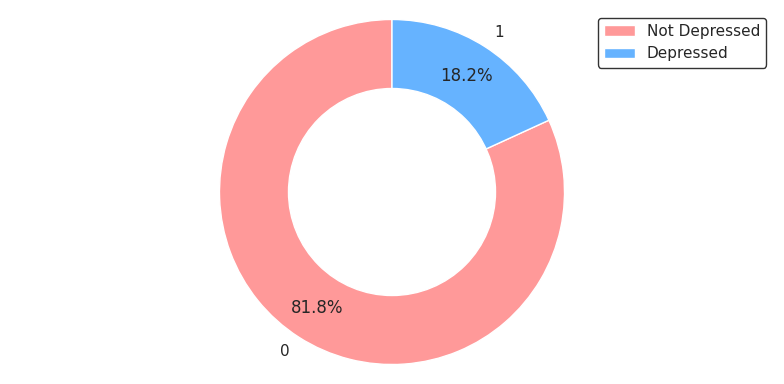

In [10]:
# Target label distribution
plot_donut_chart(df, "Depression", colors=['#ff9999', '#66b3ff'], legend_labels=['Not Depressed', 'Depressed'])

In [11]:
# Create a function to display column value counts and percent 
def cat_col_dist(df, col):
    # Calculate value counts and percentages
    value_counts = df[col].value_counts(dropna=False)
    percentages = (value_counts / len(df)) * 100

    # Create a DataFrame with counts and percentages
    counts_df = pd.DataFrame({'Count': value_counts,'Percentage': percentages.round(2)})
    return counts_df

### **Profession**

In [12]:
# Unique values for Profession
cat_col_dist(df, 'Profession')

Count  Percentage
Profession                               
NaN                     36630       26.03
Teacher                 24906       17.70
Content Writer           7814        5.55
Architect                4370        3.11
Consultant               4229        3.01
HR Manager               4022        2.86
Pharmacist               3893        2.77
Doctor                   3255        2.31
Business Analyst         3161        2.25
Entrepreneur             2968        2.11
Chemist                  2967        2.11
Chef                     2862        2.03
Educational Consultant   2852        2.03
Data Scientist           2390        1.70
Researcher               2328        1.65
Lawyer                   2212        1.57
Customer Support         2055        1.46
Marketing Manager        1976        1.40
Pilot                    1913        1.36
Travel Consultant        1860        1.32
Plumber                  1748        1.24
Sales Executive          1739        1.24
Manager                  1737        1.23
Judge                    1712        1.22
Electrician              1582        1.12
Financial Analyst        1574        1.12
Software Engineer        1510        1.07
Civil Engineer           1470        1.04
UX/UI Designer           1452        1.03
Digital Marketer         1372        0.98
Accountant               1339        0.95
Finanancial Analyst      1329        0.94
Mechanical Engineer      1177        0.84
Graphic Designer         1163        0.83
Research Analyst          690        0.49
Investment Banker         393        0.28
Student                     7        0.00
Academic                    5        0.00
Unemployed                  3        0.00
Yogesh                      3        0.00
BCA                         3        0.00
Profession                  3        0.00
MBA                         2        0.00
LLM                         2        0.00
PhD                         2        0.00
Pranav                      1        0.00
Analyst                     1        0.00
Visakhapatnam               1        0.00
Nagpur                      1        0.00
M.Ed                        1        0.00
B.Ed                        1        0.00
Moderate                    1        0.00
Family Consultant           1        0.00
BE                          1        0.00
B.Com                       1        0.00
Dev                         1        0.00
FamilyVirar                 1        0.00
City Manager                1        0.00
BBA                         1        0.00
Medical Doctor              1        0.00
Working Professional        1        0.00
MBBS                        1        0.00
Patna                       1        0.00
Unveil                      1        0.00
Yuvraj                      1        0.00

In [13]:
# Fix Finanancial Analyst
df['Profession'] = df['Profession'].replace('Finanancial Analyst', 'Financial Analyst')

In [14]:
# Clean up Professions and review the unqiue value count again
valid_professions = [
    'Teacher', 'Content Writer', 'Architect', 'Consultant', 'HR Manager', 
    'Pharmacist', 'Doctor', 'Business Analyst', 'Entrepreneur', 'Chemist', 
    'Chef', 'Educational Consultant', 'Data Scientist', 'Researcher', 'Lawyer',
    'Customer Support', 'Marketing Manager', 'Pilot', 'Travel Consultant', 'Plumber', 
    'Sales Executive', 'Manager', 'Judge', 'Electrician', 'Financial Analyst', 
    'Software Engineer', 'Civil Engineer', 'UX/UI Designer', 'Digital Marketer', 
    'Accountant', 'Finanancial Analyst', 'Mechanical Engineer', 
    'Graphic Designer', 'Research Analyst', 'Investment Banker', 'Student', 
    'Family Consultant', 'Analyst', 'Medical Doctor', 'City Manager', 'Unemployed'
]

# Map invalid entries to NaN
df['Prof'] = df['Profession'].where(df['Profession'].isin(valid_professions), "Unknown")
df_exception1 =  df[df['Prof']=="Unknown"]
print(f"Count of rows with invalid Profession: {df_exception1.shape[0]} ({df_exception1.shape[0]*100/len(df):.3f}%)")
cat_col_dist(df_exception1, 'Profession')

Count of rows with invalid Profession: 36666 (26.060%)


Count  Percentage
Profession                             
NaN                   36630       99.90
Academic                  5        0.01
BCA                       3        0.01
Yogesh                    3        0.01
Profession                3        0.01
PhD                       2        0.01
LLM                       2        0.01
MBA                       2        0.01
Dev                       1        0.00
BE                        1        0.00
B.Com                     1        0.00
FamilyVirar               1        0.00
Working Professional      1        0.00
MBBS                      1        0.00
Patna                     1        0.00
BBA                       1        0.00
Unveil                    1        0.00
B.Ed                      1        0.00
Moderate                  1        0.00
Nagpur                    1        0.00
M.Ed                      1        0.00
Pranav                    1        0.00
Visakhapatnam             1        0.00
Yuvraj                    1        0.00

In [15]:
# Check the unique values for Prof
cat_col_dist(df, 'Prof')

Count  Percentage
Prof                                     
Unknown                 36666       26.06
Teacher                 24906       17.70
Content Writer           7814        5.55
Architect                4370        3.11
Consultant               4229        3.01
HR Manager               4022        2.86
Pharmacist               3893        2.77
Doctor                   3255        2.31
Business Analyst         3161        2.25
Entrepreneur             2968        2.11
Chemist                  2967        2.11
Financial Analyst        2903        2.06
Chef                     2862        2.03
Educational Consultant   2852        2.03
Data Scientist           2390        1.70
Researcher               2328        1.65
Lawyer                   2212        1.57
Customer Support         2055        1.46
Marketing Manager        1976        1.40
Pilot                    1913        1.36
Travel Consultant        1860        1.32
Plumber                  1748        1.24
Sales Executive          1739        1.24
Manager                  1737        1.23
Judge                    1712        1.22
Electrician              1582        1.12
Software Engineer        1510        1.07
Civil Engineer           1470        1.04
UX/UI Designer           1452        1.03
Digital Marketer         1372        0.98
Accountant               1339        0.95
Mechanical Engineer      1177        0.84
Graphic Designer         1163        0.83
Research Analyst          690        0.49
Investment Banker         393        0.28
Student                     7        0.00
Unemployed                  3        0.00
Family Consultant           1        0.00
City Manager                1        0.00
Medical Doctor              1        0.00
Analyst                     1        0.00

In [16]:
# Define mapping for those with extreme low count
profession_mapping = {
    'Medical Doctor': 'Doctor',
    'Analyst': 'Business Analyst',
    'City Manager': 'Manager',
    'Family Consultant': 'Consultant',
}

# Apply the mapping to update the 'Prof' column
df['Prof'] = df['Prof'].replace(profession_mapping)

In [17]:
# Identify professions with count < 50
rare_professions = df['Prof'].value_counts()[df['Prof'].value_counts() < 50].index

# Replace rare professions with "Others"
df['Prof'] = df['Prof'].replace(rare_professions, 'Others')

In [18]:
# Recheck the unique values for Prof
cat_col_dist(df, 'Prof')

Count  Percentage
Prof                                     
Unknown                 36666       26.06
Teacher                 24906       17.70
Content Writer           7814        5.55
Architect                4370        3.11
Consultant               4230        3.01
HR Manager               4022        2.86
Pharmacist               3893        2.77
Doctor                   3256        2.31
Business Analyst         3162        2.25
Entrepreneur             2968        2.11
Chemist                  2967        2.11
Financial Analyst        2903        2.06
Chef                     2862        2.03
Educational Consultant   2852        2.03
Data Scientist           2390        1.70
Researcher               2328        1.65
Lawyer                   2212        1.57
Customer Support         2055        1.46
Marketing Manager        1976        1.40
Pilot                    1913        1.36
Travel Consultant        1860        1.32
Plumber                  1748        1.24
Sales Executive          1739        1.24
Manager                  1738        1.24
Judge                    1712        1.22
Electrician              1582        1.12
Software Engineer        1510        1.07
Civil Engineer           1470        1.04
UX/UI Designer           1452        1.03
Digital Marketer         1372        0.98
Accountant               1339        0.95
Mechanical Engineer      1177        0.84
Graphic Designer         1163        0.83
Research Analyst          690        0.49
Investment Banker         393        0.28
Others                     10        0.01

### **Dietary Habits | Sleep Duration**

In [19]:
# Reviewing Sleep Duration and Dietary Habits columns 
valid_dietary_habits = ["Healthy", "More Healthy", "Unhealthy", "No Healthy", "Moderate", "Less than Healthy", "Less Healthy"]
valid_sleep_duration = ['More than 8 hours', 'Less than 5 hours', '10 hours', '3-4 hours', '1-2 hours', '1-3 hours', '2-3 hours', '6-7 hours', '4-5 hours', '5-6 hours', '7-8 hours', '9-11 hours', '8-9 hours', '10-11 hours', '8 hours']

# Filter for rows with dietary habits NOT in valid_dietary_habits OR sleep duration NOT in valid_sleep_duration
df_exception =  df[(~df['Diet_Habits'].isin(valid_dietary_habits)) | (~df['Sleep_Duration'].isin(valid_sleep_duration))]
print(f"Count of rows with invalid Dietary Habits or Sleep Duration : {df_exception.shape[0]} ({df_exception.shape[0]*100/len(df):.3f}%)")
display(df_exception)

Count of rows with invalid Dietary Habits or Sleep Duration : 60 (0.043%)


id         Name  Gender   Age           City  \
2943      2943        Naina  Female  24.0          Patna   
4021      4021       Keshav    Male  59.0      Ghaziabad   
4495      4495        Aarav    Male  31.0       Vadodara   
12732    12732       Chhavi  Female  54.0          Delhi   
14225    14225        Manan    Male  47.0           Agra   
19915    19915         Zara  Female  27.0       Ludhiana   
20779    20779       Nikita  Female  39.0         Mumbai   
21736    21736        Divya  Female  24.0      Hyderabad   
22627    22627       Pranav    Male  59.0         Kanpur   
27865    27865        Vidhi  Female  31.0          Delhi   
28610    28610       Aakash    Male  23.0         Meerut   
29050    29050      Sanjeev    Male  23.0         Mumbai   
35953    35953        Aarav    Male  34.0          Thane   
41636    41636      Pallavi  Female  21.0         Jaipur   
42616    42616       Shreya  Female  32.0      Ahmedabad   
44890    44890        Ivaan    Male  39.0  Visakhapatnam   
45218    45218       Anjali  Female  44.0         Meerut   
47838    47838       Ritika  Female  23.0       Vadodara   
50817    50817      Utkarsh    Male  41.0      Faridabad   
56866    56866      Shaurya    Male  56.0         Meerut   
57597    57597         Diya  Female  58.0         Indore   
59350    59350       Tanmay    Male  34.0           Agra   
59490    59490        Samar    Male  54.0         Rajkot   
60071    60071        Gagan    Male  58.0         Rajkot   
60168    60168        Rupal  Female  43.0        Lucknow   
61185    61185        Arnav    Male  38.0          Thane   
64565    64565         Anvi  Female  23.0      Bangalore   
66929    66929       Damini  Female  54.0         Bhopal   
67200    67200        Nisha  Female  40.0       Varanasi   
68239    68239       Zegmay    Male  46.0         Bhopal   
69581    69581       Vikram    Male  48.0      Hyderabad   
72700    72700     Aaradhya  Female  33.0      Ahmedabad   
75587    75587     Rudransh    Male  26.0       Srinagar   
76041    76041        Navya  Female  27.0        Lucknow   
76261    76261       Prisha  Female  60.0         Kalyan   
76436    76436  Raghavendra    Male  37.0         Nashik   
79764    79764        Kiran  Female  35.0         Jaipur   
80918    80918     Aaradhya  Female  50.0    Vasai-Virar   
83861    83861       Mahika  Female  57.0         Jaipur   
85727    85727       Chhavi  Female  48.0       Varanasi   
86011    86011       Gaurav    Male  51.0        Lucknow   
87048    87048       Nikhil    Male  43.0           Pune   
94888    94888        Tanya  Female  53.0       Varanasi   
95502    95502         Mahi  Female  58.0         Nagpur   
96705    96705        Ivaan    Male  46.0          Delhi   
97056    97056        Anand    Male  49.0      Faridabad   
99340    99340        Ivaan    Male  56.0       Vadodara   
101955  101955        Ivaan    Male  54.0          Surat   
103062  103062       Nikhil    Male  49.0         Bhopal   
112297  112297       Gaurav    Male  44.0          Surat   
113519  113519       Vikram    Male  30.0      Ghaziabad   
118423  118423     Abhishek    Male  24.0        Kolkata   
121412  121412       Eshita  Female  57.0        Chennai   
123065  123065         Zara  Female  29.0       Srinagar   
123519  123519        Rohan    Male  46.0        Kolkata   
127056  127056       Ritika  Female  52.0      Hyderabad   
130206  130206       Trisha  Female  46.0       Varanasi   
131345  131345        Arnav    Male  25.0    Vasai-Virar   
132759  132759         Vani    Male  50.0       Srinagar   
136132  136132      Nandini  Female  50.0         Nagpur   

                      Status           Profession  Acad_Pressure  \
2943    Working Professional              Teacher            NaN   
4021    Working Professional                Judge            NaN   
4495    Working Professional           Researcher            NaN   
12732   Working Professional              Teacher            NaN   
14225   Wor

In [20]:
# Sleep Duration column

# Checking the count of rows containing specific anomalous values in the 'Sleep Duration' column
anomalous_sleep_values = ['Sleep_Duration', 'Work_Study_Hours', 'than 5 hours', 'Indore', 'Pune', 'No', 'Unhealthy']
anomalous_sleep_counts = df['Sleep_Duration'].isin(anomalous_sleep_values).sum()
anomalous_sleep_percent = anomalous_sleep_counts*100/len(df)
print(f"Count of rows with anomalous Sleep Duration values : {anomalous_sleep_counts} ({anomalous_sleep_percent:.4f}%)\n")
print(f"List of unique sleep duration : {df['Sleep_Duration'].unique().tolist()}\n")
display(cat_col_dist(df, 'Sleep_Duration'))

# Filtering rows with these specific anomalous values
anomalous_sleep_df = df[df['Sleep_Duration'].isin(anomalous_sleep_values)]
anomalous_sleep_df

Count of rows with anomalous Sleep Duration values : 12 (0.0085%)

List of unique sleep duration : ['More than 8 hours', 'Less than 5 hours', '5-6 hours', '7-8 hours', 'Sleep_Duration', '1-2 hours', '6-8 hours', '4-6 hours', '6-7 hours', '10-11 hours', '8-9 hours', '40-45 hours', '9-11 hours', '2-3 hours', '3-4 hours', 'Moderate', '55-66 hours', '4-5 hours', '9-6 hours', '1-3 hours', 'Indore', '45', '1-6 hours', '35-36 hours', '8 hours', 'No', '10-6 hours', 'than 5 hours', '49 hours', 'Unhealthy', 'Work_Study_Hours', '3-6 hours', '45-48 hours', '9-5', 'Pune', '9-5 hours']



Count  Percentage
Sleep_Duration                      
Less than 5 hours  38784       27.57
7-8 hours          36969       26.28
More than 8 hours  32726       23.26
5-6 hours          32142       22.84
3-4 hours             12        0.01
6-7 hours              8        0.01
4-5 hours              7        0.00
4-6 hours              5        0.00
2-3 hours              5        0.00
6-8 hours              4        0.00
No                     4        0.00
1-6 hours              4        0.00
10-11 hours            2        0.00
9-11 hours             2        0.00
8-9 hours              2        0.00
Sleep_Duration         2        0.00
Unhealthy              2        0.00
45                     2        0.00
40-45 hours            1        0.00
1-2 hours              1        0.00
1-3 hours              1        0.00
9-6 hours              1        0.00
55-66 hours            1        0.00
Moderate               1        0.00
35-36 hours            1        0.00
8 hours                1        0.00
10-6 hours             1        0.00
Indore                 1        0.00
than 5 hours           1        0.00
49 hours               1        0.00
Work_Study_Hours       1        0.00
3-6 hours              1        0.00
45-48 hours            1        0.00
9-5                    1        0.00
Pune                   1        0.00
9-5 hours              1        0.00

id      Name  Gender   Age         City                Status  \
4021      4021    Keshav    Male  59.0    Ghaziabad  Working Professional   
35953    35953     Aarav    Male  34.0        Thane  Working Professional   
45218    45218    Anjali  Female  44.0       Meerut  Working Professional   
66929    66929    Damini  Female  54.0       Bhopal  Working Professional   
68239    68239    Zegmay    Male  46.0       Bhopal  Working Professional   
75587    75587  Rudransh    Male  26.0     Srinagar               Student   
79764    79764     Kiran  Female  35.0       Jaipur  Working Professional   
80918    80918  Aaradhya  Female  50.0  Vasai-Virar  Working Professional   
94888    94888     Tanya  Female  53.0     Varanasi  Working Professional   
121412  121412    Eshita  Female  57.0      Chennai  Working Professional   
123519  123519     Rohan    Male  46.0      Kolkata  Working Professional   
132759  132759      Vani    Male  50.0     Srinagar  Working Professional   

                 Profession  Acad_Pressure  Work_Pressure  CGPA  Study_Sat  \
4021                  Judge            NaN            4.0   NaN        NaN   
35953            Consultant            NaN            3.0   NaN        NaN   
45218               Teacher            NaN            2.0   NaN        NaN   
66929                Doctor            NaN            3.0   NaN        NaN   
68239        Civil Engineer            NaN            5.0   NaN        NaN   
75587                   NaN            2.0            NaN  7.11        4.0   
79764   Mechanical Engineer            NaN            2.0   NaN        NaN   
80918     Financial Analyst            NaN            1.0   NaN        NaN   
94888               Teacher            NaN            3.0   NaN        NaN   
121412              Teacher            NaN            1.0   NaN        NaN   
123519       Data Scientist            NaN            2.0   NaN        NaN   
132759              Teacher            NaN            4.0   NaN        NaN   

        Job_Sat    Sleep_Duration Diet_Habits Degree Suicidal_Thoughts  \
4021        4.0    Sleep_Duration     Healthy    LLB               Yes   
35953       3.0    Sleep_Duration    Moderate    MCA               Yes   
45218       2.0            Indore    Moderate     MD                No   
66929       1.0                No     Healthy   MBBS                No   
68239       3.0                No   Unhealthy    MCA                No   
75587       NaN      than 5 hours   Unhealthy    PhD               Yes   
79764       1.0         Unhealthy   Unhealthy    BSc               Yes   
80918       3.0  Work_Study_Hours   Unhealthy  M.Com                No   
94888       2.0         Unhealthy   Unhealthy   M.Ed               Yes   
121412      3.0              Pune     Healthy     BA               Yes   
123519      1.0                No   Unhealthy    BSc                No   
132759      4.0                No   Unhealthy    LLB               Yes   

        Work_Study_Hours  Fin_Stress Family_History_MI  Depression  \
4021                10.0         1.0                No           0   
35953                9.0         3.0               Yes           0   
45218                6.0         4.0               Yes           0   
66929                5.0         1.0                No           0   
68239                3.0         1.0               Yes           0   
75587                9.0         2.0                No           0   
79764                6.0         2.0                No           0   
80918                2.0         3.0               Yes           0   
94888                0.0         5.0                No           0   
121412              11.0         5.0               Yes           0   
123519               6.0         4.0               Yes           0   
132759               2.0         3.0                No           0   

                       Prof  
4021                  Judge  
35953            Consultant  
45218               Teacher  
6

In [21]:
# Define standard categories and mapping for 'Dietary Habits'
sleep_categories = {
    "Less than 5 hours": "Less than 5 hours",
    "3-4 hours": "Less than 5 hours",
    "4-5 hours": "Less than 5 hours",
    "2-3 hours": "Less than 5 hours",
    "1-2 hours": "Less than 5 hours",
    "1-3 hours": "Less than 5 hours",
    "5-6 hours": "5-6 hours",
    "6-7 hours": "6-7 hours",
    "7-8 hours": "7-8 hours",
    "More than 8 hours": "More than 8 hours",
    "8-9 hours": "More than 8 hours",
    "8 hours": "More than 8 hours",
    "9-11 hours": "More than 8 hours",
    "10-11 hours": "More than 8 hours",
    "10 hours": "More than 8 hours"
}

# Replace values based on dietary_categories mapping
df['Sleep_Duration'] = df['Sleep_Duration'].replace(sleep_categories)

# Convert unmatched values to "Unknown"
df['Sleep_Duration'] = df['Sleep_Duration'].where(df['Sleep_Duration'].isin(sleep_categories.values()), "Unknown")

# Re-check counts after standardization
display(cat_col_dist(df, 'Sleep_Duration'))

# Count missing values after standardization
missing_count = df['Sleep_Duration'].isnull().sum()
print(f"\nCount of missing values after standardization: {missing_count}")

Count  Percentage
Sleep_Duration                      
Less than 5 hours  38810       27.58
7-8 hours          36969       26.28
More than 8 hours  32733       23.26
5-6 hours          32142       22.84
Unknown               38        0.03
6-7 hours              8        0.01


Count of missing values after standardization: 0


In [22]:
# Dietary Habits column
# Define anomalous values in the 'Dietary Habits' column for counting and filtering
anomalous_dietary_values = ['Yes', 'No', 'Pratham', 'BSc', 'Gender', '3', 'Mihir', '1.0', 'Hormonal', 'Electrician', 
                            'M.Tech', 'Vegas', 'Male', 'Indoor', 'Class 12', '2']

# Counting rows with anomalous values in the 'Dietary Habits' column
anomalous_dietary_counts = df['Diet_Habits'].isin(anomalous_dietary_values).sum()
anomalous_dietary_percent = anomalous_dietary_counts*100/len(df)
print(f"Count of rows with anomalous Dietary Habits values : {anomalous_dietary_counts} ({anomalous_dietary_percent:.2f}%)\n")
print(f"List of unique dietary habits : {df['Diet_Habits'].unique().tolist()}\n")
display(cat_col_dist(df, 'Diet_Habits'))

# Filtering rows with these specific anomalous values
anomalous_dietary_rows = df[df['Diet_Habits'].isin(anomalous_dietary_values)]
anomalous_dietary_rows

Count of rows with anomalous Dietary Habits values : 18 (0.01%)

List of unique dietary habits : ['Healthy', 'Unhealthy', 'Moderate', 'Yes', 'Pratham', 'BSc', 'Gender', '3', 'More Healthy', 'Less than Healthy', 'Mihir', '1.0', 'Hormonal', 'Electrician', nan, 'No Healthy', 'Less Healthy', 'M.Tech', 'Vegas', 'No', 'Male', 'Indoor', 'Class 12', '2']



Count  Percentage
Diet_Habits                         
Moderate           49705       35.33
Unhealthy          46227       32.86
Healthy            44741       31.80
NaN                    4        0.00
More Healthy           2        0.00
No                     2        0.00
Yes                    2        0.00
Pratham                1        0.00
3                      1        0.00
Gender                 1        0.00
BSc                    1        0.00
Mihir                  1        0.00
1.0                    1        0.00
Hormonal               1        0.00
Electrician            1        0.00
Less than Healthy      1        0.00
No Healthy             1        0.00
Less Healthy           1        0.00
M.Tech                 1        0.00
Vegas                  1        0.00
Male                   1        0.00
Indoor                 1        0.00
Class 12               1        0.00
2                      1        0.00

id      Name  Gender   Age         City                Status  \
2943      2943     Naina  Female  24.0        Patna  Working Professional   
4495      4495     Aarav    Male  31.0     Vadodara  Working Professional   
20779    20779    Nikita  Female  39.0       Mumbai  Working Professional   
21736    21736     Divya  Female  24.0    Hyderabad  Working Professional   
28610    28610    Aakash    Male  23.0       Meerut               Student   
41636    41636   Pallavi  Female  21.0       Jaipur               Student   
42616    42616    Shreya  Female  32.0    Ahmedabad               Student   
56866    56866   Shaurya    Male  56.0       Meerut  Working Professional   
57597    57597      Diya  Female  58.0       Indore  Working Professional   
76041    76041     Navya  Female  27.0      Lucknow               Student   
86011    86011    Gaurav    Male  51.0      Lucknow  Working Professional   
95502    95502      Mahi  Female  58.0       Nagpur  Working Professional   
103062  103062    Nikhil    Male  49.0       Bhopal  Working Professional   
113519  113519    Vikram    Male  30.0    Ghaziabad               Student   
118423  118423  Abhishek    Male  24.0      Kolkata               Student   
123065  123065      Zara  Female  29.0     Srinagar  Working Professional   
130206  130206    Trisha  Female  46.0     Varanasi  Working Professional   
131345  131345     Arnav    Male  25.0  Vasai-Virar               Student   

               Profession  Acad_Pressure  Work_Pressure  CGPA  Study_Sat  \
2943              Teacher            NaN            3.0   NaN        NaN   
4495           Researcher            NaN            4.0   NaN        NaN   
20779   Financial Analyst            NaN            3.0   NaN        NaN   
21736             Teacher            NaN            5.0   NaN        NaN   
28610                 NaN            3.0            NaN  9.98        5.0   
41636                 NaN            2.0            NaN  7.28        4.0   
42616                 NaN            4.0            NaN  9.54        4.0   
56866          Pharmacist            NaN            2.0   NaN        NaN   
57597          Consultant            NaN            4.0   NaN        NaN   
76041                 NaN            5.0            NaN  5.82        3.0   
86011          Pharmacist            NaN            2.0   NaN        NaN   
95502             Plumber            NaN            3.0   NaN        NaN   
103062   Graphic Designer            NaN            5.0   NaN        NaN   
113519                NaN            5.0            NaN  5.99        2.0   
118423                NaN            1.0            NaN  8.47        2.0   
123065          Architect            NaN            3.0   NaN        NaN   
130206            Teacher            NaN            3.0   NaN        NaN   
131345                NaN            3.0            NaN  5.60        3.0   

        Job_Sat     Sleep_Duration  Diet_Habits   Degree Suicidal_Thoughts  \
2943        2.0  Less than 5 hours          Yes      LLB               Yes   
4495        2.0          7-8 hours      Pratham      MCA               Yes   
20779       2.0          7-8 hours          BSc      MBA                No   
21736       2.0  More than 8 hours       Gender      BCA               Yes   
28610       NaN  Less than 5 hours            3    B.Com               Yes   
41636       NaN  Less than 5 hours        Mihir  B.Pharm               Yes   
42616       NaN          5-6 hours          1.0     B.Ed               Yes   
56866       3.0  Less than 5 hours     Hormonal  B.Pharm               Yes   
57597       2.0  Less than 5 hours  Electrician      MSc               Yes   
76041       NaN  Less than 5 hours       M.Tech      BSc               Yes   
86011       1.0          7-8 hours        Vegas  B.Pharm                No   
95502       2.0          5-6 hours           No      PhD                No   
103062      4.0  Less than 5 hours           No      BCA                No   
113519     

In [23]:
# Define standard categories and mapping for 'Dietary Habits'
dietary_categories = {
    "Healthy": "Healthy", 
    "More Healthy": "Healthy",
    "Yes": "Healthy",
    "Unhealthy": "Unhealthy",
    "No Healthy": "Unhealthy",
    "No": "Unhealthy",
    "Moderate": "Moderate",
    "Less than Healthy": "Moderate",
    "Less Healthy": "Moderate"
}

# Replace values based on dietary_categories mapping
df['Diet_Habits'] = df['Diet_Habits'].replace(dietary_categories)

# Convert unmatched values to "Unknown"
df['Diet_Habits'] = df['Diet_Habits'].where(df['Diet_Habits'].isin(dietary_categories.values()), "Unknown")

# Re-check counts after standardization
display(cat_col_dist(df, 'Diet_Habits'))

# Count missing values after standardization
missing_count = df['Diet_Habits'].isnull().sum()
print(f"\nCount of missing values after standardization: {missing_count}")

Count  Percentage
Diet_Habits                   
Moderate     49707       35.33
Unhealthy    46230       32.86
Healthy      44745       31.80
Unknown         18        0.01


Count of missing values after standardization: 0


### **Degree**

In [24]:
# Degree column
display(cat_col_dist(df, 'Degree'))

Count  Percentage
Degree                                 
Class 12              14729       10.47
B.Ed                  11691        8.31
B.Arch                 8742        6.21
B.Com                  8113        5.77
B.Pharm                5856        4.16
BCA                    5739        4.08
M.Ed                   5668        4.03
MCA                    5234        3.72
BBA                    5030        3.57
BSc                    5027        3.57
MSc                    4879        3.47
LLM                    4647        3.30
M.Pharm                4537        3.22
M.Tech                 4475        3.18
B.Tech                 4425        3.14
LLB                    4348        3.09
BHM                    4305        3.06
MBA                    3818        2.71
BA                     3750        2.67
ME                     3632        2.58
MD                     3383        2.40
MHM                    3286        2.34
BE                     3104        2.21
PhD                    3103        2.21
M.Com                  3094        2.20
MBBS                   3082        2.19
MA                     2887        2.05
M.Arch                    5        0.00
UX/UI Designer            4        0.00
Kalyan                    3        0.00
M                         3        0.00
B.Sc                      3        0.00
NaN                       2        0.00
LL B.Ed                   2        0.00
Jhanvi                    2        0.00
BEd                       2        0.00
Nalini                    2        0.00
Bhopal                    2        0.00
B                         2        0.00
MEd                       2        0.00
Degree                    2        0.00
BPharm                    2        0.00
LLBA                      2        0.00
P.Com                     2        0.00
L.Ed                      2        0.00
BArch                     2        0.00
Advait                    1        0.00
Working Professional      1        0.00
Esha                      1        0.00
LLS                       1        0.00
LLEd                      1        0.00
E.Tech                    1        0.00
Marsh                     1        0.00
HCA                       1        0.00
5.88                      1        0.00
B.Student                 1        0.00
MPA                       1        0.00
BH                        1        0.00
M.S                       1        0.00
Navya                     1        0.00
HR Manager                1        0.00
Badhya                    1        0.00
S.Pharm                   1        0.00
Vrinda                    1        0.00
M. Business Analyst       1        0.00
Bhavesh                   1        0.00
0                         1        0.00
LLCom                     1        0.00
29                        1        0.00
MTech                     1        0.00
Vivaan                    1        0.00
BPA                       1        0.00
Plumber                   1        0.00
5.61                      1        0.00
Brit                      1        0.00
B.03                      1        0.00
Ritik                     1        0.00
5.56                      1        0.00
B BA                      1        0.00
7.06                      1        0.00
B.B.Arch                  1        0.00
ACA                       1        0.00
Brithika                  1        0.00
CGPA                      1        0.00
Veda                      1        0.00
S.Tech                    1        0.00
20                        1        0.00
Class 11                  1        0.00
H_Pharm                   1        0.00
24                        1        0.00
M_Tech                    1        0.00
Pihu                      1        0.00
BB                        1        0.00
LLTech                    1        0.00
Aarav                     1        0.00
Entrepreneur              1        0.00
8.56                      1        0.00
LHM                       1        0.00
Lata                  

In [25]:
# Create dictionaries for levels and fields
level_dict = {
    "High School": ["Class 12", "Class 11"],
    "Bachelor": ["BEd", "B.Ed", "B.Arch", "B.B.Arch", "BArch", "B.Com", "BCom", "B.Pharm", "BPharm", "BCA", "BBA", "B BA", "BSc", "B.Sc", "B.Tech", "LLB", "BA", "MBBS", "BE", "BHM", "B B.Com", "BPA"],
    "Master": ["M.Ed", "MEd", "M_Tech", "MCA", "MSc", "M.S", "LLM", "LLEd", "LL B.Ed", "L.Ed", "LLCom", "LL.Com","LLTech", "M.Pharm", "MPharm", "M.Tech", "MTech", "MCom", "MBA", "MA", "MHM", "ME", "M.Arch", "M.Com"],
    "Doctorate": ["PhD", "MD"]
}

field_dict = {
    "Commerce": ["B.Com", "M.Com", "MBA", "B B.Com", "BCom"],
    "Education": ["B.Ed", "M.Ed", "BEd", "MEd"],
    "Engineering": ["BCA", "MCA", "B.Tech", "M.Tech", "M_Tech", "MTech", "BE", "ME"],
    "Healthcare": ["B.Pharm", "M.Pharm", "MBBS", "MD", "MPharm", "BPharm"],
    "Law": ["LLB", "LLM", "LL B.Ed", "L.Ed", "LLEd", "LLCom", "LL.Com", "LLTech"],
    "Architecture": ["B.Arch", "M.Arch", "BArch", "B.B.Arch"],
    "Science": ["BSc", "MSc", "PhD", "B.Sc", "M.S"],
    "Business Management": ["BBA", "MBA", "B BA"],
    "Hospitality": ["BHM", "MHM"],
    "Arts/Humanities": ["BA", "MA", "BPA"]
}

In [26]:
# Split Degree into Educational Level and Field
df['Ed_Level'] = df['Degree'].apply(
    lambda x: next((level for level, degrees in level_dict.items() if str(x).strip().lower() 
    in map(str.lower, degrees)), "Unknown"))

df['Ed_Field'] = df['Degree'].apply(
    lambda x: next((field for field, degrees in field_dict.items() if str(x).strip().lower() 
    in map(str.lower, degrees)),"Unknown"))

In [27]:
# Filter for rows with Degree NOT in valid_degree
df_exception2 =  df[df['Ed_Level']=="Unknown"]
print(f"Count of rows with invalid Degree : {df_exception2.shape[0]} ({df_exception2.shape[0]*100/len(df):.3f}%)")
display(df_exception2)

Count of rows with invalid Degree : 83 (0.059%)


id       Name  Gender   Age           City                Status  \
1884      1884     Sanket    Male  51.0      Ahmedabad  Working Professional   
3227      3227      Rahil    Male  28.0       Varanasi               Student   
4337      4337      Mihir    Male  28.0  Visakhapatnam               Student   
7885      7885       Diya  Female  38.0       Ludhiana  Working Professional   
9923      9923    Pallavi  Female  46.0      Faridabad  Working Professional   
13315    13315    Aanchal  Female  20.0         Bhopal               Student   
14834    14834      Gagan    Male  27.0        Kolkata               Student   
15483    15483      Ayush    Male  20.0    Vasai-Virar  Working Professional   
16067    16067   Rudransh    Male  20.0        Lucknow               Student   
19909    19909   Aaradhya  Female  58.0         Bhopal  Working Professional   
20659    20659    Nishant    Male  19.0        Kolkata               Student   
22201    22201     Khushi  Female  22.0    Vasai-Virar               Student   
24425    24425       Neil    Male  35.0          Surat  Working Professional   
25296    25296      Ayush    Male  38.0         Indore  Working Professional   
26342    26342       Ansh    Male  54.0         Rajkot  Working Professional   
31876    31876      Parth    Male  44.0           Pune  Working Professional   
34039    34039     Ritvik    Male  60.0           Agra  Working Professional   
35210    35210     Sanket    Male  33.0         Kalyan               Student   
36669    36669      Rohan    Male  54.0       Srinagar  Working Professional   
37627    37627     Aadhya  Female  30.0      Ghaziabad               Student   
37676    37676       Tina  Female  46.0      Bangalore  Working Professional   
38181    38181    Ranveer    Male  25.0         Rajkot  Working Professional   
38443    38443   Aaradhya  Female  45.0          Thane  Working Professional   
39064    39064      Rishi    Male  53.0          Thane  Working Professional   
39807    39807     Advait    Male  54.0          Delhi  Working Professional   
40387    40387     Aahana  Female  24.0       Srinagar               Student   
44512    44512     Prisha  Female  18.0       Vadodara  Working Professional   
44937    44937     Shivam    Male  26.0         Nagpur               Student   
45238    45238     Shivan    Male  52.0      Ghaziabad  Working Professional   
45833    45833      Rohan    Male  40.0      Hyderabad  Working Professional   
46696    46696     Chirag    Male  32.0        Kolkata               Student   
47720    47720       Esha  Female  53.0      Hyderabad  Working Professional   
48107    48107      Arnav    Male  57.0    Vasai-Virar  Working Professional   
52569    52569      Rishi    Male  43.0         Kalyan  Working Professional   
52739    52739       Ansh    Male  54.0    Vasai-Virar  Working Professional   
55299    55299      Shlok    Male  52.0         Meerut  Working Professional   
60403    60403     Raunak    Male  27.0      Ahmedabad               Student   
61472    61472     Gaurav    Male  23.0         Mumbai               Student   
63512    63512     Himani  Female  35.0       Srinagar  Working Professional   
65207    65207     Saurav    Male  50.0         Mumbai  Working Professional   
65379    65379      Harsh    Male  35.0          Surat  Working Professional   
68151    68151      Rishi    Male  31.0         Kanpur               Student   
68523    68523      Anand    Male  27.0      Ahmedabad               Student   
68882    68882     Harsha    Male  24.0         Rajkot               Student   
71818    71818     Vikram    Male  47.0          Surat  Working Professional   
72284    72284     Vikram    Male  40.0          Thane  Working Professional   
72431    72431        Ira  Female  47.0       Ludhiana  Working Professional   
76656    76656      Aarav    Male  48.0          Patna  Working Professional   
78265    78265      Rohan    Male  39.0       Ludhiana  Working Professional   
80206    802

### **City**

In [28]:
# Degree column
display(cat_col_dist(df, 'City'))

Count  Percentage
City                                 
Kalyan               6591        4.68
Patna                5924        4.21
Vasai-Virar          5765        4.10
Kolkata              5689        4.04
Ahmedabad            5613        3.99
Meerut               5528        3.93
Ludhiana             5226        3.71
Pune                 5210        3.70
Rajkot               5207        3.70
Visakhapatnam        5176        3.68
Srinagar             5074        3.61
Mumbai               4966        3.53
Indore               4872        3.46
Agra                 4684        3.33
Surat                4636        3.29
Varanasi             4606        3.27
Vadodara             4568        3.25
Hyderabad            4496        3.20
Kanpur               4398        3.13
Jaipur               4328        3.08
Thane                4289        3.05
Lucknow              4280        3.04
Nagpur               4209        2.99
Bangalore            4123        2.93
Chennai              4044        2.87
Ghaziabad            3620        2.57
Delhi                3593        2.55
Bhopal               3475        2.47
Faridabad            3268        2.32
Nashik               3144        2.23
Mihir                   7        0.00
Nandini                 4        0.00
Mahi                    3        0.00
Bhavna                  3        0.00
Saanvi                  3        0.00
Vidya                   3        0.00
Harsha                  3        0.00
City                    3        0.00
Pratyush                3        0.00
MCA                     2        0.00
Atharv                  2        0.00
M.Com                   2        0.00
Ayush                   2        0.00
Keshav                  2        0.00
Nalini                  2        0.00
Molkata                 2        0.00
Itheg                   1        0.00
Nalyan                  1        0.00
Dhruv                   1        0.00
Aaradhya                1        0.00
M.Tech                  1        0.00
Raghavendra             1        0.00
Malyansh                1        0.00
Khaziabad               1        0.00
Khushi                  1        0.00
Pooja                   1        0.00
Plata                   1        0.00
Less Delhi              1        0.00
Mira                    1        0.00
Less than 5 Kalyan      1        0.00
3.0                     1        0.00
Gurgaon                 1        0.00
Aishwarya               1        0.00
Krishna                 1        0.00
Aditya                  1        0.00
Galesabad               1        0.00
Moreadhyay              1        0.00
Morena                  1        0.00
Kashk                   1        0.00
Ishkarsh                1        0.00
Anvi                    1        0.00
Krinda                  1        0.00
Ayansh                  1        0.00
Tolkata                 1        0.00
Ivaan                   1        0.00
Vaanya                  1        0.00
Gaurav                  1        0.00
Harsh                   1        0.00
Reyansh                 1        0.00
Ishanabad               1        0.00
Vidhi                   1        0.00
Shrey                   1        0.00
Kashish                 1        0.00
Kibara                  1        0.00
Chhavi                  1        0.00
Vaishnavi               1        0.00
Tushar                  1        0.00
MSc                     1        0.00
No                      1        0.00
Parth                   1        0.00
Rashi                   1        0.00
ME                      1        0.00
Researcher              1        0.00
Kagan                   1        0.00
Armaan                  1        0.00
Ithal                   1        0.00
Jhanvi                  1        0.00
Unirar                  1        0.00

In [29]:
valid_cities = [
    'Ludhiana', 'Varanasi', 'Visakhapatnam', 'Mumbai', 'Kanpur', 'Ahmedabad', 
    'Thane', 'Nashik', 'Bangalore', 'Patna', 'Rajkot', 'Jaipur', 'Pune', 
    'Lucknow', 'Meerut', 'Agra', 'Surat', 'Faridabad', 'Hyderabad', 
    'Srinagar', 'Ghaziabad', 'Kolkata', 'Chennai', 'Kalyan', 'Nagpur', 
    'Vadodara', 'Vasai-Virar', 'Delhi', 'Bhopal', 'Indore'
]

# Define bins based on geography
bins = {
    "North India": ['Delhi', 'Lucknow', 'Jaipur', 'Agra', 'Meerut', 'Ludhiana', 'Srinagar', 'Varanasi', 'Kanpur', 'Ghaziabad', 'Faridabad'],
    "South India": ['Bangalore', 'Chennai', 'Hyderabad', 'Visakhapatnam'],
    "East India": ['Kolkata', 'Patna'],
    "West India": ['Mumbai', 'Pune', 'Ahmedabad', 'Surat', 'Nagpur', 'Rajkot', 'Vadodara', 'Thane', 'Kalyan', 'Nashik'],
    "Central India": ['Bhopal', 'Indore']
}

In [30]:
# Create a reverse mapping from city to region
city_to_region = {city: region for region, cities in bins.items() for city in cities}

# Replace values in the City column with null if not in the valid cities list
df['City'] = df['City'].apply(lambda x: x if x in valid_cities else "Unknown")

# Add a new column "Region"
df['Region'] = df['City'].map(city_to_region).fillna("Unknown")

In [31]:
# Filter for rows with Degree NOT in valid_degree
df_exception3 =  df[df['City']=="Unknown"]
print(f"Count of rows with invalid City : {df_exception3.shape[0]} ({df_exception3.shape[0]*100/len(df):.3f}%)")
display(df_exception3)

Count of rows with invalid City : 98 (0.070%)


id       Name  Gender   Age     City                Status  \
762        762      Kiran    Male  23.0  Unknown  Working Professional   
1190      1190      Divya  Female  43.0  Unknown  Working Professional   
2123      2123     Atharv    Male  58.0  Unknown  Working Professional   
3554      3554     Suhani  Female  44.0  Unknown  Working Professional   
3753      3753    Krishna    Male  53.0  Unknown  Working Professional   
8772      8772     Garima  Female  53.0  Unknown  Working Professional   
12371    12371     Keshav    Male  51.0  Unknown  Working Professional   
15181    15181   Rudransh    Male  42.0  Unknown  Working Professional   
17337    17337       Isha  Female  54.0  Unknown  Working Professional   
18496    18496     Vihaan    Male  45.0  Unknown  Working Professional   
20886    20886      Vidya  Female  57.0  Unknown  Working Professional   
22215    22215      Arjun    Male  60.0  Unknown  Working Professional   
22293    22293     Harsha    Male  27.0  Unknown               Student   
28672    28672     Satyam    Male  29.0  Unknown               Student   
28862    28862     Vikram    Male  30.0  Unknown               Student   
30231    30231     Aahana  Female  29.0  Unknown               Student   
32706    32706    Aanchal  Female  26.0  Unknown  Working Professional   
33276    33276     Tushar    Male  56.0  Unknown  Working Professional   
33408    33408      Rupal  Female  24.0  Unknown  Working Professional   
33447    33447     Aditya    Male  48.0  Unknown  Working Professional   
34247    34247     Suhani  Female  39.0  Unknown  Working Professional   
34300    34300    Aanchal  Female  28.0  Unknown               Student   
35309    35309      Sanya  Female  21.0  Unknown               Student   
36993    36993      Anand    Male  31.0  Unknown               Student   
38232    38232      Naina  Female  59.0  Unknown  Working Professional   
38817    38817       Veda  Female  20.0  Unknown               Student   
39217    39217      Rupak    Male  31.0  Unknown  Working Professional   
42134    42134     Prisha  Female  48.0  Unknown  Working Professional   
42470    42470    Ishaani  Female  34.0  Unknown  Working Professional   
43050    43050      Kavya  Female  39.0  Unknown  Working Professional   
44087    44087     Yuvraj    Male  29.0  Unknown               Student   
44166    44166    Aanchal  Female  51.0  Unknown  Working Professional   
49098    49098       Zara  Female  52.0  Unknown  Working Professional   
50691    50691     Jhanvi  Female  43.0  Unknown  Working Professional   
52500    52500      Vidya  Female  41.0  Unknown  Working Professional   
53366    53366     Raunak    Male  50.0  Unknown  Working Professional   
55743    55743       Veda  Female  60.0  Unknown  Working Professional   
55970    55970      Ritik    Male  52.0  Unknown  Working Professional   
55982    55982      Anand    Male  54.0  Unknown  Working Professional   
57185    57185      Rajat    Male  37.0  Unknown  Working Professional   
58776    58776     Ayansh    Male  59.0  Unknown  Working Professional   
60210    60210      Rajat    Male  60.0  Unknown  Working Professional   
61035    61035     Harsha    Male  56.0  Unknown  Working Professional   
61687    61687      Aariv    Male  48.0  Unknown  Working Professional   
63830    63830      Gagan    Male  21.0  Unknown               Student   
65042    65042        Ira  Female  29.0  Unknown               Student   
67795    67795     Advait    Male  42.0  Unknown  Working Professional   
68667    68667     Aarohi  Female  21.0  Unknown               Student   
70407    70407       Amit    Male  20.0  Unknown               Student   
70668    70668      Ritik    Male  31.0  Unknown  Working Professional   
71144    71144      Aarav    Male  18.0  Unknown               Student   
71995    71995     Aadhya  Female  22.0  Unknown  Working Professional   
73510    73510     Aditya    Male  21.0  Unknown               Student   
73571    73571  

### **Split into Working Professional and Student**

In [32]:
# Drop id since this is a unique identifier
# Drop Name as it does not add much value to the analysis
# Drop Degree since we have split it into Level and Field
# Drop Profession since Prof is a cleaned version of Profession

# Drop irrelevant columns in the dataset
df = df.drop(columns=['id', 'Name', 'Degree', 'Profession'])
get_combined_stats(df)

Column Datatype  Missing Value Count  % Missing  \
0              Gender   object                    0   0.000000   
1                 Age  float64                    0   0.000000   
2                City   object                    0   0.000000   
3              Status   object                    0   0.000000   
4       Acad_Pressure  float64               112803  80.172708   
5       Work_Pressure  float64                27918  19.842217   
6                CGPA  float64               112802  80.171997   
7           Study_Sat  float64               112803  80.172708   
8             Job_Sat  float64                27910  19.836532   
9      Sleep_Duration   object                    0   0.000000   
10        Diet_Habits   object                    0   0.000000   
11  Suicidal_Thoughts   object                    0   0.000000   
12   Work_Study_Hours  float64                    0   0.000000   
13         Fin_Stress  float64                    4   0.002843   
14  Family_History_MI   object                    0   0.000000   
15         Depression    int64                    0   0.000000   
16               Prof   object                    0   0.000000   
17           Ed_Level   object                    0   0.000000   
18           Ed_Field   object                    0   0.000000   
19             Region   object                    0   0.000000   

    Zero Value Count  % Zero            Min Value             Max Value  \
0                  0    0.00               Female                  Male   
1                  0    0.00                 18.0                  60.0   
2                  0    0.00              Unknown                Kalyan   
3                  0    0.00              Student  Working Professional   
4                  0    0.00                  1.0                   5.0   
5                  0    0.00                  1.0                   5.0   
6                  0    0.00                 5.03                  10.0   
7                  0    0.00                  1.0                   5.0   
8                  0    0.00                  1.0                   5.0   
9                  0    0.00            6-7 hours     Less than 5 hours   
10                 0    0.00              Unknown              Moderate   
11                 0    0.00                  Yes                    No   
12             12066    8.58                  0.0                  12.0   
13                 0    0.00                  1.0                   5.0   
14                 0    0.00                  Yes                    No   
15            115133   81.83                  0.0                   1.0   
16                 0    0.00               Others               Unknown   
17                 0    0.00              Unknown              Bachelor   
18                 0    0.00  Business Management           Engineering   
19                 0    0.00              Unknown           North India   

    Unique Value Count  \
0                    2   
1                   43   
2                   31   
3                    2   
4                    5   
5                    5   
6                  331   
7                    5   
8                    5   
9                    6   
10                   4   
11                   2   
12                  13   
13                   5   
14                   2   
15                   2   
16                  36   
17                   5   
18                  11   
19                   6   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         Unique Values  


In [33]:
# Split the dataset into `Working Professional` and `Student`
df_working = df[df['Status'] == 'Working Professional']
df_student = df[df['Status'] == 'Student']

print(f"Working Professional dataset has {df_working.shape[0]} rows.")
print(f"Student dataset has {df_student.shape[0]} rows.")

Working Professional dataset has 112799 rows.
Student dataset has 27901 rows.


Distribution of 'Depression' for Working Professional


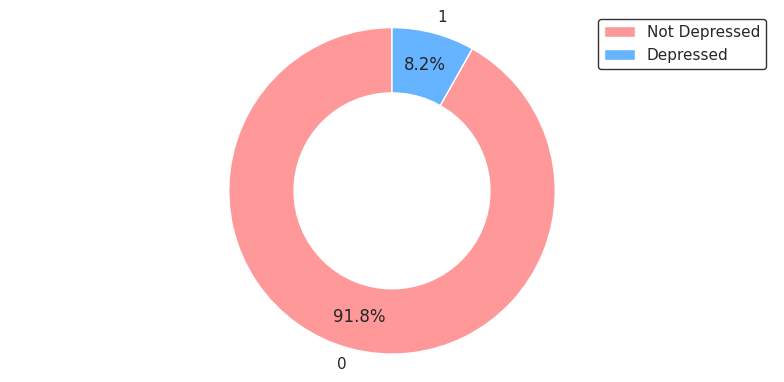

----------------------------------------------------------------------------------------------------


Column Datatype  Missing Value Count  % Missing  \
0              Gender   object                    0   0.000000   
1                 Age  float64                    0   0.000000   
2                City   object                    0   0.000000   
3              Status   object                    0   0.000000   
4       Acad_Pressure  float64               112794  99.995567   
5       Work_Pressure  float64                   20   0.017731   
6                CGPA  float64               112793  99.994681   
7           Study_Sat  float64               112793  99.994681   
8             Job_Sat  float64                   17   0.015071   
9      Sleep_Duration   object                    0   0.000000   
10        Diet_Habits   object                    0   0.000000   
11  Suicidal_Thoughts   object                    0   0.000000   
12   Work_Study_Hours  float64                    0   0.000000   
13         Fin_Stress  float64                    1   0.000887   
14  Family_History_MI   object                    0   0.000000   
15         Depression    int64                    0   0.000000   
16               Prof   object                    0   0.000000   
17           Ed_Level   object                    0   0.000000   
18           Ed_Field   object                    0   0.000000   
19             Region   object                    0   0.000000   

    Zero Value Count  % Zero             Min Value             Max Value  \
0                  0    0.00                Female                  Male   
1                  0    0.00                  18.0                  60.0   
2                  0    0.00               Unknown                Kalyan   
3                  0    0.00  Working Professional  Working Professional   
4                  0    0.00                   2.0                   4.0   
5                  0    0.00                   1.0                   5.0   
6                  0    0.00                  5.42                  9.72   
7                  0    0.00                   2.0                   5.0   
8                  0    0.00                   1.0                   5.0   
9                  0    0.00             6-7 hours     Less than 5 hours   
10                 0    0.00               Unknown              Moderate   
11                 0    0.00                   Yes                    No   
12             10366    9.19                   0.0                  12.0   
13                 0    0.00                   1.0                   5.0   
14                 0    0.00                    No                   Yes   
15            103568   91.82                   0.0                   1.0   
16                 0    0.00                Others               Teacher   
17                 0    0.00               Unknown              Bachelor   
18                 0    0.00   Business Management           Engineering   
19                 0    0.00               Unknown            West India   

    Unique Value Count  \
0                    2   
1                   43   
2                   31   
3                    1   
4                    3   
5                    5   
6                    6   
7                    4   
8                    5   
9                    6   
10                   4   
11                   2   
12                  13   
13                   5   
14                   2   
15                   2   
16                  36   
17                   5   
18                  11   
19                   6   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    

In [34]:
# Plot distribution of Depression for working professional
print("Distribution of 'Depression' for Working Professional")
plot_donut_chart(df_working, "Depression", colors=['#ff9999', '#66b3ff'], legend_labels=['Not Depressed', 'Depressed'])
print("----------"*10)
get_combined_stats(df_working)

**OBSERVATIONS for Working Professionals**
---
- The dataset is heavily imbalanced in terms of the depression distribution, with most working professionals not being depressed (92% vs 8%). Oversampling techniques will be applied to balance the depression labels.
- Acad_Pressure, CGPA, Study_Sat have a significantly high percentage of missing values (~100%). They will be removed from the Working Professionals dataset.

In [35]:
# Drop Working Professional or Student since it has only one unique value.
# Drop Academic Pressure, CGPA, Study Satisfaction since they are missing nearly all their values (>99%).

# Drop irrelevant columns in the Working Professional dataset
df_working = df_working.drop(columns=['Status', 'Acad_Pressure', 'CGPA', 'Study_Sat'])
get_combined_stats(df_working)

Column Datatype  Missing Value Count  % Missing  \
0              Gender   object                    0   0.000000   
1                 Age  float64                    0   0.000000   
2                City   object                    0   0.000000   
3       Work_Pressure  float64                   20   0.017731   
4             Job_Sat  float64                   17   0.015071   
5      Sleep_Duration   object                    0   0.000000   
6         Diet_Habits   object                    0   0.000000   
7   Suicidal_Thoughts   object                    0   0.000000   
8    Work_Study_Hours  float64                    0   0.000000   
9          Fin_Stress  float64                    1   0.000887   
10  Family_History_MI   object                    0   0.000000   
11         Depression    int64                    0   0.000000   
12               Prof   object                    0   0.000000   
13           Ed_Level   object                    0   0.000000   
14           Ed_Field   object                    0   0.000000   
15             Region   object                    0   0.000000   

    Zero Value Count  % Zero            Min Value          Max Value  \
0                  0    0.00               Female               Male   
1                  0    0.00                 18.0               60.0   
2                  0    0.00              Unknown             Kalyan   
3                  0    0.00                  1.0                5.0   
4                  0    0.00                  1.0                5.0   
5                  0    0.00            6-7 hours  Less than 5 hours   
6                  0    0.00              Unknown           Moderate   
7                  0    0.00                  Yes                 No   
8              10366    9.19                  0.0               12.0   
9                  0    0.00                  1.0                5.0   
10                 0    0.00                   No                Yes   
11            103568   91.82                  0.0                1.0   
12                 0    0.00               Others            Teacher   
13                 0    0.00              Unknown           Bachelor   
14                 0    0.00  Business Management        Engineering   
15                 0    0.00              Unknown         West India   

    Unique Value Count  \
0                    2   
1                   43   
2                   31   
3                    5   
4                    5   
5                    6   
6                    4   
7                    2   
8                   13   
9                    5   
10                   2   
11                   2   
12                  36   
13                   5   
14                  11   
15                   6   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         Unique Values  
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       [Female, Male]  
1                                                                                                                                                                                                                     

Distribution of 'Depression' for Student


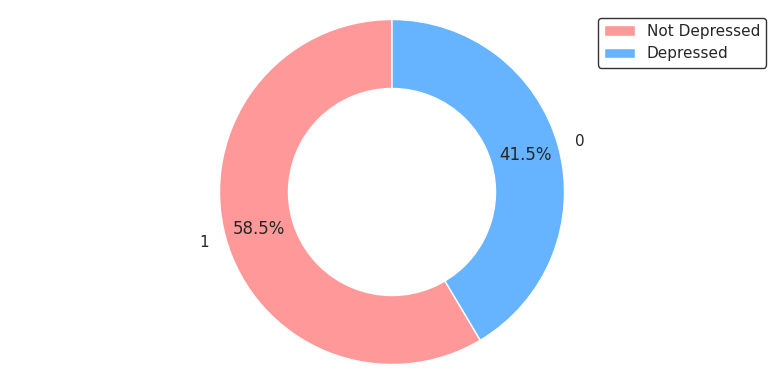

----------------------------------------------------------------------------------------------------


Column Datatype  Missing Value Count  % Missing  \
0              Gender   object                    0   0.000000   
1                 Age  float64                    0   0.000000   
2                City   object                    0   0.000000   
3              Status   object                    0   0.000000   
4       Acad_Pressure  float64                    9   0.032257   
5       Work_Pressure  float64                27898  99.989248   
6                CGPA  float64                    9   0.032257   
7           Study_Sat  float64                   10   0.035841   
8             Job_Sat  float64                27893  99.971327   
9      Sleep_Duration   object                    0   0.000000   
10        Diet_Habits   object                    0   0.000000   
11  Suicidal_Thoughts   object                    0   0.000000   
12   Work_Study_Hours  float64                    0   0.000000   
13         Fin_Stress  float64                    3   0.010752   
14  Family_History_MI   object                    0   0.000000   
15         Depression    int64                    0   0.000000   
16               Prof   object                    0   0.000000   
17           Ed_Level   object                    0   0.000000   
18           Ed_Field   object                    0   0.000000   
19             Region   object                    0   0.000000   

    Zero Value Count  % Zero            Min Value          Max Value  \
0                  0    0.00               Female               Male   
1                  0    0.00                 18.0               59.0   
2                  0    0.00              Unknown             Kalyan   
3                  0    0.00              Student            Student   
4                  0    0.00                  1.0                5.0   
5                  0    0.00                  2.0                5.0   
6                  0    0.00                 5.03               10.0   
7                  0    0.00                  1.0                5.0   
8                  0    0.00                  1.0                4.0   
9                  0    0.00            6-7 hours  Less than 5 hours   
10                 0    0.00              Unknown          Unhealthy   
11                 0    0.00                   No                Yes   
12              1700    6.09                  0.0               12.0   
13                 0    0.00                  1.0                5.0   
14                 0    0.00                  Yes                 No   
15             11565   41.45                  0.0                1.0   
16                 0    0.00       Civil Engineer            Unknown   
17                 0    0.00              Unknown           Bachelor   
18                 0    0.00  Business Management            Unknown   
19                 0    0.00              Unknown        North India   

    Unique Value Count  \
0                    2   
1                   34   
2                   31   
3                    1   
4                    5   
5                    2   
6                  331   
7                    5   
8                    4   
9                    6   
10                   4   
11                   2   
12                  13   
13                   5   
14                   2   
15                   2   
16                  15   
17                   5   
18                  11   
19                   6   

                                                                                                                                                                                                                                                                              Unique Values  
0                                                                                                                                                                                                                                                                            [Male, Female

In [36]:
# Plot distribution of Depression for working professional
print("Distribution of 'Depression' for Student")
plot_donut_chart(df_student, "Depression", colors=['#ff9999', '#66b3ff'], legend_labels=['Not Depressed', 'Depressed'])
print("----------"*10)
get_combined_stats(df_student)

**OBSERVATIONS for Student**
---
- The depression rate among students is 59%, which is much higher than the 8.2% observed in working professionals. The students' dataset is relatively balanced.
- Work_Pressure, Job_Sat have a significantly high percentage of missing values (~100%). They will be removed from the Student dataset.

In [37]:
# Drop Working Professional or Student since it has only one unique value.
# Drop Work_Pressure, Job_Sat since they are missing nearly all their values (>99%).

# Drop irrelevant columns in the Working Professional dataset
df_student = df_student.drop(columns=['Status', 'Work_Pressure', 'Job_Sat'])
get_combined_stats(df_student)

Column Datatype  Missing Value Count  % Missing  \
0              Gender   object                    0   0.000000   
1                 Age  float64                    0   0.000000   
2                City   object                    0   0.000000   
3       Acad_Pressure  float64                    9   0.032257   
4                CGPA  float64                    9   0.032257   
5           Study_Sat  float64                   10   0.035841   
6      Sleep_Duration   object                    0   0.000000   
7         Diet_Habits   object                    0   0.000000   
8   Suicidal_Thoughts   object                    0   0.000000   
9    Work_Study_Hours  float64                    0   0.000000   
10         Fin_Stress  float64                    3   0.010752   
11  Family_History_MI   object                    0   0.000000   
12         Depression    int64                    0   0.000000   
13               Prof   object                    0   0.000000   
14           Ed_Level   object                    0   0.000000   
15           Ed_Field   object                    0   0.000000   
16             Region   object                    0   0.000000   

    Zero Value Count  % Zero            Min Value          Max Value  \
0                  0    0.00               Female               Male   
1                  0    0.00                 18.0               59.0   
2                  0    0.00              Unknown             Kalyan   
3                  0    0.00                  1.0                5.0   
4                  0    0.00                 5.03               10.0   
5                  0    0.00                  1.0                5.0   
6                  0    0.00            6-7 hours  Less than 5 hours   
7                  0    0.00              Unknown          Unhealthy   
8                  0    0.00                   No                Yes   
9               1700    6.09                  0.0               12.0   
10                 0    0.00                  1.0                5.0   
11                 0    0.00                  Yes                 No   
12             11565   41.45                  0.0                1.0   
13                 0    0.00       Civil Engineer            Unknown   
14                 0    0.00              Unknown           Bachelor   
15                 0    0.00  Business Management            Unknown   
16                 0    0.00              Unknown        North India   

    Unique Value Count  \
0                    2   
1                   34   
2                   31   
3                    5   
4                  331   
5                    5   
6                    6   
7                    4   
8                    2   
9                   13   
10                   5   
11                   2   
12                   2   
13                  15   
14                   5   
15                  11   
16                   6   

                                                                                                                                                                                                                                                                              Unique Values  
0                                                                                                                                                                                                                                                                            [Male, Female]  
1                                                                              [33.0, 24.0, 31.0, 28.0, 25.0, 29.0, 30.0, 27.0, 19.0, 20.0, 23.0, 18.0, 21.0, 22.0, 34.0, 32.0, 26.0, 39.0, 35.0, 42.0, 36.0, 58.0, 49.0, 38.0, 51.0, 44.0, 43.0, 46.0, 59.0, 54.0, 48.0, 56.0, 37.0, 41.0]  
2   [Visakhapatnam, Bangalore, Srinagar, Varanasi, Jaipur, Pune, Thane, Chennai, Nagpur, Nashik, Vadodara, Kalyan, Rajkot, Ahmedabad, Kolkata, Mumbai, Lucknow, Indore, Surat, Ludhiana, Bhopal, Meerut, A

In [38]:
# Define function to generate countplot
def univariate_countplot(data, variable, hue=None):
    # Compute count and percent count
    variable_count = data[variable].value_counts().to_frame(
        "Count").reset_index()
    variable_percent = (data[variable].value_counts(
        normalize=True) * 100).round(2).reset_index()
    variable_percent.columns = ['index', 'Percent']
    variable_count = variable_count.rename(columns={'index': variable})
    variable_percent = variable_percent.rename(columns={'index': variable})
    variable_cnt = variable_count.merge(
        variable_percent, on=variable, how="left")
    variable_cnt.columns = [variable, "Count", "Percent"]
    col_count = variable_cnt.shape[1]
    row_count = len(variable_cnt)
    unique_values = data[variable].unique()
    if variable_cnt.shape[0] > 10:
        x = 14
        y = 18
        r = 90
    elif variable_cnt.shape[0] > 3:
        x = 10
        y = 10
        r = 0
    else:
        x = 8
        y = 8
        r = 0
    if len(variable_cnt) > 4:
        yscale = 1.01
    else:
        yscale = 1.03

    # Filter out categories with zero counts for the specified hue
    if hue is not None:
        filtered_data = data[data[variable].isin(data[variable].value_counts()[
                                                 data[variable].value_counts() > 0].index)]
    else:
        filtered_data = data

    # Plot countplot
    fig, ax = plt.subplots(2, 1, figsize=(x, y), gridspec_kw={"hspace": 0})

    if hue is not None:
        sns.countplot(data=filtered_data, x=variable, hue=hue,
                      edgecolor="black", linewidth=1, palette="Set2", ax=ax[0])
    else:
        sns.countplot(data=filtered_data, x=variable,
                      edgecolor="black", linewidth=1, palette="Set2", ax=ax[0])

    # Annotate bars with height greater than 0
    for p in ax[0].patches:
        if p.get_height() > 0:
            ax[0].annotate(f"{p.get_height()}", (p.get_x()+p.get_width()/2.,
                           p.get_height()), weight="bold", ha="center", va="bottom", fontsize=11)
    ax[0].set_title(
        f"Distribution by {variable}\n", fontsize=14, weight="bold")
    ax[0].set_xlabel(variable, fontsize=12, weight="bold")
    ax[0].tick_params(axis='x', rotation=r)
    ax[0].set_ylabel("Count", fontsize=12, weight="bold")
    ax[0].spines[["top", "right"]].set_visible(False)
    ax[0].spines[["left", "bottom"]].set_color("Black")
    ax[0].set_facecolor("white")

    # Create a table in subplot 2
    ax[1].axis("off")  # Turn off axis for the table subplot
    table_data = variable_cnt.rename(
        columns={"count": "Count", "variable_percent": "Percent (%)"})
    table = ax[1].table(cellText=table_data.values,
                        colLabels=table_data.columns, cellLoc="center", loc="center")

    # Table adjustments
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    for (row, col), cell in table.get_celld().items():
        if row == 0:
            cell.set_text_props(weight="bold", color="white",
                                wrap=True, ha="center", va="center")
            cell.set_facecolor("darkgreen")
        else:
            cell.set_text_props(weight="bold", ha="center", va="center")
    table.scale(1, 1.5)

    plt.axhline(y=0, color="black", linewidth=1, linestyle="--")
    if len(unique_values) > 1:
        for j in range(len(unique_values) - 1):
            ax[0].axvline(x=j + 0.5, color="grey", linewidth=0.8,
                          linestyle="--", zorder=5)

    plt.show()

In [39]:
def plot_column_distributions(df, top_n=10):
    """
    Plots distributions for all columns in the DataFrame, showing only the top N categories for high-cardinality columns.
    
    Parameters:
    - df: DataFrame containing the data.
    - top_n: Maximum number of unique values to display for high-cardinality columns.
    """
    # Set a white background style
    plt.style.use('default')
    
    num_cols = len(df.columns)
    fig, axes = plt.subplots(nrows=(num_cols // 3) + 1, ncols=3, figsize=(18, num_cols * 2))
    axes = axes.flatten()  

    for i, col in enumerate(df.columns):
        ax = axes[i]
        
        # Check if column is numerical or categorical
        if pd.api.types.is_numeric_dtype(df[col]):  # Numerical columns
            sns.histplot(df[col].dropna(), kde=True, ax=ax, bins=30)
            ax.set_title(f'{col}', fontweight='bold', fontsize=12)
            ax.set_xlabel(col, fontweight='bold', fontsize=10)
            ax.set_ylabel('Frequency', fontweight='bold', fontsize=10)
        else:  # Categorical columns
            # Handle high cardinality by displaying only top-N categories
            if df[col].nunique() > top_n:
                # Get top N values and group the rest as 'Other'
                top_values = df[col].value_counts().nlargest(top_n)
                data = df[col].apply(lambda x: x if x in top_values.index else 'Other')
            else:
                data = df[col]
            
            # Plot the data (only top-N or all if low cardinality)
            sns.countplot(y=data, order=data.value_counts().index, ax=ax)
            ax.set_title(f'{col}', fontweight='bold', fontsize=12)
            ax.set_xlabel('Count', fontweight='bold', fontsize=10)
            ax.set_ylabel('')

        # Customize axes: Show only bottom and left spines
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_color('black')
        ax.spines['left'].set_color('black')
        ax.tick_params(bottom=True, left=True, right=False, top=False) 

    # Remove any unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.subplots_adjust(hspace=1)
    plt.tight_layout()
    plt.show()

# plot_column_distributions(df_working, top_n=30)

In [40]:
def plot_bivariate_with_depression(df, depression_col='Depression', top_n=10):
    # Set a white background style
    plt.style.use('default')

    # Ensure the depression column exists
    if depression_col not in df.columns:
        raise ValueError(f"Column '{depression_col}' not found in the DataFrame.")

    num_cols = len(df.columns)
    fig, axes = plt.subplots(nrows=(num_cols // 3) + 1, ncols=3, figsize=(18, num_cols * 2))
    axes = axes.flatten()

    for i, col in enumerate(df.columns):
        if col == depression_col:
            continue  # Skip the depression column itself

        ax = axes[i]
        
        # Numerical Columns
        if pd.api.types.is_numeric_dtype(df[col]):
            sns.boxplot(data=df, x=depression_col, y=col, ax=ax)
            ax.set_title(f'{col} vs {depression_col}', fontweight='bold', fontsize=12)
            ax.set_xlabel(depression_col, fontweight='bold', fontsize=10)
            ax.set_ylabel(col, fontweight='bold', fontsize=10)

        # Categorical Columns
        else:
            # Handle high cardinality by displaying only top-N categories
            if df[col].nunique() > top_n:
                # Get top N values and group the rest as 'Other'
                top_values = df[col].value_counts().nlargest(top_n)
                data = df[col].apply(lambda x: x if x in top_values.index else 'Other')
            else:
                data = df[col]

            # Plot categorical relationships
            cross_tab = pd.crosstab(data, df[depression_col])
            cross_tab_norm = cross_tab.div(cross_tab.sum(axis=1), axis=0)  # Normalize for proportions
            cross_tab_norm.plot(kind='bar', stacked=True, ax=ax, legend=False)
            
            ax.set_title(f'{col} vs {depression_col}', fontweight='bold', fontsize=12)
            ax.set_xlabel(col, fontweight='bold', fontsize=10)
            ax.set_ylabel('Proportion', fontweight='bold', fontsize=10)

        # Customize axes: Show only bottom and left spines
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_color('black')
        ax.spines['left'].set_color('black')
        ax.tick_params(bottom=True, left=True, right=False, top=False)

    # Remove unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.subplots_adjust(hspace=1)
    plt.tight_layout()
    plt.show()

# plot_bivariate_with_depression(df_working, depression_col='Depression', top_n=30)

In [41]:
def plot_univariate_and_bivariate(df, depression_col='Depression', top_n=10):
    """
    Plots univariate column distributions and bivariate relationships with the Depression column side by side.
    
    Parameters:
    - df: DataFrame containing the data.
    - depression_col: The column to compare with (e.g., 'Depression').
    - top_n: Maximum number of unique values to display for high-cardinality columns.
    """
    # Ensure the depression column exists
    if depression_col not in df.columns:
        raise ValueError(f"Column '{depression_col}' not found in the DataFrame.")

    # Define a consistent color palette for Depression values
    color_palette = {0: '#1f77b4', 1: '#ff7f0e'}

    # Remove the depression column from the plotting loop
    cols_to_plot = [col for col in df.columns if col != depression_col]
    num_cols = len(cols_to_plot)
    
    # Set a white background style
    plt.style.use('default')

    # Create subplots: Two plots (univariate and bivariate) per column
    fig, axes = plt.subplots(nrows=num_cols, ncols=2, figsize=(12, num_cols * 6))
    axes = axes.reshape(-1, 2)  # Ensure consistent shape for 2 columns per row

    for i, col in enumerate(cols_to_plot):
        # Univariate Plot
        ax_univariate = axes[i, 0]
        if pd.api.types.is_numeric_dtype(df[col]):  # Numerical columns
            sns.histplot(df[col].dropna(), kde=True, ax=ax_univariate, bins=30)
            ax_univariate.set_title(f'Univariate: {col}', fontweight='bold', fontsize=12)
            ax_univariate.set_xlabel(col, fontweight='bold', fontsize=10)
        else:  # Categorical columns
            if df[col].nunique() > top_n:  # Handle high cardinality
                top_values = df[col].value_counts().nlargest(top_n)
                data = df[col].apply(lambda x: x if x in top_values.index else 'Other')
            else:
                data = df[col]
            sns.countplot(y=data, order=data.value_counts().index, ax=ax_univariate)
            ax_univariate.set_title(f'Univariate: {col}', fontweight='bold', fontsize=12)
            ax_univariate.set_xlabel('Count', fontweight='bold', fontsize=10)

        # Bivariate Plot
        ax_bivariate = axes[i, 1]
        if pd.api.types.is_numeric_dtype(df[col]):  # Numerical columns
            sns.boxplot(data=df, x=depression_col, y=col, ax=ax_bivariate, order=sorted(df[depression_col].unique()), width=0.6)
            for patch, category in zip(ax_bivariate.patches, sorted(df[depression_col].unique())):
                patch.set_facecolor(color_palette[category])
            ax_bivariate.set_title(f'Bivariate: {col} vs {depression_col}', fontweight='bold', fontsize=12)
            ax_bivariate.set_xlabel(depression_col, fontweight='bold', fontsize=10)
            ax_bivariate.set_ylabel(col, fontweight='bold', fontsize=10)
        else:  # Categorical columns
            if df[col].nunique() > top_n:  # Handle high cardinality
                top_values = df[col].value_counts().nlargest(top_n)
                data = df[col].apply(lambda x: x if x in top_values.index else 'Other')
            else:
                data = df[col]
            cross_tab = pd.crosstab(data, df[depression_col])
            cross_tab_norm = cross_tab.div(cross_tab.sum(axis=1), axis=0)  
            cross_tab_norm.plot(kind='bar', stacked=True, ax=ax_bivariate, color=[color_palette[cat] for cat in cross_tab.columns])
            ax_bivariate.set_title(f'Bivariate: {col} vs {depression_col}', fontweight='bold', fontsize=12)
            ax_bivariate.set_xlabel(col, fontweight='bold', fontsize=10)
            ax_bivariate.set_ylabel('Proportion', fontweight='bold', fontsize=10)

        # Customize axes: Show only bottom and left spines
        for ax in [ax_univariate, ax_bivariate]:
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.spines['bottom'].set_color('black')
            ax.spines['left'].set_color('black')
            ax.tick_params(bottom=True, left=True, right=False, top=False)

    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()


## **Univariate/ Bivariate Analysis**

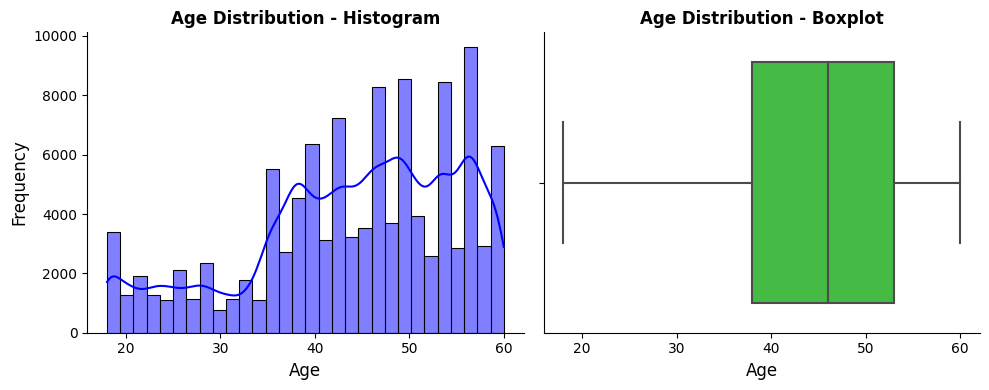

In [42]:
# Visualize Age column
plt.figure(figsize=(10, 4))
plt.style.use('default')

plt.subplot(1, 2, 1)
sns.histplot(df_working["Age"], bins=30, kde=True, color="blue")
plt.title("Age Distribution - Histogram", fontsize=12, fontweight="bold")
plt.xlabel("Age", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.gca().spines[['top', 'right']].set_visible(False)
plt.gca().spines[['bottom', 'left']].set_color('black')

# Boxplot
plt.subplot(1, 2, 2)
sns.boxplot(x=df_working["Age"], color="limegreen")
plt.title("Age Distribution - Boxplot", fontsize=12, fontweight="bold")
plt.xlabel("Age", fontsize=12)
plt.gca().spines[['top', 'right']].set_visible(False)
plt.gca().spines[['bottom', 'left']].set_color('black')

plt.tight_layout()
plt.show()

### **Analyzing Working Professional**

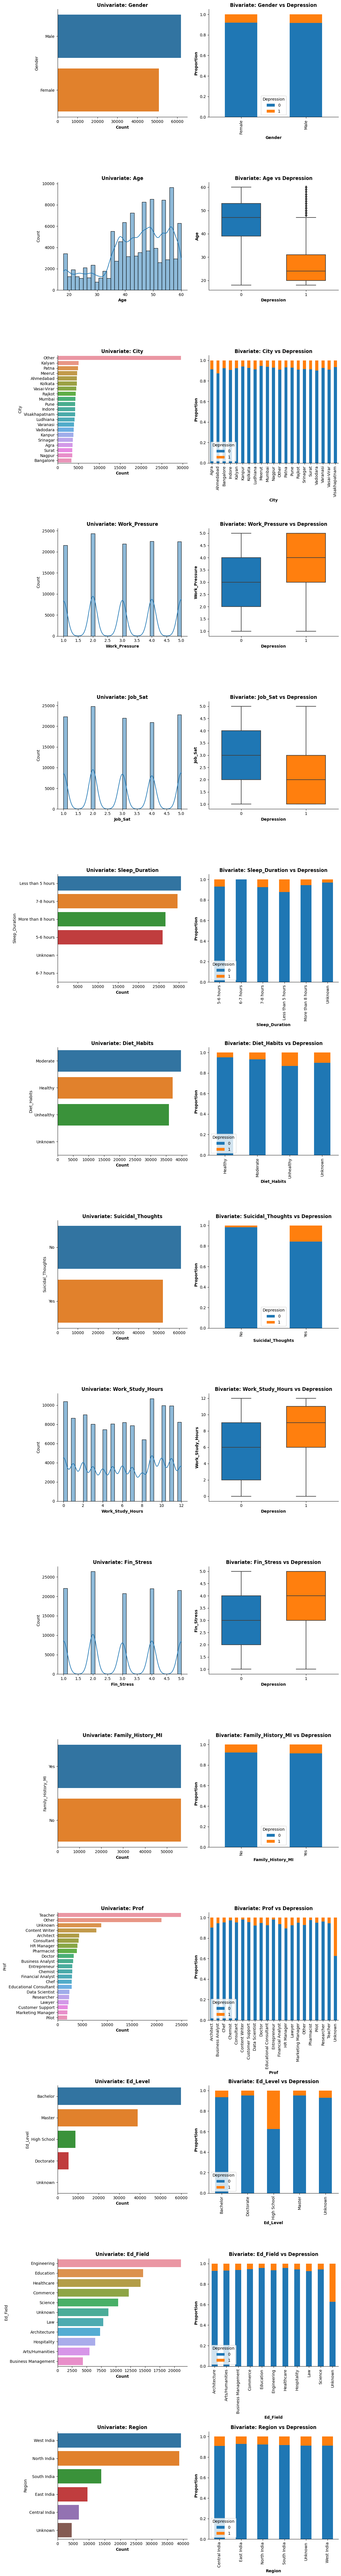

In [43]:
plot_univariate_and_bivariate(df_working, depression_col='Depression', top_n=20)

In [44]:
# Perform t-test to compare the means of the two groups
# Assuming depress_df and non_depress_df have been correctly defined as subsets of df_working
num_cols = df_working.select_dtypes(include=["int", "float"]).columns
depress_df = df_working[df_working["Depression"] == 1]
non_depress_df = df_working[df_working["Depression"] == 0]

# Perform t-test for each column and print the results
for col in num_cols:
    stat, p_value = ttest_ind(depress_df[col].dropna(), non_depress_df[col].dropna(), nan_policy='omit')
    print(f"T-test for {col}:")
    print(f"Statistic: {stat:.6f}, p-value: {p_value}")
    if p_value < 0.05:
        print(
            f"There is a significant difference in {col} between depressed and non-depressed individuals.\n")
    else:
        print(
            f"There is no significant difference in {col} between depressed and non-depressed individuals.\n")

T-test for Age:
Statistic: -179.298158, p-value: 0.0
There is a significant difference in Age between depressed and non-depressed individuals.

T-test for Work_Pressure:
Statistic: 74.511066, p-value: 0.0
There is a significant difference in Work_Pressure between depressed and non-depressed individuals.

T-test for Job_Sat:
Statistic: -57.416242, p-value: 0.0
There is a significant difference in Job_Sat between depressed and non-depressed individuals.

T-test for Work_Study_Hours:
Statistic: 47.661914, p-value: 0.0
There is a significant difference in Work_Study_Hours between depressed and non-depressed individuals.

T-test for Fin_Stress:
Statistic: 63.934197, p-value: 0.0
There is a significant difference in Fin_Stress between depressed and non-depressed individuals.

T-test for Depression:
Statistic: inf, p-value: 0.0
There is a significant difference in Depression between depressed and non-depressed individuals.



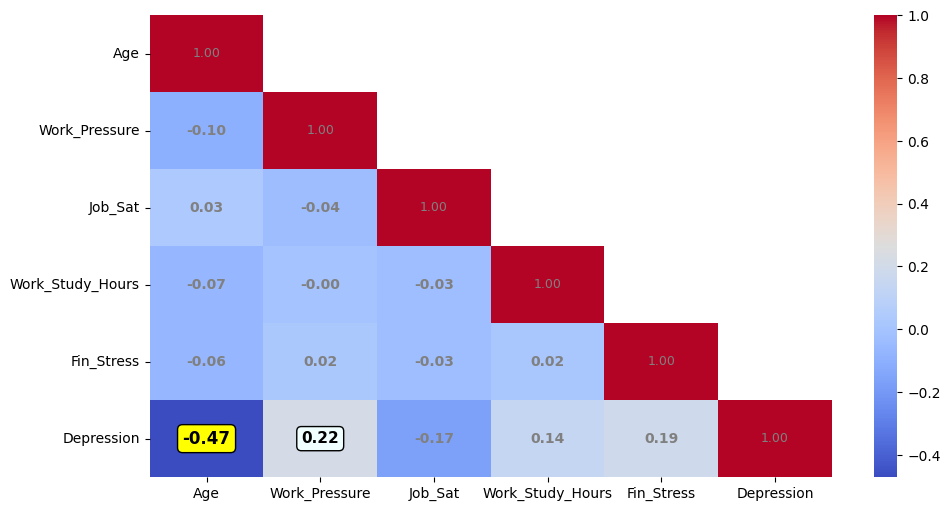

In [45]:
# Plot correlation heatmap
'''
Strength for correlation if range for abs(corr) between 2 independent variables is
- (0.7, 1.0) : Very Strong (Drop one of the variables)
- (0.4, 0.7) : Strong (Keep)
- (0.2, 0.4) : Moderate (Keep)
- (0.1, 0.2) : Weak (Keep)
- (0, 0.1) : Very Weak (Keep)
'''
plt.figure(figsize=(11, 6))
corr = df_working.dropna().corr(numeric_only=True)
mask = np.triu(np.ones_like(corr, dtype=bool), k=1)
sns.heatmap(corr, annot=False, cmap="coolwarm", mask=mask)

for i in range(len(corr.columns)):
    for j in range(i+1):
        value = corr.iloc[i, j]
        if abs(value) == 1:
            bbox_props = None
            text_color = 'grey'
            weight = 'normal'
            font_size = 9
        elif abs(value) >= 0.7:
            bbox_props = dict(boxstyle='round,pad=0.4',
                              facecolor='red', edgecolor='black')
            text_color = 'black'
            weight = 900
            font_size = 13
        elif abs(value) >= 0.4:
            bbox_props = dict(boxstyle='round,pad=0.3',
                              facecolor='yellow', edgecolor='black')
            text_color = 'black'
            weight = 800
            font_size = 12
        elif abs(value) >= 0.2:
            bbox_props = dict(boxstyle='round,pad=0.3',
                              facecolor='azure', edgecolor='black')
            text_color = 'black'
            weight = 700
            font_size = 11
        else:
            bbox_props = None
            text_color = 'grey'
            weight = 600
            font_size = 10

        plt.gca().text(j+0.5, i+0.5, f'{value:.2f}', ha='center', va='center',
                       color=text_color, fontsize=font_size, fontweight=weight, bbox=bbox_props)
plt.gca().grid(False)
plt.show()

In [46]:
# Perform chi2 test to check for association between variables and Cramer's V to review the strength of relationship between variables
'''
Strength for correlation if range for abs(corr) between 2 independent variables is
- (0.25, ) : Very Strong (Drop one of the variables)
- (0.15, 0.25) : Strong (Keep)
- (0.10, 0.15) : Moderate (Keep)
- (0.05, 0.10) : Weak (Keep)
- (0, 0.05) : Very Weak (Keep)

Strength for correlation if range for abs(corr) between an independent and a dependent variable is
- (0.25, ) : Very Strong (Keep)
- (0.15, 0.25) : Strong (Keep)
- (0.10, 0.15) : Moderate (Keep)
- (0.05, 0.10) : Weak (Keep)
- (0, 0.05) : Very Weak (Drop)
'''

# Function to calculate Cramer's V
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1)) / (n-1))
    rcorr = r - ((r-1)**2) / (n-1)
    kcorr = k - ((k-1)**2) / (n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))


# List of categorical variables
col_unique_cat = ['City', 'Prof', "Work_Pressure", "Job_Sat", "Diet_Habits", "Work_Study_Hours",  
                  "Fin_Stress", "Depression", "Ed_Level", "Ed_Field", "Region", "Gender",
                  "Suicidal_Thoughts", "Family_History_MI"]

results = []

# Loop through all unique pairs of categorical variables
for col1 in col_unique_cat:
    for col2 in col_unique_cat:
        if col1 != col2:
            # Chi2 Test
            confusion_matrix = pd.crosstab(df_working[col1], df_working[col2])
            chi2, p, _, _ = chi2_contingency(confusion_matrix)
            # Cramer's V
            v = cramers_v(df_working[col1], df_working[col2])
            results.append({"Variable 1": col1, "Variable 2": col2, "Chi2": chi2,
                           "P-value": p, "Association": "YES" if p < 0.05 else "NO", "Cramer's V": v})

# Create a DataFrame from the results list
results_df = pd.DataFrame(results)

# Define a function to apply styling based on association
def highlight_association(val):
    return "background-color: limegreen; font-weight: bold" if val == "YES" else ""

# Define a function to apply styling based on Cramer's V

def highlight_cramer(val):
    if val < 0.1:
        return "background-color: grey; font-weight: 500"
    elif val < 0.15:
        return "background-color: lightgray; font-weight: 600"
    elif val < 0.25:
        return "background-color: coral; font-weight: 700"
    else:
        return "background-color: yellow; font-weight: 800"

# Create a styler object and apply styles to specific columns
# chi2_results_df = results_df[(results_df["Association"]=="YES") & (results_df["Cramer's V"]>0.2)].style.apply(lambda x: [highlight_association(val) if x.name == "Association" else highlight_cramer(val) for val in x], axis=0, subset=["Association", "Cramer's V"])
chi2_results_df = results_df.style.apply(lambda x: [highlight_association(
    val) if x.name == "Association" else highlight_cramer(val) for val in x], axis=0, subset=["Association", "Cramer's V"])
chi2_results_df

**OBSERVATIONS for Working Professionals**
---
- **Gender**: Depression rates between males and females are relatively similar, suggesting little to no influence. $\Rightarrow$ **Drop**
- **Age**: Strong potential influence as younger individuals are more likely to experience depression. $\Rightarrow$ **Keep**
- **City**: Depression rates seem to be rather consistent across cities, indicating no significant influence. $\Rightarrow$ **Drop**
- **Work_Pressure**: Depression is associated with higher work pressure, suggesting a strong potential influence. $\Rightarrow$ **Keep**
- **Job_Sat**: Depression is associated with lower job satisfaction, suggesting a significant influence. $\Rightarrow$ **Keep**
- **Sleep_Duration**: Shorter sleep durations (less than 6 hours) are linked to higher depression count, suggesting a potential influence. $\Rightarrow$ **Keep**
- **Diet_Habits**: Unhealthy dietary habits display a higher association with depression, suggesting a potential influence. $\Rightarrow$ **Keep**
- **Suicidal_Thoughts**: Individuals with suicidal thoughts are significantly more likely to experience depression, indicating a very strong influence. $\Rightarrow$ **Keep**
- **Work_Study_Hours**: Depression is associated with longer work hours, suggesting a strong potential influence. $\Rightarrow$ **Keep**
- **Fin_Stress**: Depression is associated with higher higher financial stress, suggesting a strong potential influence. $\Rightarrow$ **Keep**
- **Family_History_MI**: Depression rates seems to be quite similar, potentially suggesting little to no influence. $\Rightarrow$ **Drop**
- **Prof**: Depression rates vary significantly across professions, suggesting a potential influence. $\Rightarrow$ **Keep**
- **Ed_Level**: Individuals with lower education levels (e.g., high school) have higher depression prevalence, indicating a moderate influence. $\Rightarrow$ **Keep**
- **Ed_Field**: Depression rates have some variations across professions, suggesting a potential influence.. $\Rightarrow$ **Keep**
- **Region**: The depression rates across regions are relatively similar, suggesting little to no influence. $\Rightarrow$ **Drop**

### **Analyzing Student**

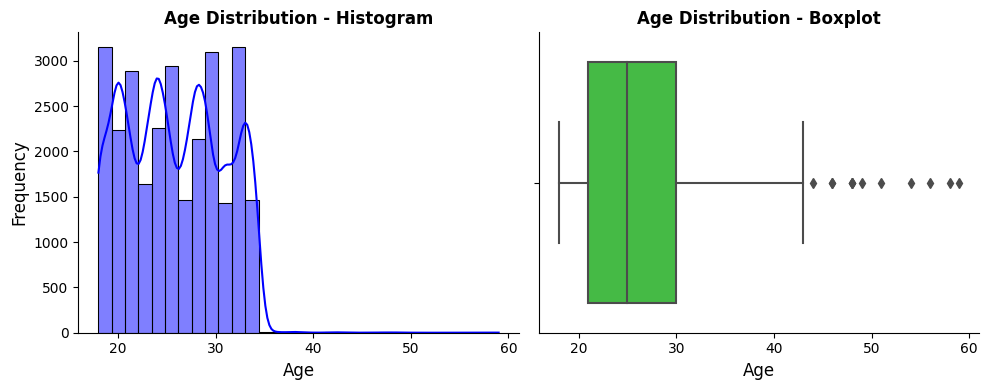

In [47]:
# Visualize Age column
plt.figure(figsize=(10, 4))
plt.style.use('default')

plt.subplot(1, 2, 1)
sns.histplot(df_student["Age"], bins=30, kde=True, color="blue")
plt.title("Age Distribution - Histogram", fontsize=12, fontweight="bold")
plt.xlabel("Age", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.gca().spines[['top', 'right']].set_visible(False)
plt.gca().spines[['bottom', 'left']].set_color('black')

# Boxplot
plt.subplot(1, 2, 2)
sns.boxplot(x=df_student["Age"], color="limegreen")
plt.title("Age Distribution - Boxplot", fontsize=12, fontweight="bold")
plt.xlabel("Age", fontsize=12)
plt.gca().spines[['top', 'right']].set_visible(False)
plt.gca().spines[['bottom', 'left']].set_color('black')

plt.tight_layout()
plt.show()

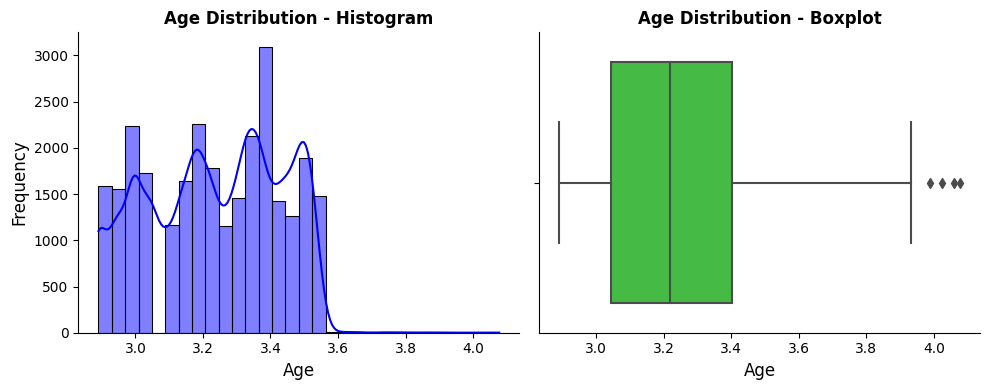

In [48]:
# Perform log transformation on Age
df_student["Age"] = np.log(df_student["Age"])

# Visualize Age column
plt.figure(figsize=(10, 4))
plt.style.use('default')

plt.subplot(1, 2, 1)
sns.histplot(df_student["Age"], bins=30, kde=True, color="blue")
plt.title("Age Distribution - Histogram", fontsize=12, fontweight="bold")
plt.xlabel("Age", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.gca().spines[['top', 'right']].set_visible(False)
plt.gca().spines[['bottom', 'left']].set_color('black')

# Boxplot
plt.subplot(1, 2, 2)
sns.boxplot(x=df_student["Age"], color="limegreen")
plt.title("Age Distribution - Boxplot", fontsize=12, fontweight="bold")
plt.xlabel("Age", fontsize=12)
plt.gca().spines[['top', 'right']].set_visible(False)
plt.gca().spines[['bottom', 'left']].set_color('black')

plt.tight_layout()
plt.show()

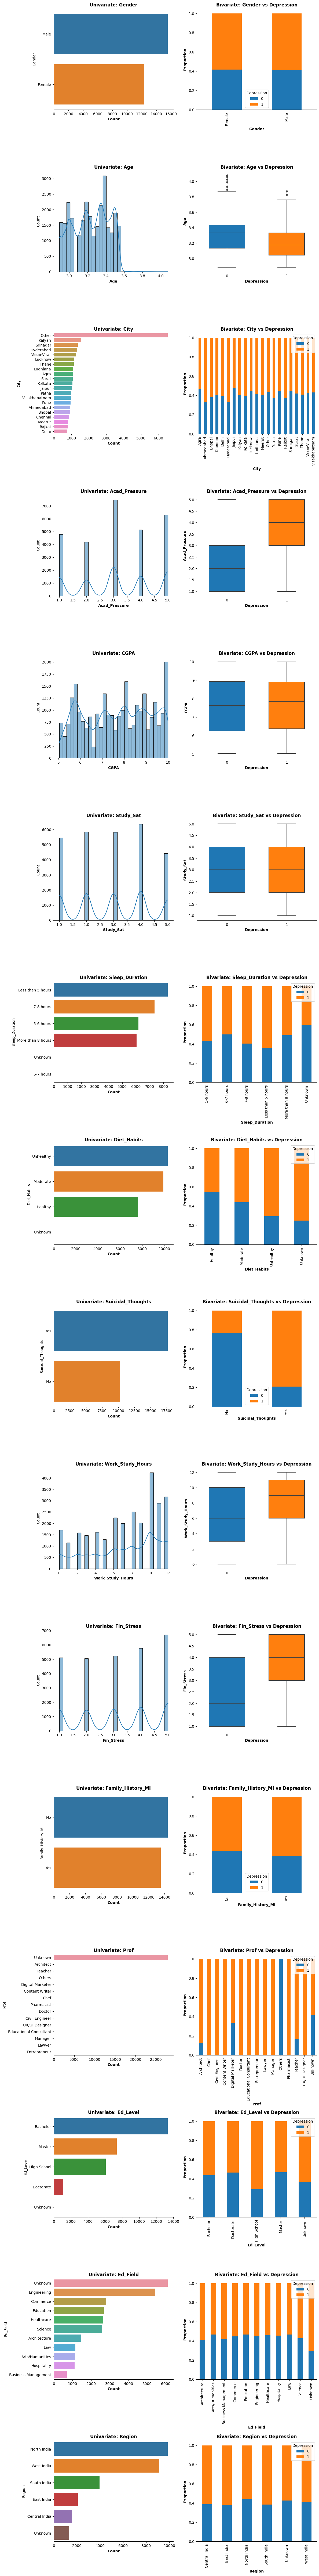

In [49]:
plot_univariate_and_bivariate(df_student, depression_col='Depression', top_n=20)

In [50]:
# Perform t-test to compare the means of the two groups
# Assuming depress_df and non_depress_df have been correctly defined as subsets of df_student
num_cols = df_student.select_dtypes(include=["int", "float"]).columns
depress_df = df_student[df_student["Depression"] == 1]
non_depress_df = df_student[df_student["Depression"] == 0]

# Perform t-test for each column and print the results
for col in num_cols:
    stat, p_value = ttest_ind(depress_df[col].dropna(), non_depress_df[col].dropna(), nan_policy='omit')
    print(f"T-test for {col}:")
    print(f"Statistic: {stat:.6f}, p-value: {p_value}")
    if p_value < 0.05:
        print(
            f"There is a significant difference in {col} between depressed and non-depressed individuals.\n")
    else:
        print(
            f"There is no significant difference in {col} between depressed and non-depressed individuals.\n")

T-test for Age:
Statistic: -37.942703, p-value: 3.283584265916277e-307
There is a significant difference in Age between depressed and non-depressed individuals.

T-test for Acad_Pressure:
Statistic: 90.170983, p-value: 0.0
There is a significant difference in Acad_Pressure between depressed and non-depressed individuals.

T-test for CGPA:
Statistic: 3.646379, p-value: 0.00026644485129975943
There is a significant difference in CGPA between depressed and non-depressed individuals.

T-test for Study_Sat:
Statistic: -28.481324, p-value: 6.598070912619113e-176
There is a significant difference in Study_Sat between depressed and non-depressed individuals.

T-test for Work_Study_Hours:
Statistic: 35.619547, p-value: 8.598086391535004e-272
There is a significant difference in Work_Study_Hours between depressed and non-depressed individuals.

T-test for Fin_Stress:
Statistic: 65.189022, p-value: 0.0
There is a significant difference in Fin_Stress between depressed and non-depressed individuals

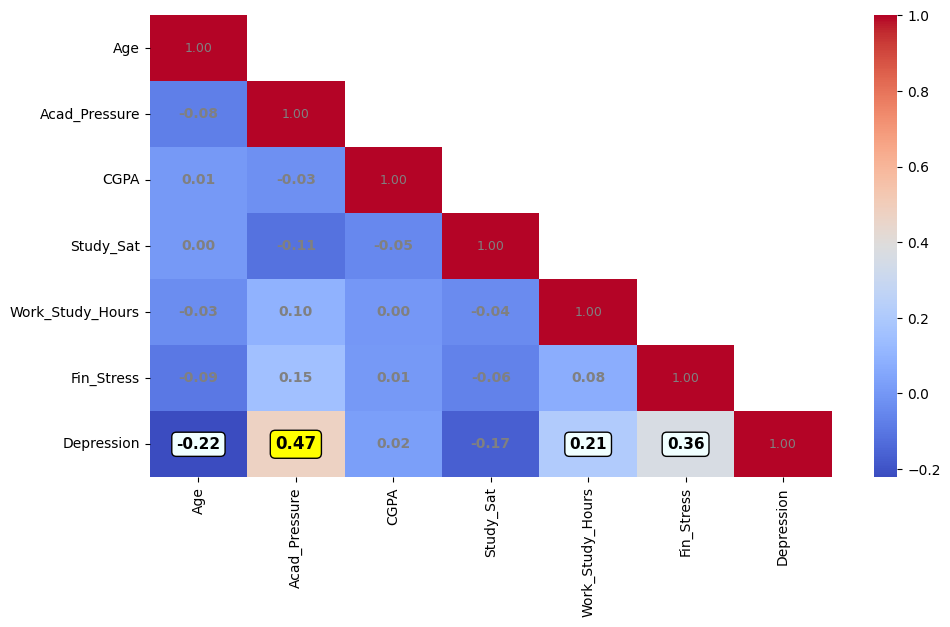

In [51]:
# Plot correlation heatmap
'''
Strength for correlation if range for abs(corr) between 2 independent variables is
- (0.7, 1.0) : Very Strong (Drop one of the variables)
- (0.4, 0.7) : Strong (Keep)
- (0.2, 0.4) : Moderate (Keep)
- (0.1, 0.2) : Weak (Keep)
- (0, 0.1) : Very Weak (Keep)
'''
plt.figure(figsize=(11, 6))
corr = df_student.dropna().corr(numeric_only=True)
mask = np.triu(np.ones_like(corr, dtype=bool), k=1)
sns.heatmap(corr, annot=False, cmap="coolwarm", mask=mask)

for i in range(len(corr.columns)):
    for j in range(i+1):
        value = corr.iloc[i, j]
        if abs(value) == 1:
            bbox_props = None
            text_color = 'grey'
            weight = 'normal'
            font_size = 9
        elif abs(value) >= 0.7:
            bbox_props = dict(boxstyle='round,pad=0.4',
                              facecolor='red', edgecolor='black')
            text_color = 'black'
            weight = 900
            font_size = 13
        elif abs(value) >= 0.4:
            bbox_props = dict(boxstyle='round,pad=0.3',
                              facecolor='yellow', edgecolor='black')
            text_color = 'black'
            weight = 800
            font_size = 12
        elif abs(value) >= 0.2:
            bbox_props = dict(boxstyle='round,pad=0.3',
                              facecolor='azure', edgecolor='black')
            text_color = 'black'
            weight = 700
            font_size = 11
        else:
            bbox_props = None
            text_color = 'grey'
            weight = 600
            font_size = 10

        plt.gca().text(j+0.5, i+0.5, f'{value:.2f}', ha='center', va='center',
                       color=text_color, fontsize=font_size, fontweight=weight, bbox=bbox_props)
plt.gca().grid(False)
plt.show()

In [52]:
# Perform chi2 test to check for association between variables and Cramer's V to review the strength of relationship between variables
'''
Strength for correlation if range for abs(corr) between 2 independent variables is
- (0.25, ) : Very Strong (Drop one of the variables)
- (0.15, 0.25) : Strong (Keep)
- (0.10, 0.15) : Moderate (Keep)
- (0.05, 0.10) : Weak (Keep)
- (0, 0.05) : Very Weak (Keep)

Strength for correlation if range for abs(corr) between an independent and a dependent variable is
- (0.25, ) : Very Strong (Keep)
- (0.15, 0.25) : Strong (Keep)
- (0.10, 0.15) : Moderate (Keep)
- (0.05, 0.10) : Weak (Keep)
- (0, 0.05) : Very Weak (Drop)
'''

# Function to calculate Cramer's V
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1)) / (n-1))
    rcorr = r - ((r-1)**2) / (n-1)
    kcorr = k - ((k-1)**2) / (n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))


# List of categorical variables
col_unique_cat = ['City', 'Prof', "Acad_Pressure", "Study_Sat", "CGPA", "Diet_Habits", "Work_Study_Hours",  
                  "Fin_Stress", "Depression", "Ed_Level", "Ed_Field", "Region", "Gender",
                  "Suicidal_Thoughts", "Family_History_MI"]

results = []

# Loop through all unique pairs of categorical variables
for col1 in col_unique_cat:
    for col2 in col_unique_cat:
        if col1 != col2:
            # Chi2 Test
            confusion_matrix = pd.crosstab(df_student[col1], df_student[col2])
            chi2, p, _, _ = chi2_contingency(confusion_matrix)
            # Cramer's V
            v = cramers_v(df_student[col1], df_student[col2])
            results.append({"Variable 1": col1, "Variable 2": col2, "Chi2": chi2,
                           "P-value": p, "Association": "YES" if p < 0.05 else "NO", "Cramer's V": v})

# Create a DataFrame from the results list
results_df = pd.DataFrame(results)

# Define a function to apply styling based on association
def highlight_association(val):
    return "background-color: limegreen; font-weight: bold" if val == "YES" else ""

# Define a function to apply styling based on Cramer's V

def highlight_cramer(val):
    if val < 0.1:
        return "background-color: grey; font-weight: 500"
    elif val < 0.15:
        return "background-color: lightgray; font-weight: 600"
    elif val < 0.25:
        return "background-color: coral; font-weight: 700"
    else:
        return "background-color: yellow; font-weight: 800"

# Create a styler object and apply styles to specific columns
# chi2_results_df = results_df[(results_df["Association"]=="YES") & (results_df["Cramer's V"]>0.2)].style.apply(lambda x: [highlight_association(val) if x.name == "Association" else highlight_cramer(val) for val in x], axis=0, subset=["Association", "Cramer's V"])
chi2_results_df = results_df.style.apply(lambda x: [highlight_association(
    val) if x.name == "Association" else highlight_cramer(val) for val in x], axis=0, subset=["Association", "Cramer's V"])
chi2_results_df

**OBSERVATIONS for Students**
---
- **Gender**: Similar to Working Professional, depression rates between males and females are relatively similar, suggesting little to no influence. $\Rightarrow$ **Drop**
- **Age**: Potential influence as younger individuals are more likely to experience depression. $\Rightarrow$ **Keep**
- **City**: Depression rates seem to be rather consistent across cities, indicating little association/ no significant influence. $\Rightarrow$ **Drop**
- **Acad_Pressure**: Depression is associated with higher academic pressure, suggesting a strong potential influence. $\Rightarrow$ **Keep**
- **Study_Sat**: Study Satisfaction seems to influence depression. $\Rightarrow$ **Keep**
- **Sleep_Duration**: Shorter sleep durations (less than 6 hours) are linked to higher depression count, suggesting a potential influence. $\Rightarrow$ **Keep**
- **Diet_Habits**: Unhealthy dietary habits display a higher association with depression, suggesting a potential influence. $\Rightarrow$ **Keep**
- **Suicidal_Thoughts**: Individuals with suicidal thoughts are significantly more likely to experience depression, indicating a very strong influence. $\Rightarrow$ **Keep**
- **Work_Study_Hours**: Depression is associated with longer study hours, suggesting a strong potential influence. $\Rightarrow$ **Keep**
- **Fin_Stress**: Depression is associated with higher higher financial stress, suggesting a strong potential influence. $\Rightarrow$ **Keep**
- **Family_History_MI**: Depression rates seems to be quite similar, potentially suggesting little to no influence. $\Rightarrow$ **Drop**
- **Prof**: Depression rates have low associations with professions. $\Rightarrow$ **Drop**
- **Ed_Level**: Individuals in lower education levels (e.g., high school) have higher depression prevalence, indicating a moderate influence. $\Rightarrow$ **Keep**
- **Ed_Field**: Depression rates have some variations across disciplines, suggesting a potential influence.. $\Rightarrow$ **Keep**
- **Region**: The depression rates across regions are relatively similar, suggesting little to no influence. $\Rightarrow$ **Drop**

## **Data Preparation**

In [53]:
# Create a copy
df_working_copy = df_working.copy()
df_student_copy = df_student.copy()

In [54]:
# Drop columns for respective dataset
df_working = df_working.drop(columns=['Gender', 'City', 'Family_History_MI', 'Region'])
df_student = df_student.drop(columns=['Gender', 'City', 'Family_History_MI', 'Prof', 'Region'])

print(f"Columns in final Working Professional dataset: {df_working.columns.tolist()}\n")
print(f"Columns in final Student dataset: {df_student.columns.tolist()}")

Columns in final Working Professional dataset: ['Age', 'Work_Pressure', 'Job_Sat', 'Sleep_Duration', 'Diet_Habits', 'Suicidal_Thoughts', 'Work_Study_Hours', 'Fin_Stress', 'Depression', 'Prof', 'Ed_Level', 'Ed_Field']

Columns in final Student dataset: ['Age', 'Acad_Pressure', 'CGPA', 'Study_Sat', 'Sleep_Duration', 'Diet_Habits', 'Suicidal_Thoughts', 'Work_Study_Hours', 'Fin_Stress', 'Depression', 'Ed_Level', 'Ed_Field']


In [55]:
# Impute missing values
work_pressure_mode_work = df_working['Work_Pressure'].mode()[0]
fin_stress_mode_work = df_working['Fin_Stress'].mode()[0]
job_sat_mode_work = df_working['Job_Sat'].mode()[0]

df_working['Work_Pressure'].fillna(work_pressure_mode_work, inplace=True)
df_working['Fin_Stress'].fillna(fin_stress_mode_work, inplace=True)
df_working['Job_Sat'].fillna(job_sat_mode_work, inplace=True)

acad_pressure_mode_student = df_student['Acad_Pressure'].mode()[0]
fin_stress_mode_student  = df_student['Fin_Stress'].mode()[0]
study_sat_mode_student  = df_student['Study_Sat'].mode()[0]
cgpa_median_student = df_student['CGPA'].median()

df_student['Acad_Pressure'].fillna(acad_pressure_mode_student, inplace=True)
df_student['CGPA'].fillna(cgpa_median_student, inplace=True)
df_student['Study_Sat'].fillna(study_sat_mode_student, inplace=True)
df_student['Fin_Stress'].fillna(fin_stress_mode_student, inplace=True)

In [56]:
missing_metrics = {
    'Work_Pressure_mode_work': df_working['Work_Pressure'].mode()[0],
    'Fin_Stress_mode_work': df_working['Fin_Stress'].mode()[0],
    'Job_Sat_mode_work': df_working['Job_Sat'].mode()[0],
    'Acad_Pressure_mode_student': df_student['Acad_Pressure'].mode()[0],
    'CGPA_median_student': df_student['CGPA'].median(),
    'Study_Sat_mode_student': df_student['Study_Sat'].mode()[0],
    'Fin_Stress_mode_student': df_student['Fin_Stress'].mode()[0],
}
missing_metrics

{'Work_Pressure_mode_work': 2.0,
 'Fin_Stress_mode_work': 2.0,
 'Job_Sat_mode_work': 2.0,
 'Acad_Pressure_mode_student': 3.0,
 'CGPA_median_student': 7.77,
 'Study_Sat_mode_student': 4.0,
 'Fin_Stress_mode_student': 5.0}

In [57]:
# Label encode ordinal columns
# Define a mapping for Sleep_Duration, Diet_Habits and Ed_Level
sleep_mapping = {
    "Less than 5 hours": 0,
    "5-6 hours": 1,
    "6-7 hours": 2,
    "7-8 hours": 3,
    "More than 8 hours": 4,
    "Unknown": -1 
}

diet_mapping = {
    "Unhealthy": 0,
    "Moderate": 1,
    "Healthy": 2,
    "Unknown": -1 
}

education_mapping = {
    "High School": 0,
    "Bachelor": 1,
    "Master": 2,
    "Doctorate": 3,
    "Unknown": -1
}

# Apply manual label encoding to Sleep_Duration
df_working['Sleep_Duration'] = df_working['Sleep_Duration'].map(sleep_mapping)
df_student['Sleep_Duration'] = df_student['Sleep_Duration'].map(sleep_mapping)

# Apply manual label encoding to Diet_Habits
df_working['Diet_Habits'] = df_working['Diet_Habits'].map(diet_mapping)
df_student['Diet_Habits'] = df_student['Diet_Habits'].map(diet_mapping)

# Apply manual label encoding to Ed_Level
df_working['Ed_Level'] = df_working['Ed_Level'].map(education_mapping)
df_student['Ed_Level'] = df_student['Ed_Level'].map(education_mapping)

In [58]:
# Perform One-Hot Encoding
work_columns_to_encode = ['Prof', 'Ed_Field', 'Suicidal_Thoughts']
study_columns_to_encode = ['Ed_Field', 'Suicidal_Thoughts']

# One-Hot Encoding with drop_first=True
df_work = pd.get_dummies(df_working, columns=work_columns_to_encode, drop_first=True, dtype=int)
print("Working Professional:\n")
display(df_work.head())

df_study = pd.get_dummies(df_student, columns=study_columns_to_encode, drop_first=True, dtype=int)
print("\nStudents:\n")
display(df_study.head())

# Replace whitespace to "-" for column name 
df_work.columns = df_work.columns.str.replace(r"\s+", "_", regex=True)
df_study.columns = df_study.columns.str.replace(r"\s+", "_", regex=True)

Working Professional:



Age  Work_Pressure  Job_Sat  Sleep_Duration  Diet_Habits  \
0  49.0            5.0      2.0               4            2   
1  26.0            4.0      3.0               0            0   
3  22.0            5.0      1.0               0            1   
4  30.0            1.0      1.0               1            0   
5  59.0            2.0      5.0               1            2   

   Work_Study_Hours  Fin_Stress  Depression  Ed_Level  Prof_Architect  \
0               1.0         2.0           0         1               0   
1               7.0         3.0           1         1               0   
3              10.0         1.0           1         1               0   
4               9.0         4.0           0         1               0   
5               7.0         5.0           0         2               0   

   Prof_Business Analyst  Prof_Chef  Prof_Chemist  Prof_Civil Engineer  \
0                      0          1             0                    0   
1                      0          0             0                    0   
3                      0          0             0                    0   
4                      1          0             0                    0   
5                      0          0             0                    0   

   Prof_Consultant  Prof_Content Writer  Prof_Customer Support  \
0                0                    0                      0   
1                0                    0                      0   
3                0                    0                      0   
4                0                    0                      0   
5                0                    0                      0   

   Prof_Data Scientist  Prof_Digital Marketer  Prof_Doctor  \
0                    0                      0            0   
1                    0                      0            0   
3                    0                      0            0   
4                    0                      0            0   
5                    0                      0            0   

   Prof_Educational Consultant  Prof_Electrician  Prof_Entrepreneur  \
0                            0                 0                  0   
1                            0                 0                  0   
3                            0                 0                  0   
4                            0                 0                  0   
5                            0                 0                  0   

   Prof_Financial Analyst  Prof_Graphic Designer  Prof_HR Manager  \
0                       0                      0                0   
1                       0                      0                0   
3                       0                      0                0   
4                       0                      0                0   
5                       1                      0                0   

   Prof_Investment Banker  Prof_Judge  Prof_Lawyer  Prof_Manager  \
0                       0           0            0             0   
1                       0           0            0             0   
3                       0           0            0             0   
4                       0           0            0             0   
5                       0           0            0             0   

   Prof_Marketing Manager  Prof_Mechanical Engineer  Prof_Others  \
0                       0                         0            0   
1                       0                         0            0   
3                       0                         0            0   
4                       0                         0            0   
5                       0                         0            0   

   Prof_Pharmacist  Prof_Pilot  Prof_Plumber  Prof_Research Analyst  \
0                0           0             0                      0   
1                0           0             0                      0   
3                0           0             0                      0   
4                0   


Students:



Age  Acad_Pressure  CGPA  Study_Sat  Sleep_Duration  Diet_Habits  \
2   3.496508            5.0  8.97        2.0               1            2   
8   3.178054            2.0  5.90        5.0               1            1   
26  3.433987            3.0  7.03        5.0               0            2   
30  3.332205            3.0  5.59        2.0               3            1   
32  3.218876            4.0  8.13        3.0               1            1   

    Work_Study_Hours  Fin_Stress  Depression  Ed_Level  \
2                3.0         1.0           1         1   
8                3.0         2.0           0         1   
26               9.0         1.0           0         1   
30               4.0         5.0           1         1   
32               1.0         1.0           0         2   

    Ed_Field_Arts/Humanities  Ed_Field_Business Management  Ed_Field_Commerce  \
2                          0                             0                  0   
8                          0                             0                  0   
26                         1                             0                  0   
30                         0                             0                  0   
32                         0                             0                  0   

    Ed_Field_Education  Ed_Field_Engineering  Ed_Field_Healthcare  \
2                    0                     0                    1   
8                    0                     0                    0   
26                   0                     0                    0   
30                   0                     1                    0   
32                   0                     1                    0   

    Ed_Field_Hospitality  Ed_Field_Law  Ed_Field_Science  Ed_Field_Unknown  \
2                      0             0                 0                 0   
8                      0             0                 1                 0   
26                     0             0                 0                 0   
30                     0             0                 0                 0   
32                     0             0                 0                 0   

    Suicidal_Thoughts_Yes  
2                       1  
8                       0  
26                      0  
30                      1  
32                      1

Working Professional Train dataset


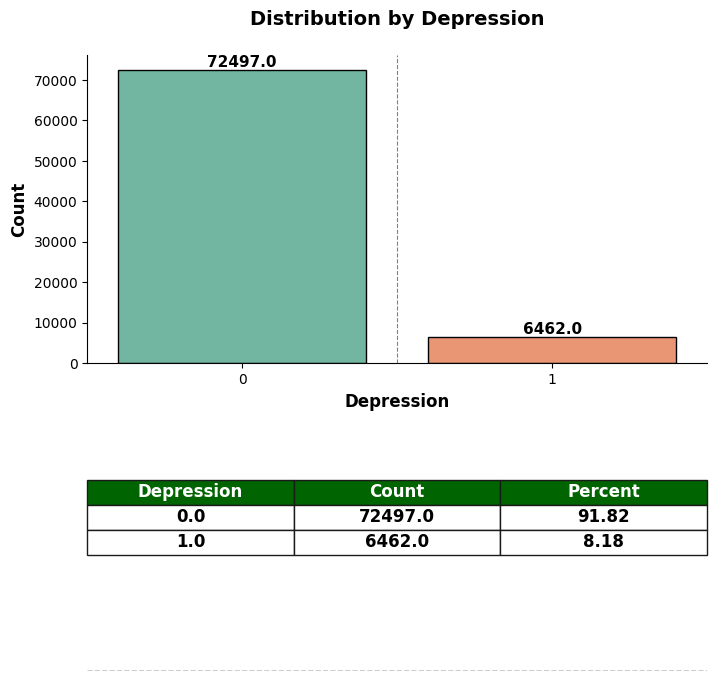

Working Professional Test dataset


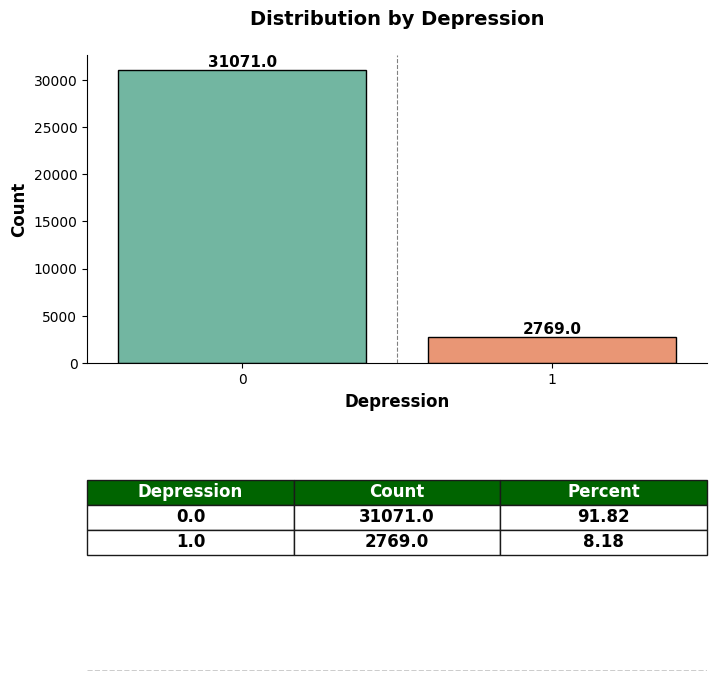

In [59]:
from sklearn.model_selection import train_test_split

# Split dataset into X and y
Xw = df_work.drop(["Depression"], axis=1)
yw = df_work["Depression"]

# Split the dataset into train (70%) and test (30%) sets
X_wtrain, X_wtest, y_wtrain, y_wtest = train_test_split(Xw, yw, test_size=0.30, random_state=42, stratify=yw)

# View distribution
print("Working Professional Train dataset")
univariate_countplot(y_wtrain.to_frame(), "Depression")

print("Working Professional Test dataset")
univariate_countplot(y_wtest.to_frame(), "Depression")

In [60]:
# Perform scaling after train-test split to prevent data leakage
columns_to_scale = ["Age", "Work_Study_Hours"]
scaler_work = StandardScaler()
scaler_work.fit(X_wtrain[columns_to_scale])

# Fit and transform only the selected columns
X_wtrain[columns_to_scale] = scaler_work.transform(X_wtrain[columns_to_scale])
X_wtest[columns_to_scale] = scaler_work.transform(X_wtest[columns_to_scale])

# Display results
print("X_wtrain (Scaled Columns)")
display(X_wtrain.head())
print("----------" * 10)
print("X_wtest (Scaled Columns)")
display(X_wtest.head())

X_wtrain (Scaled Columns)


Age  Work_Pressure  Job_Sat  Sleep_Duration  Diet_Habits  \
15576  -0.636993            3.0      3.0               3            2   
124729  0.093391            3.0      4.0               4            2   
3531   -1.641271            4.0      1.0               4            2   
137756  1.188966            3.0      5.0               0            1   
4518    1.280264            1.0      3.0               1            1   

        Work_Study_Hours  Fin_Stress  Ed_Level  Prof_Architect  \
15576           1.028352         1.0         1               0   
124729          1.028352         2.0         1               0   
3531           -0.527785         1.0         1               0   
137756          0.768996         2.0         1               0   
4518           -1.046497         2.0         2               0   

        Prof_Business_Analyst  Prof_Chef  Prof_Chemist  Prof_Civil_Engineer  \
15576                       0          0             0                    0   
124729                      0          0             0                    0   
3531                        0          0             0                    0   
137756                      0          0             0                    0   
4518                        0          0             0                    0   

        Prof_Consultant  Prof_Content_Writer  Prof_Customer_Support  \
15576                 0                    0                      0   
124729                0                    0                      0   
3531                  0                    0                      0   
137756                0                    1                      0   
4518                  0                    0                      0   

        Prof_Data_Scientist  Prof_Digital_Marketer  Prof_Doctor  \
15576                     0                      0            0   
124729                    0                      0            0   
3531                      0                      0            0   
137756                    0                      0            0   
4518                      0                      0            0   

        Prof_Educational_Consultant  Prof_Electrician  Prof_Entrepreneur  \
15576                             0                 0                  0   
124729                            0                 0                  0   
3531                              0                 0                  0   
137756                            0                 0                  0   
4518                              0                 0                  0   

        Prof_Financial_Analyst  Prof_Graphic_Designer  Prof_HR_Manager  \
15576                        0                      0                0   
124729                       0                      0                0   
3531                         0                      1                0   
137756                       0                      0                0   
4518                         0                      0                1   

        Prof_Investment_Banker  Prof_Judge  Prof_Lawyer  Prof_Manager  \
15576                        0           0            0             1   
124729                       0           0            0             0   
3531                         0           0            0             0   
137756                       0           0            0             0   
4518                         0           0            0             0   

        Prof_Marketing_Manager  Prof_Mechanical_Engineer  Prof_Others  \
15576                        0                         0            0   
124729                       0                         0            0   
3531                         0                         0            0   
137756                       0                         0            0   
4518                         0                         0            0   

        Prof_Pharmacist  Prof_Pilot  Prof_Plumber  Prof_Research_Analyst  \
15576           

----------------------------------------------------------------------------------------------------
X_wtest (Scaled Columns)


Age  Work_Pressure  Job_Sat  Sleep_Duration  Diet_Habits  \
109734 -0.728291            1.0      1.0               0            1   
123539 -0.819589            2.0      3.0               3            0   
44216  -0.636993            1.0      2.0               3            1   
53151   0.367285            1.0      5.0               0            0   
107226  1.371562            1.0      2.0               0            0   

        Work_Study_Hours  Fin_Stress  Ed_Level  Prof_Architect  \
109734          1.547064         2.0         1               0   
123539          1.287708         3.0         2               0   
44216          -0.009072         2.0         1               1   
53151           1.028352         2.0         3               0   
107226          1.028352         4.0         1               0   

        Prof_Business_Analyst  Prof_Chef  Prof_Chemist  Prof_Civil_Engineer  \
109734                      0          0             0                    0   
123539                      0          0             0                    0   
44216                       0          0             0                    0   
53151                       0          0             0                    0   
107226                      0          0             0                    0   

        Prof_Consultant  Prof_Content_Writer  Prof_Customer_Support  \
109734                0                    0                      0   
123539                0                    0                      0   
44216                 0                    0                      0   
53151                 0                    0                      0   
107226                0                    0                      0   

        Prof_Data_Scientist  Prof_Digital_Marketer  Prof_Doctor  \
109734                    0                      0            0   
123539                    0                      0            0   
44216                     0                      0            0   
53151                     0                      0            1   
107226                    0                      0            0   

        Prof_Educational_Consultant  Prof_Electrician  Prof_Entrepreneur  \
109734                            0                 0                  0   
123539                            0                 0                  0   
44216                             0                 0                  0   
53151                             0                 0                  0   
107226                            0                 0                  0   

        Prof_Financial_Analyst  Prof_Graphic_Designer  Prof_HR_Manager  \
109734                       0                      0                0   
123539                       0                      0                0   
44216                        0                      0                0   
53151                        0                      0                0   
107226                       0                      0                0   

        Prof_Investment_Banker  Prof_Judge  Prof_Lawyer  Prof_Manager  \
109734                       0           0            0             0   
123539                       0           0            0             0   
44216                        0           0            0             0   
53151                        0           0            0             0   
107226                       0           0            0             0   

        Prof_Marketing_Manager  Prof_Mechanical_Engineer  Prof_Others  \
109734                       0                         0            0   
123539                       1                         0            0   
44216                        0                         0            0   
53151                        0                         0            0   
107226                       0                         0            0   

        Prof_Pharmacist  Prof_Pilot  Prof_Plumber  Prof_Research_Analyst  \
109734          

Student Train dataset


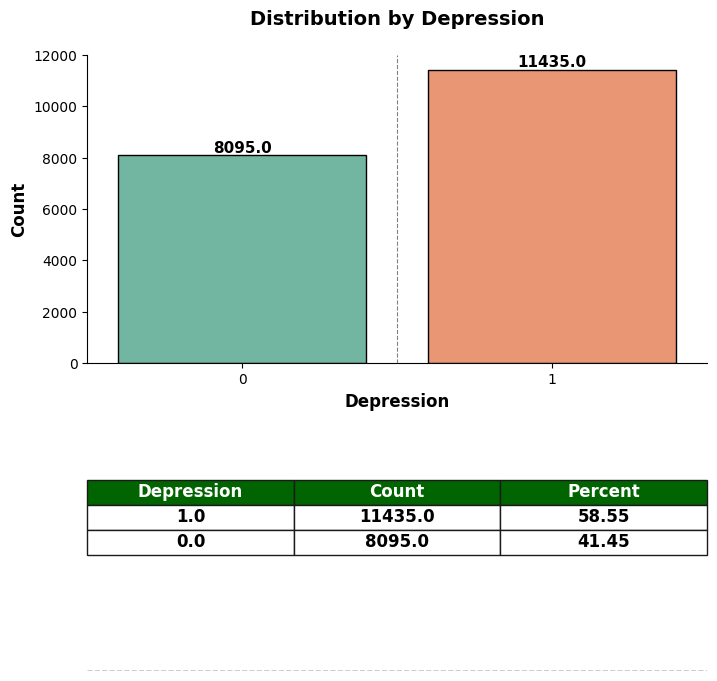

Student Test dataset


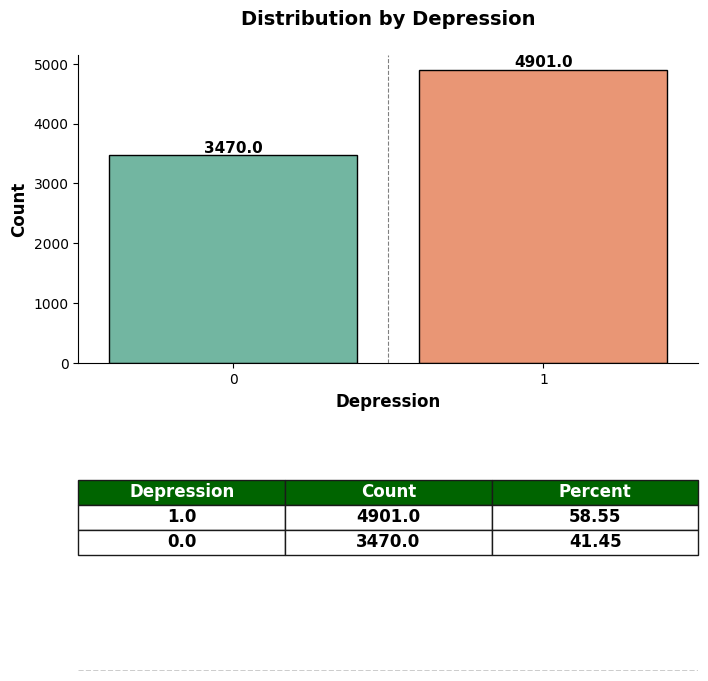

In [61]:
# Split Student dataset into X and y
Xs = df_study.drop(["Depression"], axis=1)
ys = df_study["Depression"]

# Split the dataset into train (70%) and test (30%) sets
X_strain, X_stest, y_strain, y_stest = train_test_split(Xs, ys, test_size=0.30, random_state=42, stratify=ys)

# View distribution
print("Student Train dataset")
univariate_countplot(y_strain.to_frame(), "Depression")

print("Student Test dataset")
univariate_countplot(y_stest.to_frame(), "Depression")

In [62]:
# Perform scaling after train-test split to prevent data leakage
columns_to_scale = ["Age", "CGPA", "Work_Study_Hours"]
scaler_student = StandardScaler()
scaler_student.fit(X_strain[columns_to_scale])

# Fit and transform only the selected columns
X_strain[columns_to_scale] = scaler_student.transform(X_strain[columns_to_scale])
X_stest[columns_to_scale] = scaler_student.transform(X_stest[columns_to_scale])

# Display results
print("X_strain (Scaled Columns)")
display(X_strain.head())
print("----------" * 10)
print("X_stest (Scaled Columns)")
display(X_stest.head())

X_strain (Scaled Columns)


Age  Acad_Pressure      CGPA  Study_Sat  Sleep_Duration  \
19527  0.128432            4.0  0.256762        1.0               0   
23990 -0.286499            3.0  1.514545        2.0               0   
46607  0.512599            3.0  0.571208        4.0               1   
52244  0.324073            5.0 -1.315465        1.0               4   
38789 -0.737556            5.0  0.878818        5.0               0   

       Diet_Habits  Work_Study_Hours  Fin_Stress  Ed_Level  \
19527            1          0.766131         2.0         2   
23990            0          0.226863         2.0         1   
46607            1          0.766131         5.0         1   
52244            2          1.305400         4.0         2   
38789            1          1.305400         5.0         2   

       Ed_Field_Arts/Humanities  Ed_Field_Business_Management  \
19527                         0                             0   
23990                         0                             0   
46607                         0                             0   
52244                         0                             0   
38789                         0                             0   

       Ed_Field_Commerce  Ed_Field_Education  Ed_Field_Engineering  \
19527                  0                   0                     0   
23990                  0                   1                     0   
46607                  1                   0                     0   
52244                  0                   0                     0   
38789                  0                   0                     0   

       Ed_Field_Healthcare  Ed_Field_Hospitality  Ed_Field_Law  \
19527                    0                     0             1   
23990                    0                     0             0   
46607                    0                     0             0   
52244                    0                     0             0   
38789                    0                     0             0   

       Ed_Field_Science  Ed_Field_Unknown  Suicidal_Thoughts_Yes  
19527                 0                 0                      1  
23990                 0                 0                      0  
46607                 0                 0                      1  
52244                 1                 0                      1  
38789                 1                 0                      0

----------------------------------------------------------------------------------------------------
X_stest (Scaled Columns)


Age  Acad_Pressure      CGPA  Study_Sat  Sleep_Duration  \
110533  0.870249            5.0 -0.638724        5.0               4   
86825   1.519080            3.0 -1.636747        4.0               4   
49981   0.512599            4.0 -1.643582        2.0               0   
112659 -1.231632            3.0 -0.884812        1.0               1   
133422 -0.737556            4.0 -1.199257        1.0               0   

        Diet_Habits  Work_Study_Hours  Fin_Stress  Ed_Level  \
110533            2          0.496497         2.0         1   
86825             0          1.305400         2.0         1   
49981             0         -0.851674         2.0         2   
112659            0          0.496497         5.0         0   
133422            2         -0.042771         1.0         2   

        Ed_Field_Arts/Humanities  Ed_Field_Business_Management  \
110533                         1                             0   
86825                          0                             0   
49981                          0                             0   
112659                         0                             0   
133422                         0                             0   

        Ed_Field_Commerce  Ed_Field_Education  Ed_Field_Engineering  \
110533                  0                   0                     0   
86825                   0                   0                     1   
49981                   0                   0                     1   
112659                  0                   0                     0   
133422                  1                   0                     0   

        Ed_Field_Healthcare  Ed_Field_Hospitality  Ed_Field_Law  \
110533                    0                     0             0   
86825                     0                     0             0   
49981                     0                     0             0   
112659                    0                     0             0   
133422                    0                     0             0   

        Ed_Field_Science  Ed_Field_Unknown  Suicidal_Thoughts_Yes  
110533                 0                 0                      1  
86825                  0                 0                      1  
49981                  0                 0                      0  
112659                 0                 1                      1  
133422                 0                 0                      0

Working Professional Train dataset


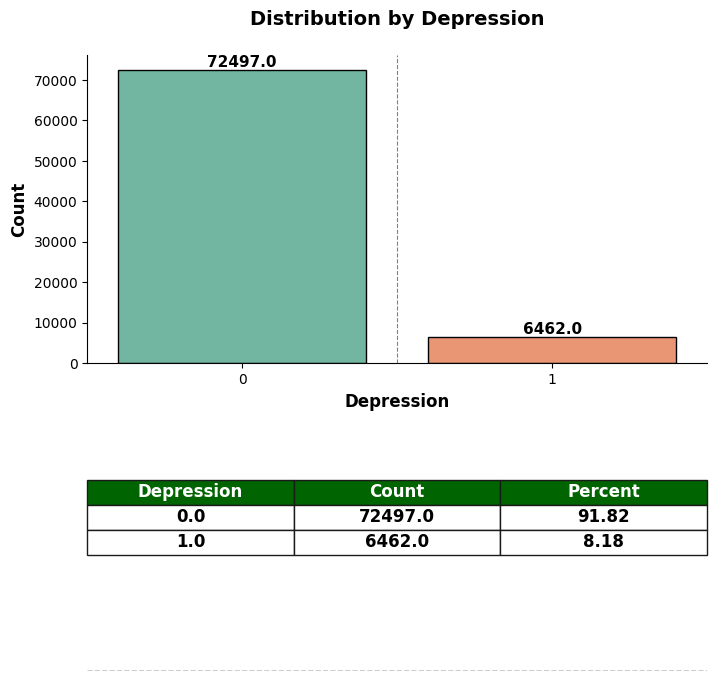

Working Professional Test dataset


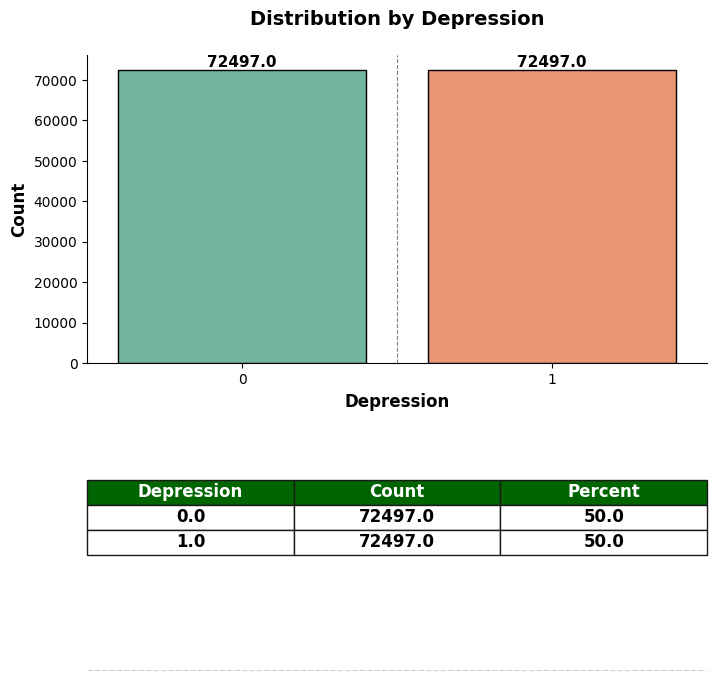

In [63]:
# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_wtrain_smote, y_wtrain_smote = smote.fit_resample(X_wtrain, y_wtrain)

# Check class distribution after oversampling
# View distribution
print("Working Professional Train dataset")
univariate_countplot(y_wtrain.to_frame(), "Depression")

print("Working Professional Test dataset")
univariate_countplot(y_wtrain_smote.to_frame(), "Depression")

## **Model Building**

In [64]:
import itertools
from matplotlib.cbook import boxplot_stats
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, RidgeClassifier, Perceptron, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, ExtraTreesClassifier, AdaBoostClassifier, BaggingClassifier, RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, fowlkes_mallows_score, matthews_corrcoef, roc_auc_score, roc_curve, precision_recall_curve, make_scorer, classification_report

In [65]:
def model_cross_validation_perf(clfs, X, y):
    print(f"\nCross-Validation Performance:\n")
    results = []
    names = []

    for name, clf in clfs:
        # Preprocess data only for logistic regression models
        if isinstance(clf, (LogisticRegression, LogisticRegressionCV)):
            X_preprocessed = sm.add_constant(X, has_constant="add")
        else:
            X_preprocessed = X

        # Stratified K-Fold cross-validation
        kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
        
        try:
            # Perform cross-validation
            cv_scores = cross_val_score(
                estimator=clf, X=X_preprocessed, y=y, scoring="accuracy", cv=kfold
            )
            results.append(cv_scores)
            names.append(name)
            print(f"{name}: Mean Score = {cv_scores.mean():.4f}, Std Dev = {cv_scores.std():.4f}")
        except ValueError as e:
            print(f"Error for classifier {name}: {e}")
    
    # Compile results
    cv_results = pd.DataFrame({
        "Classifier": names,
        "Mean Score": [np.mean(result) for result in results],
        "Std Deviation": [np.std(result) for result in results]
    })
    
    # Highlight best and worst classifiers
    styled_results = (cv_results.style
                      .highlight_max(subset=["Mean Score"], props="background-color: lightgreen; font-weight: bold")
                      .highlight_min(subset=["Mean Score"], props="background-color: lightcoral; font-weight: bold")
                      .highlight_max(subset=["Std Deviation"], props="background-color: lightcoral; font-weight: bold")
                      .highlight_min(subset=["Std Deviation"], props="background-color: lightgreen; font-weight: bold"))
    
    display(styled_results)
    return results, names

In [66]:
# Define a function to generate boxplots to compare models" performance
def boxplot_cv(results, names):
    fig, ax = plt.subplots(figsize=(24, 8))

    bp = ax.boxplot(results, patch_artist=True, widths=0.5,
                    meanline=True, showmeans=True)

    for patch in bp["boxes"]:
        patch.set_facecolor("skyblue")
        patch.set_edgecolor("black")

    for median in bp["medians"]:
        median.set_color("black")
        median.set_linewidth(2)

    for whisker in bp["whiskers"]:
        whisker.set_color("black")
        whisker.set_linewidth(2)

    for cap in bp["caps"]:
        cap.set_color("black")
        cap.set_linewidth(2)

    # Add mean lines for each boxplot
    for i, line in enumerate(bp['means']):
        x, y = line.get_xydata()[1]
        plt.text(x+0.01, y, f'{np.mean(results[i]):.2f}',
                 verticalalignment='center', color='navy', fontsize=14, fontweight=700)

    ax.set_title("Classifier Comparison", fontsize=18, fontweight=700)
    ax.set_xlabel("\nAlgorithm", fontsize=14)
    ax.set_ylabel("Score\n", fontsize=14)
    ax.yaxis.grid(True, linestyle="-", linewidth=0.5)
    ax.set_xticklabels(names, rotation=90)
    ax.set_facecolor("white")
    ax.spines[["top", "right"]].set_visible(False)
    ax.spines[["left", "bottom"]].set_color("black")

    plt.show()

In [67]:
def find_optimal_threshold(clf, X_test, y_test, metric="accuracy", step=0.01):
    """
    Finds the optimal threshold for a classifier based on a specified metric.
    """
    try:
        y_probs = clf.predict_proba(X_test)[:, 1]
    except AttributeError:
        raise AttributeError(f"The classifier '{clf}' does not support `predict_proba`.")

    thresholds = np.arange(0, 1 + step, step)
    scores = []

    for threshold in thresholds:
        y_pred = (y_probs >= threshold).astype(int)
        if metric == "accuracy":
            scores.append(accuracy_score(y_test, y_pred))
        elif metric == "f1":
            scores.append(f1_score(y_test, y_pred, zero_division=0))
        else:
            raise ValueError(f"Unsupported metric '{metric}' for threshold optimization.")

    optimal_idx = np.argmax(scores)
    optimal_threshold = thresholds[optimal_idx]
    return optimal_threshold


In [68]:
def get_metrics_scores(clf, X, y, threshold):
    """
    Compute evaluation metrics for a classifier at a specific threshold.
    """
    try:
        y_probs = clf.predict_proba(X)[:, 1]
    except AttributeError:
        raise AttributeError(f"The classifier '{clf}' does not support `predict_proba`.")

    y_pred = (y_probs >= threshold).astype(int)

    metrics = {
        "Threshold": threshold,
        "Accuracy": accuracy_score(y, y_pred),
        "Precision": precision_score(y, y_pred, zero_division=0),
        "Recall": recall_score(y, y_pred, zero_division=0),
        "F1": f1_score(y, y_pred, zero_division=0),
        "ROC AUC": roc_auc_score(y, y_probs),
        "MCC": matthews_corrcoef(y, y_pred),
        "FMI": fowlkes_mallows_score(y, y_pred)
    }
    return metrics

In [69]:
def model_perf(clfs, Xfit, yfit, X, y, threshold_optimization="accuracy"):
    """
    Evaluate classifiers with dynamic thresholds and return/display results after each algorithm.
    """
    all_results = {}

    for name, clf in clfs:
        print(f"\nRunning evaluation for classifier: {name}")

        # Fit the classifier
        try:
            clf.fit(Xfit, yfit)
        except Exception as e:
            print(f"Error fitting classifier '{name}': {e}")
            continue

        # Find optimal threshold based on the specified optimization criterion
        try:
            optimal_threshold = find_optimal_threshold(clf, X, y, metric=threshold_optimization)
        except Exception as e:
            print(f"Error finding optimal threshold for '{name}': {e}")
            continue

        # Collect metrics
        try:
            train_metrics = get_metrics_scores(clf, Xfit, yfit, threshold=optimal_threshold)
            train_metrics["Dataset"] = "Train"
            test_metrics = get_metrics_scores(clf, X, y, threshold=optimal_threshold)
            test_metrics["Dataset"] = "Test"
        except Exception as e:
            print(f"Error calculating metrics for '{name}': {e}")
            continue

        # Combine results
        combined_metrics = pd.DataFrame([train_metrics, test_metrics])
        combined_metrics.insert(0, "Classifier", name)

        # Display results for this classifier
        display(combined_metrics)

        # Store results
        all_results[name] = {
            "optimal_threshold": optimal_threshold,
            "metrics": combined_metrics
        }

    return all_results

In [70]:
# Define class imbalance ratio 
positive_class_count = y_wtrain.sum()
negative_class_count = len(y_wtrain) - positive_class_count
imbalance_ratio = negative_class_count / positive_class_count
print(f"Imbalanced ratio: {imbalance_ratio}")

Imbalanced ratio: 11.2189724543485


In [71]:
# Define classifiers
classifiers = [
    # Linear Models
    ("Logistic Regression (newton-cg)", LogisticRegression(solver="newton-cg", class_weight="balanced", random_state=42)),
    ("Logistic Regression (liblinear)", LogisticRegression(solver="liblinear", class_weight="balanced", random_state=42)),
    ("Logistic Regression (sag)", LogisticRegression(solver="sag", class_weight="balanced", random_state=42)),
    ("Logistic Regression (saga)", LogisticRegression(solver="saga", class_weight="balanced", random_state=42)),
    ("Logistic Regression (lbfgs)", LogisticRegression(solver="lbfgs", class_weight="balanced", random_state=42)),
    ("Ridge Classifier", RidgeClassifier(class_weight="balanced", random_state=42)),
    ("Perceptron", Perceptron(class_weight="balanced", random_state=42)),
    ("SGD Classifier", SGDClassifier(class_weight="balanced", random_state=42)),

    # Tree-Based Models
    ("Decision Trees", DecisionTreeClassifier(class_weight="balanced", random_state=42)),
    ("Random forest", RandomForestClassifier(class_weight="balanced", random_state=42)),
    ("Extra Trees", ExtraTreesClassifier(class_weight="balanced", random_state=42)),

    # Boosting Methods
    ("Adaboost", AdaBoostClassifier(random_state=42)),
    ("GBM", GradientBoostingClassifier(random_state=42)),
    ("XGboost", XGBClassifier(scale_pos_weight=imbalance_ratio, random_state=42, eval_metric="logloss")),
    ("CatBoost", CatBoostClassifier(auto_class_weights="Balanced", silent=True, random_state=42)),
    ("LightGBM", LGBMClassifier(class_weight="balanced", verbosity=0, random_state=42)),

    # Support Vector Machines
    ("Linear SVC", LinearSVC(random_state=42, class_weight="balanced", max_iter=10000)),

    # Nearest Neighbor Models
    ("K-Nearest Neighbors", KNeighborsClassifier()),  

    # Naive Bayes Models
    ("Gaussian Naive Bayes", GaussianNB()),  
    ("Bernoulli Naive Bayes", BernoulliNB()),

    # Bagging and Voting Models
    ("Bagging Classifier", BaggingClassifier(random_state=42)),
    ("Voting Classifier", VotingClassifier(estimators=[
        ("Random forest", RandomForestClassifier(class_weight="balanced", random_state=42)),
        ("GBM", GradientBoostingClassifier(random_state=42)),
        ("Logistic Regression", LogisticRegression(class_weight="balanced", random_state=42)),
        ("K-Nearest Neighbors", KNeighborsClassifier()),
    ], voting="soft"))
]

In [72]:
# Define classifiers
classifiers2 = [
    # Linear Models
    ("Logistic Regression (newton-cg)", LogisticRegression(solver="newton-cg", random_state=42)),
    ("Logistic Regression (liblinear)", LogisticRegression(solver="liblinear", random_state=42)),
    ("Logistic Regression (sag)", LogisticRegression(solver="sag", random_state=42)),
    ("Logistic Regression (saga)", LogisticRegression(solver="saga", random_state=42)),
    ("Logistic Regression (lbfgs)", LogisticRegression(solver="lbfgs", random_state=42)),
    ("Ridge Classifier", RidgeClassifier(random_state=42)),
    ("Perceptron", Perceptron(random_state=42)),
    ("SGD Classifier", SGDClassifier(random_state=42)),

    # Tree-Based Models
    ("Decision Trees", DecisionTreeClassifier(random_state=42)),
    ("Random forest", RandomForestClassifier(random_state=42)),
    ("Extra Trees", ExtraTreesClassifier(random_state=42)),

    # Boosting Methods
    ("Adaboost", AdaBoostClassifier(random_state=42)),
    ("GBM", GradientBoostingClassifier(random_state=42)),
    ("XGboost", XGBClassifier(random_state=42, eval_metric="logloss")),
    ("CatBoost", CatBoostClassifier(silent=True, random_state=42)),
    ("LightGBM", LGBMClassifier(verbosity=0, random_state=42)),

    # Support Vector Machines
    ("Linear SVC", LinearSVC(random_state=42, max_iter=10000)),

    # Nearest Neighbor Models
    ("K-Nearest Neighbors", KNeighborsClassifier()),  

    # Naive Bayes Models
    ("Gaussian Naive Bayes", GaussianNB()),  
    ("Bernoulli Naive Bayes", BernoulliNB()),

    # Bagging and Voting Models
    ("Bagging Classifier", BaggingClassifier(random_state=42)),
    ("Voting Classifier", VotingClassifier(estimators=[
        ("Random forest", RandomForestClassifier(random_state=42)),
        ("GBM", GradientBoostingClassifier(random_state=42)),
        ("Logistic Regression", LogisticRegression(random_state=42)),
        ("K-Nearest Neighbors", KNeighborsClassifier()),
    ], voting="soft"))
]

### **Cross Validation**

#### **Working Professional**


Cross-Validation Performance:

Logistic Regression (newton-cg): Mean Score = 0.9129, Std Dev = 0.0011
Logistic Regression (liblinear): Mean Score = 0.9128, Std Dev = 0.0012
Logistic Regression (sag): Mean Score = 0.9128, Std Dev = 0.0012
Logistic Regression (saga): Mean Score = 0.9128, Std Dev = 0.0011
Logistic Regression (lbfgs): Mean Score = 0.9128, Std Dev = 0.0012
Ridge Classifier: Mean Score = 0.9053, Std Dev = 0.0016
Perceptron: Mean Score = 0.9214, Std Dev = 0.0367
SGD Classifier: Mean Score = 0.9152, Std Dev = 0.0102
Decision Trees: Mean Score = 0.9379, Std Dev = 0.0010
Random forest: Mean Score = 0.9589, Std Dev = 0.0005
Extra Trees: Mean Score = 0.9571, Std Dev = 0.0003
Adaboost: Mean Score = 0.9607, Std Dev = 0.0002
GBM: Mean Score = 0.9608, Std Dev = 0.0003
XGboost: Mean Score = 0.9364, Std Dev = 0.0016
CatBoost: Mean Score = 0.9357, Std Dev = 0.0009
LightGBM: Mean Score = 0.9250, Std Dev = 0.0012
Linear SVC: Mean Score = 0.9125, Std Dev = 0.0016
K-Nearest Neighbors: Mean 

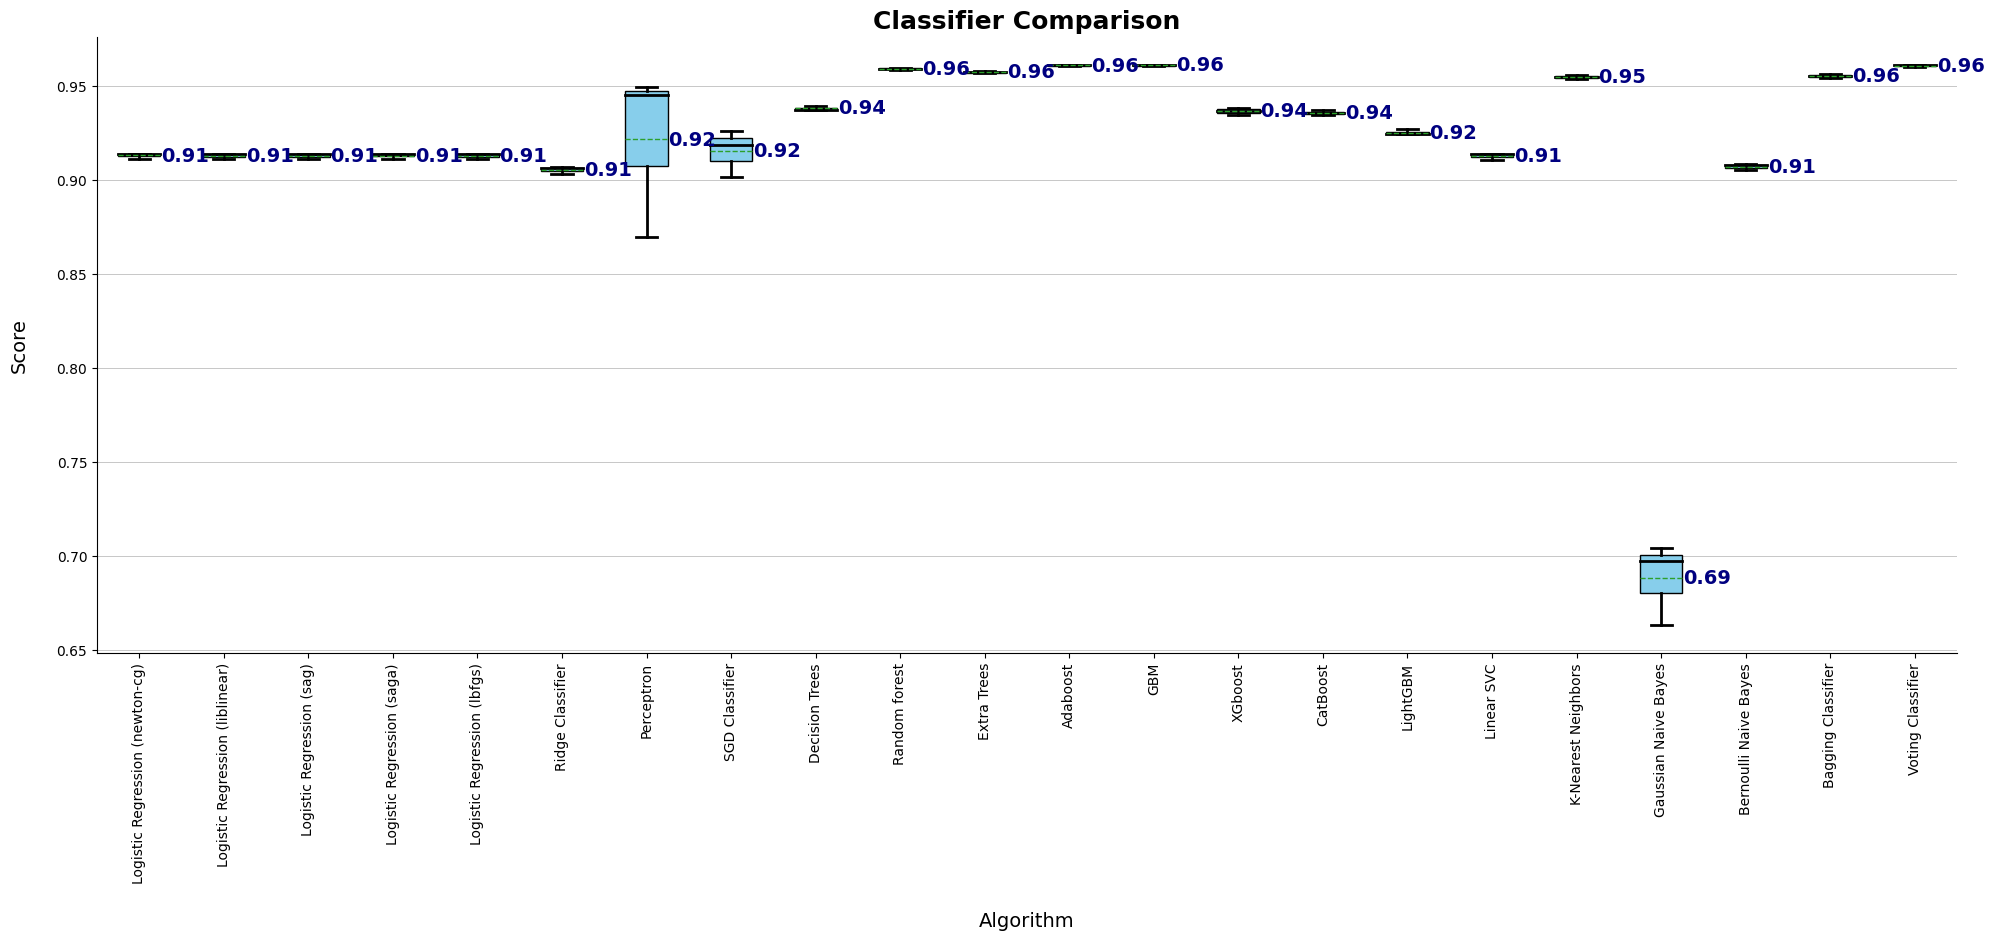

In [73]:
# Perform Cross Validation on Working Professional Dataset
wp_cv_results, wp_cv_names = model_cross_validation_perf(classifiers, X_wtrain, y_wtrain)
boxplot_cv(wp_cv_results, wp_cv_names)

#### **Working Professional (Oversampled)**


Cross-Validation Performance:

Logistic Regression (newton-cg): Mean Score = 0.9500, Std Dev = 0.0011
Logistic Regression (liblinear): Mean Score = 0.9500, Std Dev = 0.0011
Logistic Regression (sag): Mean Score = 0.9500, Std Dev = 0.0011
Logistic Regression (saga): Mean Score = 0.9500, Std Dev = 0.0011
Logistic Regression (lbfgs): Mean Score = 0.9497, Std Dev = 0.0012
Ridge Classifier: Mean Score = 0.9480, Std Dev = 0.0012
Perceptron: Mean Score = 0.8727, Std Dev = 0.0679
SGD Classifier: Mean Score = 0.9459, Std Dev = 0.0018
Decision Trees: Mean Score = 0.9536, Std Dev = 0.0011
Random forest: Mean Score = 0.9750, Std Dev = 0.0009
Extra Trees: Mean Score = 0.9782, Std Dev = 0.0001
Adaboost: Mean Score = 0.9428, Std Dev = 0.0014
GBM: Mean Score = 0.9550, Std Dev = 0.0008
XGboost: Mean Score = 0.9736, Std Dev = 0.0007
CatBoost: Mean Score = 0.9783, Std Dev = 0.0006
LightGBM: Mean Score = 0.9745, Std Dev = 0.0007
Linear SVC: Mean Score = 0.9499, Std Dev = 0.0012
K-Nearest Neighbors: Mean 

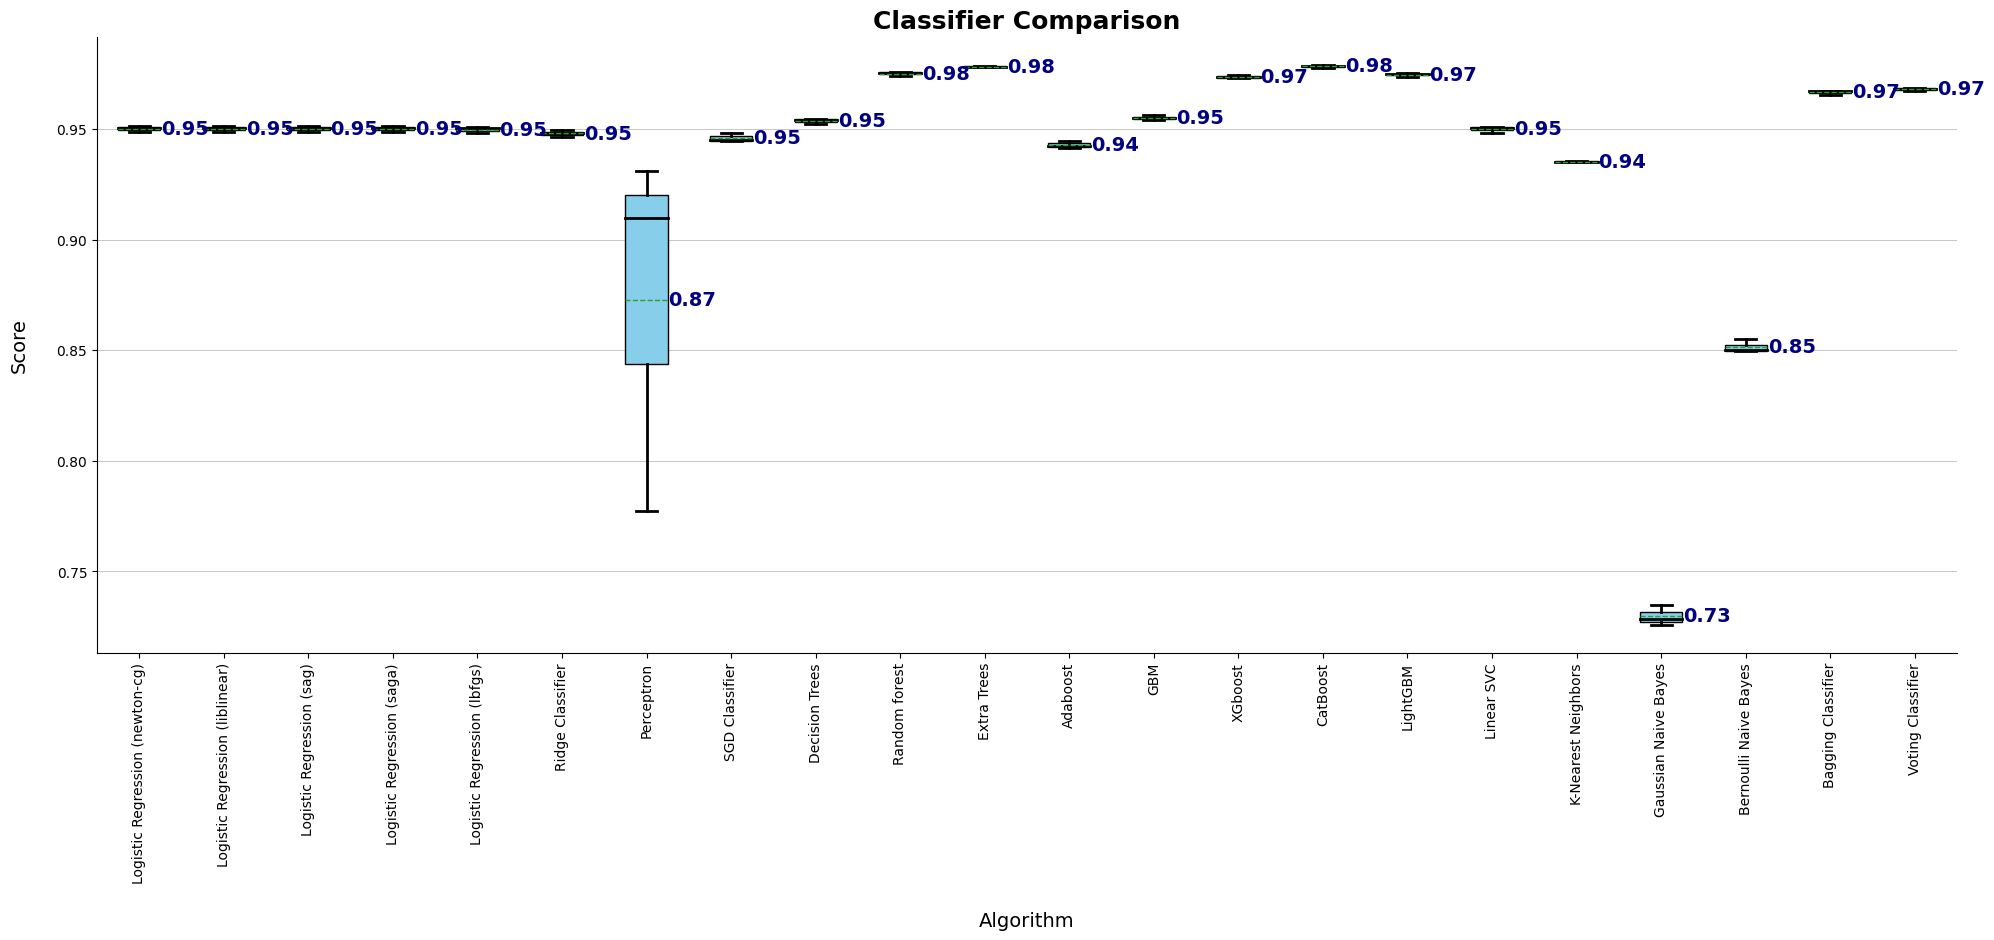

In [74]:
# Perform Cross Validation on Working Professional Dataset
wp_smote_cv_results, wp_smote_cv_names = model_cross_validation_perf(classifiers2, X_wtrain_smote, y_wtrain_smote)
boxplot_cv(wp_smote_cv_results, wp_smote_cv_names)

#### **Student**


Cross-Validation Performance:

Logistic Regression (newton-cg): Mean Score = 0.8461, Std Dev = 0.0042
Logistic Regression (liblinear): Mean Score = 0.8461, Std Dev = 0.0043
Logistic Regression (sag): Mean Score = 0.8461, Std Dev = 0.0042
Logistic Regression (saga): Mean Score = 0.8460, Std Dev = 0.0041
Logistic Regression (lbfgs): Mean Score = 0.8461, Std Dev = 0.0042
Ridge Classifier: Mean Score = 0.8449, Std Dev = 0.0032
Perceptron: Mean Score = 0.7836, Std Dev = 0.0257
SGD Classifier: Mean Score = 0.8387, Std Dev = 0.0030
Decision Trees: Mean Score = 0.7695, Std Dev = 0.0063
Random forest: Mean Score = 0.8387, Std Dev = 0.0007
Extra Trees: Mean Score = 0.8336, Std Dev = 0.0028
Adaboost: Mean Score = 0.8447, Std Dev = 0.0035
GBM: Mean Score = 0.8455, Std Dev = 0.0035
XGboost: Mean Score = 0.8328, Std Dev = 0.0018
CatBoost: Mean Score = 0.8450, Std Dev = 0.0037
LightGBM: Mean Score = 0.8416, Std Dev = 0.0036
Linear SVC: Mean Score = 0.8462, Std Dev = 0.0043
K-Nearest Neighbors: Mean 

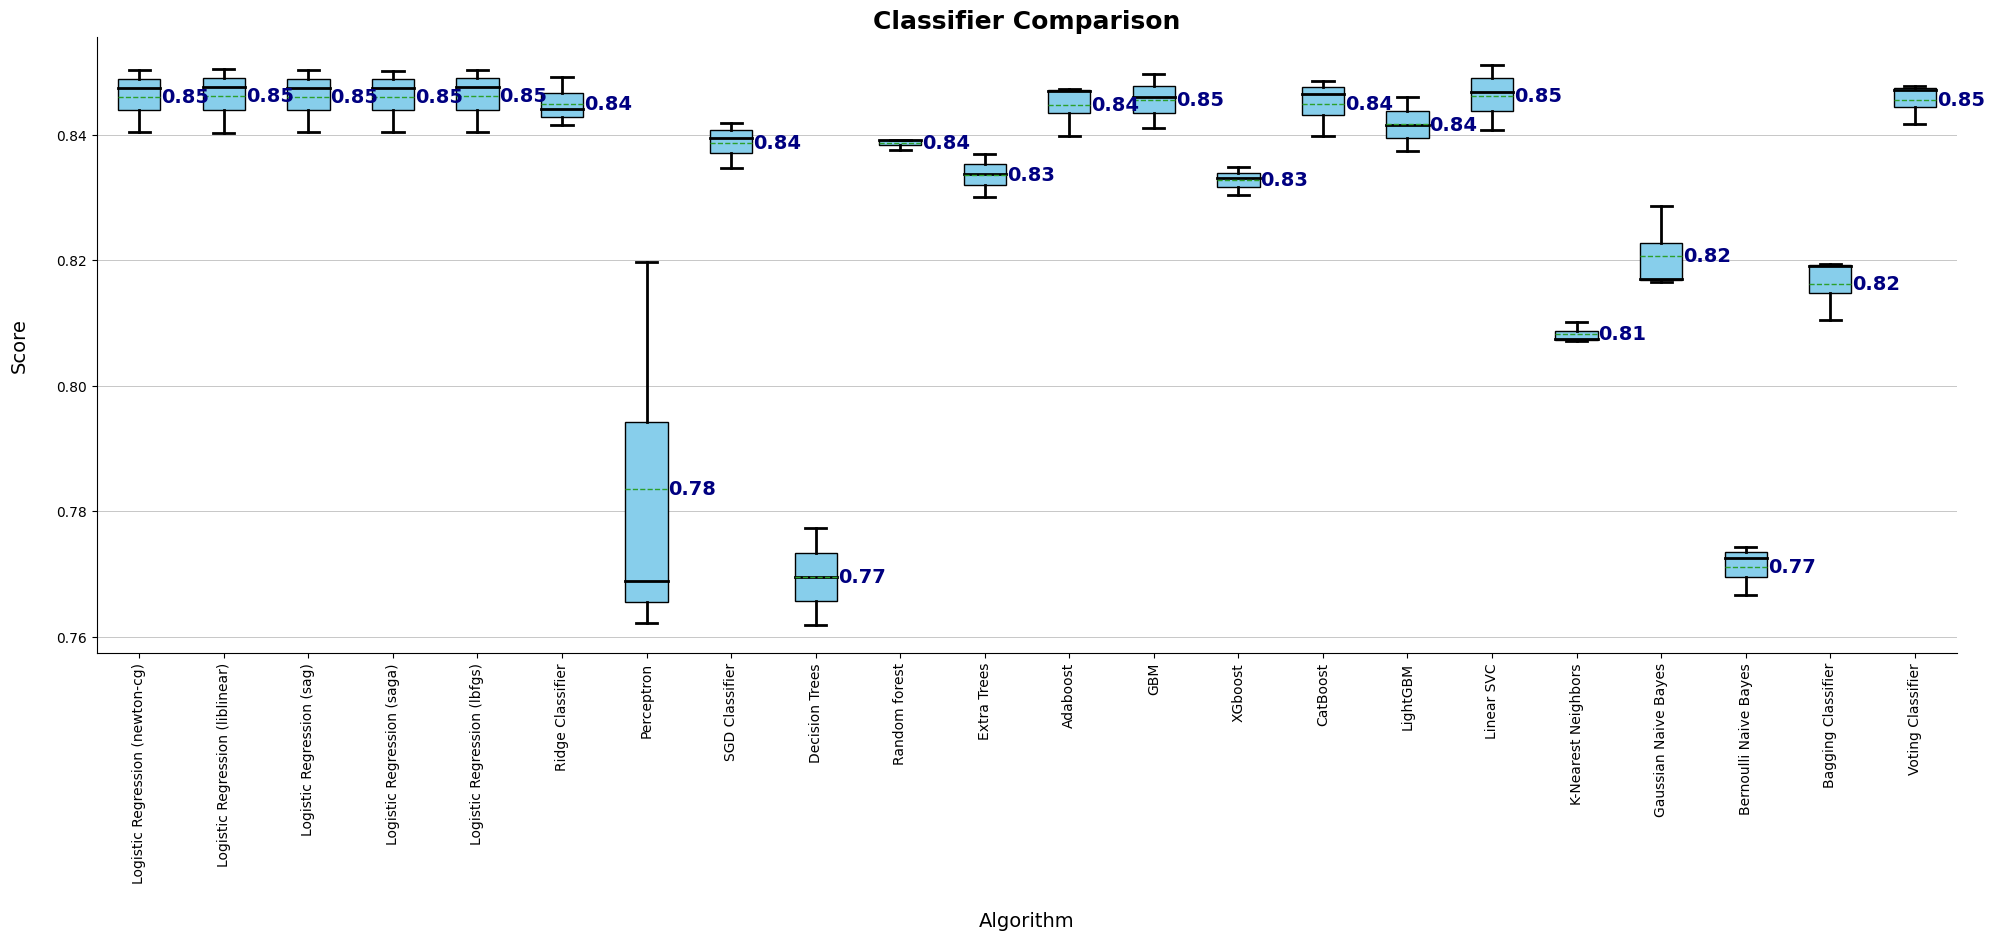

In [75]:
# Perform Cross Validation on Student Dataset
st_cv_results, st_cv_names = model_cross_validation_perf(classifiers2, X_strain, y_strain)
boxplot_cv(st_cv_results, st_cv_names)

### **Model Training**

In [76]:
# Model evaluation on the Working Professional dataset
work_results = model_perf(classifiers, X_wtrain, y_wtrain, X_wtest, y_wtest, threshold_optimization="accuracy")


Running evaluation for classifier: Logistic Regression (newton-cg)


Classifier  Threshold  Accuracy  Precision    Recall  \
0  Logistic Regression (newton-cg)       0.91  0.961372   0.809282  0.690808   
1  Logistic Regression (newton-cg)       0.91  0.960402   0.801604  0.685807   

         F1   ROC AUC       MCC       FMI Dataset  
0  0.745367  0.971146  0.727266  0.956879   Train  
1  0.739198  0.970366  0.720472  0.955830    Test


Running evaluation for classifier: Logistic Regression (liblinear)


Classifier  Threshold  Accuracy  Precision    Recall  \
0  Logistic Regression (liblinear)       0.89  0.960739   0.782331  0.720829   
1  Logistic Regression (liblinear)       0.89  0.960343   0.778820  0.719754   

         F1   ROC AUC       MCC       FMI Dataset  
0  0.750322  0.971145  0.729775  0.955909   Train  
1  0.748123  0.970363  0.727302  0.955471    Test


Running evaluation for classifier: Logistic Regression (sag)


Classifier  Threshold  Accuracy  Precision    Recall  \
0  Logistic Regression (sag)       0.91  0.961372   0.809282  0.690808   
1  Logistic Regression (sag)       0.91  0.960402   0.801604  0.685807   

         F1   ROC AUC       MCC       FMI Dataset  
0  0.745367  0.971146  0.727266  0.956879   Train  
1  0.739198  0.970366  0.720472  0.955830    Test


Running evaluation for classifier: Logistic Regression (saga)


Classifier  Threshold  Accuracy  Precision    Recall  \
0  Logistic Regression (saga)       0.91  0.961372   0.809282  0.690808   
1  Logistic Regression (saga)       0.91  0.960372   0.801520  0.685446   

         F1   ROC AUC       MCC       FMI Dataset  
0  0.745367  0.971146  0.727266  0.956879   Train  
1  0.738953  0.970366  0.720224  0.955800    Test


Running evaluation for classifier: Logistic Regression (lbfgs)


Classifier  Threshold  Accuracy  Precision    Recall  \
0  Logistic Regression (lbfgs)        0.9  0.961170   0.795716  0.707057   
1  Logistic Regression (lbfgs)        0.9  0.960372   0.788601  0.704586   

         F1   ROC AUC       MCC       FMI Dataset  
0  0.748771  0.971138  0.729300  0.956509   Train  
1  0.744230  0.970366  0.724174  0.955632    Test


Running evaluation for classifier: Ridge Classifier
Error finding optimal threshold for 'Ridge Classifier': The classifier 'RidgeClassifier(class_weight='balanced', random_state=42)' does not support `predict_proba`.

Running evaluation for classifier: Perceptron
Error finding optimal threshold for 'Perceptron': The classifier 'Perceptron(class_weight='balanced', random_state=42)' does not support `predict_proba`.

Running evaluation for classifier: SGD Classifier
Error finding optimal threshold for 'SGD Classifier': The classifier 'SGDClassifier(class_weight='balanced', random_state=42)' does not support `predict_proba`.

Running evaluation for classifier: Decision Trees


Classifier  Threshold  Accuracy  Precision    Recall        F1  \
0  Decision Trees       0.01  0.999785   0.997376  1.000000  0.998686   
1  Decision Trees       0.01  0.937057   0.611285  0.633803  0.622340   

    ROC AUC       MCC       FMI Dataset  
0  1.000000  0.998570  0.999747   Train  
1  0.798931  0.588134  0.930385    Test


Running evaluation for classifier: Random forest


Classifier  Threshold  Accuracy  Precision    Recall        F1  \
0  Random forest       0.44  0.999772   0.997222  1.000000  0.998609   
1  Random forest       0.44  0.959249   0.793497  0.678584  0.731555   

    ROC AUC       MCC       FMI Dataset  
0  0.999973  0.998486  0.999732   Train  
1  0.963162  0.712195  0.954599    Test


Running evaluation for classifier: Extra Trees


Classifier  Threshold  Accuracy  Precision    Recall        F1   ROC AUC  \
0  Extra Trees       0.43  0.999785   0.997376  1.000000  0.998686  1.000000   
1  Extra Trees       0.43  0.957417   0.784003  0.661972  0.717838  0.959443   

        MCC       FMI Dataset  
0  0.998570  0.999747   Train  
1  0.697897  0.952698    Test


Running evaluation for classifier: Adaboost


Classifier  Threshold  Accuracy  Precision    Recall        F1   ROC AUC  \
0   Adaboost        0.5  0.960929    0.80396  0.691117  0.743280  0.970900   
1   Adaboost        0.5  0.960491    0.79538  0.696280  0.742538  0.969401   

        MCC       FMI Dataset  
0  0.724686  0.956377   Train  
1  0.723117  0.955837    Test


Running evaluation for classifier: GBM


Classifier  Threshold  Accuracy  Precision    Recall        F1   ROC AUC  \
0        GBM       0.52  0.961828   0.835017  0.664964  0.740351  0.972648   
1        GBM       0.52  0.960402   0.821124  0.659805  0.731678  0.969834   

        MCC       FMI Dataset  
0  0.725478  0.957632   Train  
1  0.715532  0.956074    Test


Running evaluation for classifier: XGboost


Classifier  Threshold  Accuracy  Precision    Recall        F1   ROC AUC  \
0    XGboost       0.92  0.968971   0.873557  0.725936  0.792934  0.991193   
1    XGboost       0.92  0.959929   0.814699  0.660527  0.729557  0.967094   

        MCC       FMI Dataset  
0  0.780205  0.965189   Train  
1  0.712720  0.955535    Test


Running evaluation for classifier: CatBoost


Classifier  Threshold  Accuracy  Precision    Recall        F1   ROC AUC  \
0   CatBoost        0.9  0.968287   0.852261  0.740947  0.792715  0.990191   
1   CatBoost        0.9  0.960786   0.802941  0.690141  0.742280  0.969134   

        MCC       FMI Dataset  
0  0.777864  0.964296   Train  
1  0.723611  0.956224    Test


Running evaluation for classifier: LightGBM


Classifier  Threshold  Accuracy  Precision    Recall        F1   ROC AUC  \
0   LightGBM       0.93  0.963449    0.84881  0.673321  0.750949  0.983186   
1   LightGBM       0.93  0.961761    0.83722  0.661250  0.738902  0.970153   

        MCC       FMI Dataset  
0  0.737226  0.959383   Train  
1  0.724405  0.957592    Test


Running evaluation for classifier: Linear SVC
Error finding optimal threshold for 'Linear SVC': The classifier 'LinearSVC(class_weight='balanced', max_iter=10000, random_state=42)' does not support `predict_proba`.

Running evaluation for classifier: K-Nearest Neighbors


Classifier  Threshold  Accuracy  Precision    Recall        F1  \
0  K-Nearest Neighbors       0.41  0.965805   0.858833  0.696688  0.769310   
1  K-Nearest Neighbors       0.41  0.953694   0.770965  0.617551  0.685783   

    ROC AUC       MCC       FMI Dataset  
0  0.986105  0.755857  0.961837   Train  
1  0.910624  0.665862  0.948985    Test


Running evaluation for classifier: Gaussian Naive Bayes


Classifier  Threshold  Accuracy  Precision    Recall        F1  \
0  Gaussian Naive Bayes        1.0  0.921225   0.606514  0.106623  0.181364   
1  Gaussian Naive Bayes        1.0  0.921011   0.598361  0.105453  0.179306   

    ROC AUC       MCC       FMI Dataset  
0  0.820480  0.231251  0.922381   Train  
1  0.822722  0.227950  0.922176    Test


Running evaluation for classifier: Bernoulli Naive Bayes


Classifier  Threshold  Accuracy  Precision    Recall        F1  \
0  Bernoulli Naive Bayes       0.99  0.931547   0.704607  0.281647  0.402432   
1  Bernoulli Naive Bayes       0.99  0.931885   0.710145  0.283135  0.404854   

    ROC AUC       MCC       FMI Dataset  
0  0.908627  0.417799  0.929711   Train  
1  0.906195  0.420962  0.930049    Test


Running evaluation for classifier: Bagging Classifier


Classifier  Threshold  Accuracy  Precision    Recall        F1  \
0  Bagging Classifier       0.52  0.995048   0.992376  0.946766  0.969035   
1  Bagging Classifier       0.52  0.955024   0.779471  0.628025  0.695600   

    ROC AUC       MCC       FMI Dataset  
0  0.999820  0.966661  0.994229   Train  
1  0.929594  0.676192  0.950360    Test


Running evaluation for classifier: Voting Classifier


Classifier  Threshold  Accuracy  Precision    Recall        F1  \
0  Voting Classifier       0.53  0.976241   0.882805  0.818323  0.849341   
1  Voting Classifier       0.53  0.960018   0.784337  0.705309  0.742727   

    ROC AUC       MCC       FMI Dataset  
0  0.994015  0.837174  0.972880   Train  
1  0.970316  0.722313  0.955226    Test

In [77]:
# Model evaluation on the Working Professional (with SMOTE) dataset
work_smote_results = model_perf(classifiers2, X_wtrain_smote, y_wtrain_smote, X_wtest, y_wtest, threshold_optimization="accuracy")


Running evaluation for classifier: Logistic Regression (newton-cg)


Classifier  Threshold  Accuracy  Precision    Recall  \
0  Logistic Regression (newton-cg)       0.85  0.922162   0.980984  0.861015   
1  Logistic Regression (newton-cg)       0.85  0.957683   0.781711  0.669917   

         F1   ROC AUC       MCC       FMI Dataset  
0  0.917093  0.988764  0.850710  0.857529   Train  
1  0.721509  0.964683  0.701195  0.952920    Test


Running evaluation for classifier: Logistic Regression (liblinear)


Classifier  Threshold  Accuracy  Precision    Recall  \
0  Logistic Regression (liblinear)       0.85  0.922204   0.981016  0.861070   
1  Logistic Regression (liblinear)       0.85  0.957683   0.781711  0.669917   

         F1   ROC AUC       MCC       FMI Dataset  
0  0.917138  0.988765  0.850791  0.857598   Train  
1  0.721509  0.964685  0.701195  0.952920    Test


Running evaluation for classifier: Logistic Regression (sag)


Classifier  Threshold  Accuracy  Precision    Recall  \
0  Logistic Regression (sag)       0.85  0.922162   0.980984  0.861015   
1  Logistic Regression (sag)       0.85  0.957683   0.781711  0.669917   

         F1   ROC AUC       MCC       FMI Dataset  
0  0.917093  0.988764  0.850710  0.857529   Train  
1  0.721509  0.964683  0.701195  0.952920    Test


Running evaluation for classifier: Logistic Regression (saga)


Classifier  Threshold  Accuracy  Precision    Recall  \
0  Logistic Regression (saga)       0.85  0.922169   0.980984  0.861029   
1  Logistic Regression (saga)       0.85  0.957683   0.781711  0.669917   

         F1   ROC AUC       MCC       FMI Dataset  
0  0.917101  0.988764  0.850723  0.857541   Train  
1  0.721509  0.964683  0.701195  0.952920    Test


Running evaluation for classifier: Logistic Regression (lbfgs)


Classifier  Threshold  Accuracy  Precision    Recall  \
0  Logistic Regression (lbfgs)       0.85  0.922011   0.980932  0.860753   
1  Logistic Regression (lbfgs)       0.85  0.957654   0.780672  0.671000   

         F1   ROC AUC       MCC       FMI Dataset  
0  0.916921  0.988725  0.850428  0.857279   Train  
1  0.721694  0.964521  0.701265  0.952877    Test


Running evaluation for classifier: Ridge Classifier
Error finding optimal threshold for 'Ridge Classifier': The classifier 'RidgeClassifier(random_state=42)' does not support `predict_proba`.

Running evaluation for classifier: Perceptron
Error finding optimal threshold for 'Perceptron': The classifier 'Perceptron(random_state=42)' does not support `predict_proba`.

Running evaluation for classifier: SGD Classifier
Error finding optimal threshold for 'SGD Classifier': The classifier 'SGDClassifier(random_state=42)' does not support `predict_proba`.

Running evaluation for classifier: Decision Trees


Classifier  Threshold  Accuracy  Precision    Recall        F1  \
0  Decision Trees       0.01  0.999883   0.999766  1.000000  0.999883   
1  Decision Trees       0.01  0.932240   0.571990  0.682918  0.622551   

    ROC AUC       MCC       FMI Dataset  
0  1.000000  0.999766  0.999766   Train  
1  0.818691  0.588427  0.924614    Test


Running evaluation for classifier: Random forest


Classifier  Threshold  Accuracy  Precision    Recall        F1  \
0  Random forest       0.65  0.999386   0.999972  0.998800  0.999386   
1  Random forest       0.65  0.957831   0.794298  0.654027  0.717370   

    ROC AUC       MCC       FMI Dataset  
0  1.000000  0.998773  0.998773   Train  
1  0.964294  0.698647  0.953240    Test


Running evaluation for classifier: Extra Trees


Classifier  Threshold  Accuracy  Precision    Recall        F1   ROC AUC  \
0  Extra Trees       0.65  0.999890   0.999972  0.999807  0.999890  1.000000   
1  Extra Trees       0.65  0.956147   0.806390  0.610690  0.695027  0.961042   

        MCC       FMI Dataset  
0  0.999779  0.999779   Train  
1  0.679428  0.951805    Test


Running evaluation for classifier: Adaboost


Classifier  Threshold  Accuracy  Precision    Recall        F1   ROC AUC  \
0   Adaboost       0.51  0.907044   0.981387  0.829827  0.899266  0.986449   
1   Adaboost       0.51  0.958156   0.778739  0.682557  0.727483  0.965878   

        MCC       FMI Dataset  
0  0.823974  0.833413   Train  
1  0.706724  0.953333    Test


Running evaluation for classifier: GBM


Classifier  Threshold  Accuracy  Precision    Recall        F1   ROC AUC  \
0        GBM       0.81  0.928073   0.986182  0.868312  0.923501  0.991760   
1        GBM       0.81  0.960343   0.820099  0.660166  0.731493  0.968621   

        MCC       FMI Dataset  
0  0.862327  0.867460   Train  
1  0.715227  0.956004    Test


Running evaluation for classifier: XGboost


Classifier  Threshold  Accuracy  Precision    Recall        F1   ROC AUC  \
0    XGboost       0.69  0.978268   0.989179  0.967116  0.978023  0.998114   
1    XGboost       0.69  0.959486   0.790041  0.687613  0.735277  0.966984   

        MCC       FMI Dataset  
0  0.956774  0.957491   Train  
1  0.715472  0.954783    Test


Running evaluation for classifier: CatBoost


Classifier  Threshold  Accuracy  Precision    Recall        F1   ROC AUC  \
0   CatBoost       0.56  0.984186   0.991143  0.977103  0.984073  0.998616   
1   CatBoost       0.56  0.960491   0.802110  0.686529  0.739833  0.969523   

        MCC       FMI Dataset  
0  0.968468  0.968874   Train  
1  0.721142  0.955924    Test


Running evaluation for classifier: LightGBM


Classifier  Threshold  Accuracy  Precision    Recall        F1   ROC AUC  \
0   LightGBM       0.69  0.973820   0.988176  0.959116  0.973429  0.997254   
1   LightGBM       0.69  0.960254   0.806897  0.676056  0.735704  0.968779   

        MCC       FMI Dataset  
0  0.948049  0.949031   Train  
1  0.717666  0.955753    Test


Running evaluation for classifier: Linear SVC
Error finding optimal threshold for 'Linear SVC': The classifier 'LinearSVC(max_iter=10000, random_state=42)' does not support `predict_proba`.

Running evaluation for classifier: K-Nearest Neighbors


Classifier  Threshold  Accuracy  Precision    Recall        F1  \
0  K-Nearest Neighbors       0.81  0.987758   1.000000  0.975516  0.987606   
1  K-Nearest Neighbors       0.81  0.937855   0.614119  0.647165  0.630209   

    ROC AUC       MCC       FMI Dataset  
0  0.999320  0.975809  0.975823   Train  
1  0.926108  0.596556  0.931120    Test


Running evaluation for classifier: Gaussian Naive Bayes


Classifier  Threshold  Accuracy  Precision    Recall        F1  \
0  Gaussian Naive Bayes        1.0  0.678649   0.878621  0.414569  0.563334   
1  Gaussian Naive Bayes        1.0  0.896483   0.373186  0.390033  0.381423   

    ROC AUC       MCC       FMI Dataset  
0  0.872960  0.420773  0.621891   Train  
1  0.752227  0.325063  0.890394    Test


Running evaluation for classifier: Bernoulli Naive Bayes


Classifier  Threshold  Accuracy  Precision  Recall   F1  \
0  Bernoulli Naive Bayes        1.0  0.500000        0.0     0.0  0.0   
1  Bernoulli Naive Bayes        1.0  0.918174        0.0     0.0  0.0   

    ROC AUC  MCC       FMI Dataset  
0  0.932387  0.0  0.707104   Train  
1  0.901600  0.0  0.921810    Test


Running evaluation for classifier: Bagging Classifier


Classifier  Threshold  Accuracy  Precision    Recall        F1  \
0  Bagging Classifier        0.7  0.992172   0.999888  0.984455  0.992111   
1  Bagging Classifier        0.7  0.951093   0.767274  0.577465  0.658974   

   ROC AUC       MCC       FMI Dataset  
0  0.99998  0.984461  0.984468   Train  
1  0.93586  0.640622  0.946542    Test


Running evaluation for classifier: Voting Classifier


Classifier  Threshold  Accuracy  Precision    Recall        F1  \
0  Voting Classifier       0.77  0.975385   0.998914  0.951805  0.974791   
1  Voting Classifier       0.77  0.959043   0.793381  0.675334  0.729614   

    ROC AUC       MCC       FMI Dataset  
0  0.999299  0.951829  0.952035   Train  
1  0.966707  0.710300  0.954397    Test

In [78]:
# Model evaluation on the Student dataset
student_results = model_perf(classifiers2, X_strain, y_strain, X_stest, y_stest, threshold_optimization="accuracy")


Running evaluation for classifier: Logistic Regression (newton-cg)


Classifier  Threshold  Accuracy  Precision    Recall  \
0  Logistic Regression (newton-cg)        0.5  0.846697   0.856491  0.886751   
1  Logistic Regression (newton-cg)        0.5  0.848405   0.858751  0.886962   

         F1  ROC AUC       MCC       FMI Dataset  
0  0.871359  0.92009  0.682467  0.749701   Train  
1  0.872629  0.92190  0.686100  0.751801    Test


Running evaluation for classifier: Logistic Regression (liblinear)


Classifier  Threshold  Accuracy  Precision    Recall  \
0  Logistic Regression (liblinear)        0.5  0.846646   0.856419  0.886751   
1  Logistic Regression (liblinear)        0.5  0.848166   0.858554  0.886758   

         F1   ROC AUC       MCC       FMI Dataset  
0  0.871321  0.920100  0.682358  0.749638   Train  
1  0.872428  0.921875  0.685604  0.751480    Test


Running evaluation for classifier: Logistic Regression (sag)


Classifier  Threshold  Accuracy  Precision    Recall  \
0  Logistic Regression (sag)        0.5  0.846595   0.856467  0.886576   
1  Logistic Regression (sag)        0.5  0.848286   0.858724  0.886758   

         F1  ROC AUC       MCC       FMI Dataset  
0  0.871262  0.92009  0.682260  0.749553   Train  
1  0.872516  0.92190  0.685858  0.751628    Test


Running evaluation for classifier: Logistic Regression (saga)


Classifier  Threshold  Accuracy  Precision    Recall  \
0  Logistic Regression (saga)        0.5  0.846697   0.856491  0.886751   
1  Logistic Regression (saga)        0.5  0.848405   0.858751  0.886962   

         F1  ROC AUC       MCC       FMI Dataset  
0  0.871359  0.92009  0.682467  0.749701   Train  
1  0.872629  0.92190  0.686100  0.751801    Test


Running evaluation for classifier: Logistic Regression (lbfgs)


Classifier  Threshold  Accuracy  Precision    Recall  \
0  Logistic Regression (lbfgs)        0.5  0.846697   0.856491  0.886751   
1  Logistic Regression (lbfgs)        0.5  0.848405   0.858751  0.886962   

         F1   ROC AUC       MCC       FMI Dataset  
0  0.871359  0.920090  0.682467  0.749701   Train  
1  0.872629  0.921899  0.686100  0.751801    Test


Running evaluation for classifier: Ridge Classifier
Error finding optimal threshold for 'Ridge Classifier': The classifier 'RidgeClassifier(random_state=42)' does not support `predict_proba`.

Running evaluation for classifier: Perceptron
Error finding optimal threshold for 'Perceptron': The classifier 'Perceptron(random_state=42)' does not support `predict_proba`.

Running evaluation for classifier: SGD Classifier
Error finding optimal threshold for 'SGD Classifier': The classifier 'SGDClassifier(random_state=42)' does not support `predict_proba`.

Running evaluation for classifier: Decision Trees


Classifier  Threshold  Accuracy  Precision    Recall        F1  \
0  Decision Trees       0.01  1.000000   1.000000  1.000000  1.000000   
1  Decision Trees       0.01  0.770517   0.805078  0.802285  0.803679   

    ROC AUC       MCC       FMI Dataset  
0  1.000000  1.000000  1.000000   Train  
1  0.763967  0.527561  0.656091    Test


Running evaluation for classifier: Random forest


Classifier  Threshold  Accuracy  Precision    Recall       F1  ROC AUC  \
0  Random forest       0.49  1.000000   1.000000  1.000000  1.00000  1.00000   
1  Random forest       0.49  0.840879   0.843636  0.893899  0.86804  0.91482   

        MCC       FMI Dataset  
0  1.000000  1.000000   Train  
1  0.669877  0.743585    Test


Running evaluation for classifier: Extra Trees


Classifier  Threshold  Accuracy  Precision    Recall        F1   ROC AUC  \
0  Extra Trees       0.55  1.000000    1.00000  1.000000  1.000000  1.000000   
1  Extra Trees       0.55  0.834428    0.85904  0.857988  0.858514  0.910037   

        MCC       FMI Dataset  
0  1.000000  1.000000   Train  
1  0.658975  0.731404    Test


Running evaluation for classifier: Adaboost


Classifier  Threshold  Accuracy  Precision    Recall        F1   ROC AUC  \
0   Adaboost        0.5  0.847414   0.856902  0.887626  0.871993  0.921302   
1   Adaboost        0.5  0.849600   0.858888  0.889206  0.873784  0.922837   

        MCC       FMI Dataset  
0  0.683941  0.750693   Train  
1  0.688506  0.753558    Test


Running evaluation for classifier: GBM


Classifier  Threshold  Accuracy  Precision    Recall        F1   ROC AUC  \
0        GBM       0.48  0.854173   0.857048  0.901268  0.878602  0.925891   
1        GBM       0.48  0.849361   0.852440  0.898184  0.874714  0.922846   

        MCC       FMI Dataset  
0  0.697709  0.760810   Train  
1  0.687655  0.754406    Test


Running evaluation for classifier: XGboost


Classifier  Threshold  Accuracy  Precision    Recall        F1   ROC AUC  \
0    XGboost       0.46  0.919201   0.910948  0.955400  0.932645  0.975709   
1    XGboost       0.46  0.838729   0.842562  0.891043  0.866125  0.911477   

        MCC       FMI Dataset  
0  0.833315  0.857299   Train  
1  0.665403  0.740636    Test


Running evaluation for classifier: CatBoost


Classifier  Threshold  Accuracy  Precision    Recall        F1   ROC AUC  \
0   CatBoost        0.5   0.88597   0.889773  0.919108  0.904203  0.953404   
1   CatBoost        0.5   0.84948   0.857171  0.891451  0.873975  0.921227   

        MCC       FMI Dataset  
0  0.764073  0.805080   Train  
1  0.688135  0.753684    Test


Running evaluation for classifier: LightGBM


Classifier  Threshold  Accuracy  Precision    Recall        F1   ROC AUC  \
0   LightGBM        0.5  0.872965   0.878573  0.908614  0.893341  0.945299   
1   LightGBM        0.5  0.848047   0.857537  0.887982  0.872494  0.921051   

        MCC       FMI Dataset  
0  0.737051  0.786098   Train  
1  0.685275  0.751480    Test


Running evaluation for classifier: Linear SVC
Error finding optimal threshold for 'Linear SVC': The classifier 'LinearSVC(max_iter=10000, random_state=42)' does not support `predict_proba`.

Running evaluation for classifier: K-Nearest Neighbors


Classifier  Threshold  Accuracy  Precision    Recall        F1  \
0  K-Nearest Neighbors       0.41  0.865438   0.864860  0.912812  0.888189   
1  K-Nearest Neighbors       0.41  0.811014   0.817851  0.871251  0.843707   

    ROC AUC       MCC       FMI Dataset  
0  0.943791  0.721212  0.776616   Train  
1  0.868150  0.607275  0.706736    Test


Running evaluation for classifier: Gaussian Naive Bayes


Classifier  Threshold  Accuracy  Precision    Recall        F1  \
0  Gaussian Naive Bayes       0.46  0.824014   0.847377  0.853083  0.850220   
1  Gaussian Naive Bayes       0.46  0.826544   0.851580  0.852275  0.851927   

    ROC AUC       MCC       FMI Dataset  
0  0.895573  0.636941  0.718562   Train  
1  0.900444  0.642585  0.721383    Test


Running evaluation for classifier: Bernoulli Naive Bayes


Classifier  Threshold  Accuracy  Precision    Recall        F1  \
0  Bernoulli Naive Bayes       0.42  0.774859    0.76117  0.896895  0.823477   
1  Bernoulli Naive Bayes       0.42  0.776371    0.76216  0.898388  0.824686   

    ROC AUC       MCC       FMI Dataset  
0  0.826921  0.531869  0.679871   Train  
1  0.834761  0.535230  0.681415    Test


Running evaluation for classifier: Bagging Classifier


Classifier  Threshold  Accuracy  Precision    Recall        F1  \
0  Bagging Classifier       0.51  0.987814   0.993303  0.985833  0.989554   
1  Bagging Classifier       0.51  0.822124   0.852043  0.842481  0.847235   

    ROC AUC       MCC       FMI Dataset  
0  0.999300  0.974972  0.976574   Train  
1  0.890534  0.634443  0.715170    Test


Running evaluation for classifier: Voting Classifier


Classifier  Threshold  Accuracy  Precision   Recall        F1  \
0  Voting Classifier       0.56  0.902151   0.920597  0.91150  0.916026   
1  Voting Classifier       0.56  0.846255   0.869832  0.86717  0.868499   

    ROC AUC       MCC       FMI Dataset  
0  0.975800  0.798872  0.828132   Train  
1  0.919214  0.683458  0.746966    Test

**Observations**
---
- While SMOTE improves metrics during training, many models fail to generalize well to unseen data, 
- Boosting models seem to provide the best performance for both Working Professional and Student datasets, especially with GBM, Adaboost, and CatBoost classifers.
- Logistic Regression and Voting models have also performed well.

In [79]:
# Classifier for Working Professional 
classifiers_boosting = [
    # Boosting Methods
    ("Adaboost", AdaBoostClassifier(random_state=42)),
    ("GBM", GradientBoostingClassifier(random_state=42)),
    ("XGboost", XGBClassifier(scale_pos_weight=imbalance_ratio, random_state=42, eval_metric="logloss")),
    ("CatBoost", CatBoostClassifier(auto_class_weights="Balanced", silent=True, random_state=42)),
    ("LightGBM", LGBMClassifier(class_weight="balanced", verbosity=0, random_state=42)),
    ("Voting Classifier", VotingClassifier(estimators=[
        ("XGboost", XGBClassifier(scale_pos_weight=imbalance_ratio, eval_metric="logloss", random_state=42)),
        ("GBM", GradientBoostingClassifier(random_state=42)),
        ("Logistic Regression", LogisticRegression(class_weight="balanced", random_state=42)),
        ("Adaboost", AdaBoostClassifier(random_state=42)),
    ], voting="soft"))
]

In [80]:
from sklearn.model_selection import RandomizedSearchCV

def hyperparameter_tuning(classifiers, param_grids, X_train, y_train, scoring="f1", n_iter=10, cv=3):
    best_models = {}
    results = {}

    for clf_name, clf in classifiers:

        if clf_name in param_grids:
            # Define the search object
            search = RandomizedSearchCV(
                estimator=clf,
                param_distributions=param_grids[clf_name],
                scoring=scoring,
                n_iter=n_iter,
                cv=cv,
                random_state=42,
                n_jobs=-1
            )

            # Fit the model
            search.fit(X_train, y_train)

            # Store the best model and results
            best_models[clf_name] = search.best_estimator_
            results[clf_name] = {
                "best_params": search.best_params_,
                "best_score": search.best_score_,
            }

            print(f"Best parameters for {clf_name}: {search.best_params_}")
            print(f"Best score for {clf_name}: {search.best_score_}")
        else:
            print(f"No hyperparameter tuning defined for {clf_name}.")
        print("--------"*10)

    return {"best_models": best_models, "results": results}


In [81]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Define hyperparameter grids
param_grids = {
    "Adaboost": {
        "n_estimators": [50, 100, 200, 300, 400],
        "learning_rate": [0.001, 0.01, 0.1, 0.5, 1.0],
    },
    "GBM": {
        "n_estimators": [50, 100, 200, 300, 400],
        "learning_rate": [0.001, 0.01, 0.1, 0.5],
        "max_depth": [3, 4, 5, 7, 10],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4],
    },
    "XGboost": {
        "n_estimators": [50, 100, 200, 300],
        "learning_rate": [0.001, 0.01, 0.1, 0.5],
        "max_depth": [3, 4, 5, 6, 7],
        "scale_pos_weight": [1, imbalance_ratio],
        "subsample": [0.6, 0.8, 1.0],
        "colsample_bytree": [0.6, 0.8, 1.0],
    },
    "CatBoost": {
        "iterations": [50, 100, 200, 300],
        "learning_rate": [0.001, 0.01, 0.1, 0.5],
        "depth": [4, 6, 8, 10],
        "l2_leaf_reg": [1, 3, 5, 7],
    },
    "LightGBM": {
        "n_estimators": [50, 100, 200, 300],
        "learning_rate": [0.001, 0.01, 0.1, 0.5],
        "num_leaves": [20, 31, 50, 70, 100],
        "min_child_samples": [5, 10, 20, 50],
        "feature_fraction": [0.6, 0.8, 1.0],
    },
}

In [82]:
# Perform hyperparameter tuning on the Working Professional dataset
best_model_work = hyperparameter_tuning(classifiers_boosting, param_grids, X_wtrain, y_wtrain, scoring="accuracy", n_iter=50, cv=5)

Best parameters for Adaboost: {'n_estimators': 200, 'learning_rate': 1.0}
Best score for Adaboost: 0.9621449008409432
--------------------------------------------------------------------------------
Best parameters for GBM: {'n_estimators': 400, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_depth': 3, 'learning_rate': 0.1}
Best score for GBM: 0.9624235341563049
--------------------------------------------------------------------------------
Best parameters for XGboost: {'subsample': 0.6, 'scale_pos_weight': 1, 'n_estimators': 200, 'max_depth': 4, 'learning_rate': 0.1, 'colsample_bytree': 0.8}
Best score for XGboost: 0.9617902973279959
--------------------------------------------------------------------------------
Best parameters for CatBoost: {'learning_rate': 0.5, 'l2_leaf_reg': 5, 'iterations': 200, 'depth': 10}
Best score for CatBoost: 0.9522283743827762
--------------------------------------------------------------------------------
[LightGBM] [Warning] feature_fraction is 

In [83]:
# Extract tuned classifiers
classifiers_work_best = []
for clf_name, clf in classifiers_boosting:
    if clf_name in best_model_work["best_models"]:
        # Use the tuned model
        classifiers2.append((clf_name, best_model_work["best_models"][clf_name]))
    else:
        # Use the default model if no tuning was performed
        classifiers2.append((clf_name, clf))

In [84]:
# 
best_results_work = model_perf(classifiers_work_best, X_wtrain, y_wtrain, X_wtest, y_wtest, threshold_optimization="accuracy")

In [85]:
# Perform hyperparameter tuning on the Student dataset
best_model_student = hyperparameter_tuning(classifiers_boosting, param_grids, X_strain, y_strain, scoring="accuracy", n_iter=50, cv=5)

Best parameters for Adaboost: {'n_estimators': 400, 'learning_rate': 0.5}
Best score for Adaboost: 0.8474142345110087
--------------------------------------------------------------------------------
Best parameters for GBM: {'n_estimators': 400, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_depth': 3, 'learning_rate': 0.1}
Best score for GBM: 0.8459293394777265
--------------------------------------------------------------------------------
Best parameters for XGboost: {'subsample': 1.0, 'scale_pos_weight': 1, 'n_estimators': 50, 'max_depth': 4, 'learning_rate': 0.1, 'colsample_bytree': 0.8}
Best score for XGboost: 0.8447516641065029
--------------------------------------------------------------------------------
Best parameters for CatBoost: {'learning_rate': 0.1, 'l2_leaf_reg': 7, 'iterations': 100, 'depth': 4}
Best score for CatBoost: 0.8417306707629288
--------------------------------------------------------------------------------
[LightGBM] [Warning] feature_fraction is se

In [86]:
# Extract tuned classifiers
classifiers_student_best = []
for clf_name, clf in classifiers_boosting:
    if clf_name in best_model_student["best_models"]:
        # Use the tuned model
        classifiers2.append((clf_name, best_model_student["best_models"][clf_name]))
    else:
        # Use the default model if no tuning was performed
        classifiers2.append((clf_name, clf))

In [87]:
best_results_student = model_perf(classifiers_student_best, X_strain, y_strain, X_stest, y_stest, threshold_optimization="accuracy")

In [88]:
class DataPipeline:
    def __init__(self, scaler_work, scaler_student, training_metrics):
        self.scaler_work = scaler_work
        self.scaler_student = scaler_student
        self.training_metrics = missing_metrics

    def process_file(self, filepath, column_mapping, valid_professions, profession_mapping, 
                     sleep_categories, dietary_categories, level_dict, field_dict, valid_cities):
        # Step 1: Load the file
        df = pd.read_csv(filepath)
        print(f"Loaded data with shape: {df.shape}")
        
        # Step 2: Rename columns
        df.rename(columns=column_mapping, inplace=True)

        # Step 3: Fix profession names
        df['Profession'] = df['Profession'].replace('Finanancial Analyst', 'Financial Analyst')

        # Step 4: Clean up professions
        df['Prof'] = df['Profession'].where(df['Profession'].isin(valid_professions), "Unknown")
        df['Prof'] = df['Prof'].replace(profession_mapping)
        rare_professions = df['Prof'].value_counts()[df['Prof'].value_counts() < 50].index
        df['Prof'] = df['Prof'].replace(rare_professions, 'Others')

        # Step 5: Clean up other categorical columns
        df['Sleep_Duration'] = df['Sleep_Duration'].replace(sleep_categories)
        df['Diet_Habits'] = df['Diet_Habits'].replace(dietary_categories)

        df['Ed_Level'] = df['Degree'].apply(
            lambda x: next((level for level, degrees in level_dict.items() if str(x).strip().lower() in map(str.lower, degrees)), "Unknown")
        )
        df['Ed_Field'] = df['Degree'].apply(
            lambda x: next((field for field, degrees in field_dict.items() if str(x).strip().lower() in map(str.lower, degrees)), "Unknown")
        )
        df['City'] = df['City'].apply(lambda x: x if x in valid_cities else "Unknown")

        # Step 6: Drop redundant columns
        df = df.drop(columns=['id', 'Name', 'Degree', 'Profession'], errors='ignore')

        # Step 7: Split data into working professionals and students
        df_w = df[df['Status'] == 'Working Professional'].copy()
        df_s = df[df['Status'] == 'Student'].copy()

        # Step 8: Label encoding
        df_w['Sleep_Duration'] = df_w['Sleep_Duration'].map(sleep_mapping)
        df_s['Sleep_Duration'] = df_s['Sleep_Duration'].map(sleep_mapping)
        df_w['Diet_Habits'] = df_w['Diet_Habits'].map(diet_mapping)
        df_s['Diet_Habits'] = df_s['Diet_Habits'].map(diet_mapping)
        df_w['Ed_Level'] = df_w['Ed_Level'].map(education_mapping)
        df_s['Ed_Level'] = df_s['Ed_Level'].map(education_mapping)

        # Step 8: Fill missing values
        df_w['Work_Pressure'].fillna(self.training_metrics['Work_Pressure_mode_work'], inplace=True)
        df_w['Fin_Stress'].fillna(self.training_metrics['Fin_Stress_mode_work'], inplace=True)
        df_w['Job_Sat'].fillna(self.training_metrics['Job_Sat_mode_work'], inplace=True)

        df_s['Acad_Pressure'].fillna(self.training_metrics['Acad_Pressure_mode_student'], inplace=True)
        df_s['CGPA'].fillna(self.training_metrics['CGPA_median_student'], inplace=True)
        df_s['Study_Sat'].fillna(self.training_metrics['Study_Sat_mode_student'], inplace=True)
        df_s['Fin_Stress'].fillna(self.training_metrics['Fin_Stress_mode_student'], inplace=True)

        # Step 9: Drop unnecessary columns
        df_w = df_w.drop(columns=['Status', 'Acad_Pressure', 'CGPA', 'Study_Sat', 'Gender', 'City', 'Family_History_MI'], errors='ignore')
        df_s = df_s.drop(columns=['Status', 'Work_Pressure', 'Job_Sat', 'Gender', 'City', 'Family_History_MI', 'Prof'], errors='ignore')

        # Step 10: Scale numerical features
        work_columns_to_scale = ["Age", "Work_Study_Hours"]
        student_columns_to_scale = ["Age", "CGPA", "Work_Study_Hours"]

        if not df_w.empty:
            df_w[work_columns_to_scale] = self.scaler_work.transform(df_w[work_columns_to_scale])
        if not df_s.empty:
            df_s[student_columns_to_scale] = self.scaler_student.transform(df_s[student_columns_to_scale])

        # Step 11: Perform one-hot encoding
        df_w = pd.get_dummies(df_w, columns=['Prof', 'Ed_Field', 'Suicidal_Thoughts'], drop_first=True, dtype=int)
        df_s = pd.get_dummies(df_s, columns=['Ed_Field', 'Suicidal_Thoughts'], drop_first=True, dtype=int)

        return df_w, df_s

In [89]:
pipeline = DataPipeline(
    scaler_work=scaler_work,
    scaler_student=scaler_student,
    training_metrics=missing_metrics
)

In [90]:
df_w_processed, df_s_processed = pipeline.process_file(
    filepath="/kaggle/input/playground-series-s4e11/test.csv",
    column_mapping=column_mapping,
    valid_professions=valid_professions,
    profession_mapping=profession_mapping,
    sleep_categories=sleep_categories,
    dietary_categories=dietary_categories,
    level_dict=level_dict,
    field_dict=field_dict,
    valid_cities=valid_cities
)

Loaded data with shape: (93800, 19)


In [91]:
df_w_processed.head()

Age  Work_Pressure  Job_Sat  Sleep_Duration  Diet_Habits  \
0  0.823775            2.0      5.0             0.0          1.0   
1  1.280264            2.0      4.0             0.0          1.0   
2  0.823775            4.0      1.0             3.0          1.0   
4  0.275987            5.0      5.0             3.0          1.0   
5 -1.367377            2.0      3.0             4.0          1.0   

   Work_Study_Hours  Fin_Stress  Ed_Level  Prof_Architect  \
0          0.768996         3.0         1               0   
1         -0.009072         4.0         1               0   
2          1.547064         4.0         1               0   
4         -0.787141         4.0         1               0   
5         -0.787141         2.0         1               0   

   Prof_Business Analyst  Prof_Chef  Prof_Chemist  Prof_Civil Engineer  \
0                      0          0             0                    0   
1                      0          0             0                    0   
2                      0          0             0                    0   
4                      0          0             0                    0   
5                      0          0             0                    0   

   Prof_Consultant  Prof_Content Writer  Prof_Customer Support  \
0                0                    0                      0   
1                0                    0                      0   
2                0                    0                      0   
4                0                    0                      0   
5                0                    0                      1   

   Prof_Data Scientist  Prof_Digital Marketer  Prof_Doctor  \
0                    0                      0            0   
1                    0                      0            0   
2                    0                      0            0   
4                    0                      0            0   
5                    0                      0            0   

   Prof_Educational Consultant  Prof_Electrician  Prof_Entrepreneur  \
0                            0                 0                  0   
1                            1                 0                  0   
2                            0                 0                  0   
4                            0                 0                  0   
5                            0                 0                  0   

   Prof_Financial Analyst  Prof_Graphic Designer  Prof_HR Manager  \
0                       0                      0                0   
1                       0                      0                0   
2                       0                      0                0   
4                       0                      0                0   
5                       0                      0                0   

   Prof_Investment Banker  Prof_Judge  Prof_Lawyer  Prof_Manager  \
0                       0           1            0             0   
1                       0           0            0             0   
2                       0           0            0             0   
4                       0           0            0             0   
5                       0           0            0             0   

   Prof_Marketing Manager  Prof_Mechanical Engineer  Prof_Others  \
0                       0                         0            0   
1                       0                         0            0   
2                       0                         0            0   
4                       0                         0            0   
5                       0                         0            0   

   Prof_Pharmacist  Prof_Pilot  Prof_Plumber  Prof_Research Analyst  \
0                0           0             0                      0   
1                0           0             0                      0   
2                0           0             0                      0   
4                0           0             0                      0   
5 

In [92]:
df_s_processed.head()

Age  Acad_Pressure      CGPA  Study_Sat  Sleep_Duration  \
3   102.468037            5.0 -0.563530        1.0             4.0   
8    92.100282            1.0 -0.187563        3.0             0.0   
19  128.387423            5.0 -1.117228        3.0             3.0   
20  118.019669            3.0  0.660073        5.0             4.0   
21  149.122932            3.0  0.646402        1.0             0.0   

    Diet_Habits  Work_Study_Hours  Fin_Stress  Ed_Level  \
3           1.0          0.766131         4.0         1   
8           2.0          0.226863         1.0         1   
19          1.0          1.035765         3.0         2   
20          1.0          0.766131         4.0         1   
21          1.0          1.035765         5.0         2   

    Ed_Field_Arts/Humanities  Ed_Field_Business Management  Ed_Field_Commerce  \
3                          0                             0                  0   
8                          0                             1                  0   
19                         1                             0                  0   
20                         0                             1                  0   
21                         0                             0                  0   

    Ed_Field_Education  Ed_Field_Engineering  Ed_Field_Healthcare  \
3                    0                     0                    0   
8                    0                     0                    0   
19                   0                     0                    0   
20                   0                     0                    0   
21                   1                     0                    0   

    Ed_Field_Hospitality  Ed_Field_Law  Ed_Field_Science  Ed_Field_Unknown  \
3                      0             0                 1                 0   
8                      0             0                 0                 0   
19                     0             0                 0                 0   
20                     0             0                 0                 0   
21                     0             0                 0                 0   

    Suicidal_Thoughts_Yes  
3                       1  
8                       0  
19                      0  
20                      1  
21                      1